In [1]:
import json
import matplotlib.pyplot as plt
import operator
import os
import sys
import typing
from collections import defaultdict
from scipy import stats
import numpy as np
import pandas as pd
from pathlib import Path

from Bio import SeqIO
 

In [2]:
sys.path.append(str(Path(os.path.dirname(os.getcwd())).parent))

In [3]:
from generate_summary_file import generate_summary
from input_testing_data.generate_input_testing_data_for_modules import generate_testing_data_for_ecoli_and_bacillus
from modules.main import run_modules
from modules import shared_functions_and_vars

In [4]:
def run_single_method_for_orf_sequence(optimization_method: str,
                                       is_ecoli_optimized: bool,
                                       orf_sequence: typing.Optional[str] = None,
                                       orf_sequence_file: typing.Optional[str] = None,
                                       output_path: typing.Optional[str] = None,
                                       optimization_cub_index: str = "CAI",
                                       tuning_param: float = 0.5,
                                       should_use_mrna_levels = True,
                                       should_use_protein_abundance = False):
    default_user_inp_raw = generate_testing_data_for_ecoli_and_bacillus(
        optimization_method=optimization_method,
        optimization_cub_index=optimization_cub_index,
        clusters_count=1,
        tuning_param=tuning_param,
        is_ecoli_optimized=is_ecoli_optimized,
        sequence=orf_sequence,
        sequence_file_path=orf_sequence_file,
        output_path=os.path.join("results", output_path),
        should_use_mrna_levels=should_use_mrna_levels,
        should_use_protein_abundance=should_use_protein_abundance,
    )
    return run_modules(default_user_inp_raw)

In [5]:
def run_all_methods(orf_sequence = None, orf_sequence_file = None, output_path = None, tuning_param: int = 0.5, should_use_mrna_levels: bool = True, should_use_protein_abundance: bool = False):
    for optimization_method in [
        "single_codon_ratio",
        "single_codon_diff",
        # "single_codon_weakest_link",
        # "zscore_single_aa_ratio",
        "zscore_bulk_aa_ratio",
        # "zscore_single_aa_diff",
        "zscore_bulk_aa_diff",
        # "zscore_single_aa_weakest_link",
        # "zscore_bulk_aa_weakest_link",
    ]:
        for optimization_cub_index in ["CAI", "tAI"]:
            for direction in [True, False]:
                run_single_method_for_orf_sequence(optimization_method=optimization_method,
                                                   optimization_cub_index=optimization_cub_index,
                                                   is_ecoli_optimized=direction,
                                                   orf_sequence=orf_sequence,
                                                   orf_sequence_file=orf_sequence_file,
                                                   output_path=output_path,
                                                   tuning_param=tuning_param,
                                                   should_use_mrna_levels=should_use_mrna_levels,
                                                   should_use_protein_abundance=should_use_protein_abundance)

In [6]:
def generate_sequences_fasta_file(root_dir) -> None:
    filename = "run_summary.json"

    sequences = []
    sequences_names = []
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if file == filename:
                directory_name = Path(root).name
                file_path = os.path.join(root, file)
                with open(file_path, "r") as summary_file:
                    results_json = json.load(summary_file)

                seq = results_json["final_evaluation"]["final_sequence"]
                sequences.append(seq)
                sequences_names.append(directory_name[:-5])

    shared_functions_and_vars.write_fasta(os.path.join(root_dir, "mcherry_variants"), sequences, sequences_names)

In [7]:
def calculate_codon_frequencies(referece_cds: typing.Sequence[str]):
    codons_counter = defaultdict(int)
    
    for cds in referece_cds:
        if len(cds) % 3 != 0:
            continue
        for i in range(0, len(cds), 3):
            codon = cds[i:i+3]
            codons_counter[codon] += 1
    
    # Calculate relative frequncies
    for amino_acid, codons in shared_functions_and_vars.synonymous_codons.items():
        total_amino_acid_codons = 0
        for amino_acid_codon in codons:
            total_amino_acid_codons += codons_counter[amino_acid_codon]
        
        # In case a certain amino acid is missing from the reference cds collection, no need to normalize
        if total_amino_acid_codons == 0:
            continue
        
        for amino_acid_codon in codons:
            codons_counter[amino_acid_codon] /= total_amino_acid_codons
    
    codons = list(codons_counter.keys())
    df_dict = {"codon": codons, "amino_acid": [shared_functions_and_vars.nt_to_aa[codon] for codon in codons], "frequency": [codons_counter[codon] for codon in codons]}

    return pd.DataFrame(df_dict)

In [8]:
def calculate_codon_frequencies_lamda(referece_cds: typing.Sequence[str]):
    codons_counter = defaultdict(int)
    
    for cds in referece_cds:
        if len(cds) % 3 != 0:
            continue
        for i in range(0, len(cds), 3):
            codon = cds[i:i+3]
            codons_counter[codon] += 1
    
    # Calculate relative frequncies
    for amino_acid, codons in shared_functions_and_vars.synonymous_codons.items():
        amino_acid_codon_to_count = {codon: codons_counter[codon] for codon in codons}
        most_frequent_codon = max(amino_acid_codon_to_count, key=amino_acid_codon_to_count.get)
        
        if amino_acid_codon_to_count[most_frequent_codon] == 0:
            # In case a certain amino acid is missing from the reference cds collection, no need to normalize
            continue
            
        for amino_acid_codon in codons:
            codons_counter[amino_acid_codon] = 1 if amino_acid_codon == most_frequent_codon else 0 
    
    codons = list(codons_counter.keys())
    df_dict = {"codon": codons, "amino_acid": [shared_functions_and_vars.nt_to_aa[codon] for codon in codons], "frequency": [codons_counter[codon] for codon in codons]}
    
    return pd.DataFrame(df_dict)

In [9]:
def plot_frequency_map(frequency_df):
    sorted_df = frequency_df.sort_values("amino_acid")
    
    plt.rcParams["figure.figsize"] = [10, 5]
    plt.rcParams["figure.autolayout"] = True

    sorted_df.plot("codon", "frequency", kind="bar", color = "b")

In [10]:
def calculate_distance_between_frequencies(first_codons_freq, second_codons_freq):
    return np.linalg.norm(first_codons_freq-second_codons_freq)

In [11]:
def get_variants_df_dict(variants_root_path):
    with open(variants_root_path, "r") as mcherry_variants_fasta_file:
        mcherry_variants_dict = SeqIO.to_dict(SeqIO.parse(mcherry_variants_fasta_file, "fasta"))

    unified_variants_dict = defaultdict(dict)

    for variant_name, variant_seq in mcherry_variants_dict.items():
        if "weakest_link" in variant_name:
            continue
        
        stripped_name = variant_name.replace("_False", "").replace("_True", "").replace("_ecoli_opt", "")
       
        mcherry_variant_codon_frequencies = calculate_codon_frequencies((str(variant_seq.seq),)).sort_values("codon")
        mcherry_variant_codon_frequencies_lamda = calculate_codon_frequencies_lamda((str(variant_seq.seq),)).sort_values("codon")

        series1 = mcherry_variant_codon_frequencies["frequency"].reset_index(drop=True)
        series2 =  ecoli_codon_frequencies["frequency"].reset_index(drop=True)
        series3 =  bacillus_codon_frequencies["frequency"].reset_index(drop=True)
        
        ecoli_dist = calculate_distance_between_frequencies(series1, series2)
        bacillus_dist = calculate_distance_between_frequencies(series1, series3)
        
        series1_lamda = mcherry_variant_codon_frequencies_lamda["frequency"].reset_index(drop=True)
        series2_lamda =  ecoli_codon_frequencies_lamda["frequency"].reset_index(drop=True)
        series3_lamda =  bacillus_codon_frequencies_lamda["frequency"].reset_index(drop=True)
        
        ecoli_dist_lamda = calculate_distance_between_frequencies(series1_lamda, series2_lamda)
        bacillus_dist_lamda = calculate_distance_between_frequencies(series1_lamda, series3_lamda)

        if variant_name.endswith("True"):
            unified_variants_dict[stripped_name]["ecoli_dist_for_optimized_ecoli"] = ecoli_dist
            unified_variants_dict[stripped_name]["bacillus_dist_for_optimized_ecoli"] = bacillus_dist
            unified_variants_dict[stripped_name]["ecoli_dist_lamda_for_optimized_ecoli"] = ecoli_dist_lamda
            unified_variants_dict[stripped_name]["bacillus_dist_lamda_for_optimized_ecoli"] = bacillus_dist_lamda
        else:
            unified_variants_dict[stripped_name]["ecoli_dist_for_optimized_bacillus"] = ecoli_dist
            unified_variants_dict[stripped_name]["bacillus_dist_for_optimized_bacillus"] = bacillus_dist
            unified_variants_dict[stripped_name]["ecoli_dist_lamda_for_optimized_bacillus"] = ecoli_dist_lamda
            unified_variants_dict[stripped_name]["bacillus_dist_lamda_for_optimized_bacillus"] = bacillus_dist_lamda

    df_dict = defaultdict(list)
    for variant_name in unified_variants_dict.keys():
        df_dict["variant"].append(variant_name)
        df_dict["ecoli_dist_for_original_mcherry"].append(original_ecoli_dist)
        df_dict["ecoli_dist_for_optimized_ecoli"].append(unified_variants_dict[variant_name]["ecoli_dist_for_optimized_ecoli"])
        df_dict["ecoli_dist_for_optimized_bacillus"].append(unified_variants_dict[variant_name]["ecoli_dist_for_optimized_bacillus"])
        df_dict["ecoli_dist_lamda_for_original_mcherry"].append(original_ecoli_dist_lamda)
        df_dict["ecoli_dist_lamda_for_optimized_ecoli"].append(unified_variants_dict[variant_name]["ecoli_dist_lamda_for_optimized_ecoli"])
        df_dict["ecoli_dist_lamda_for_optimized_bacillus"].append(unified_variants_dict[variant_name]["ecoli_dist_lamda_for_optimized_bacillus"])

        df_dict["bacillus_dist_for_original_mcherry"].append(original_bacillus_dist)
        df_dict["bacillus_dist_for_optimized_ecoli"].append(unified_variants_dict[variant_name]["bacillus_dist_for_optimized_ecoli"])
        df_dict["bacillus_dist_for_optimized_bacillus"].append(unified_variants_dict[variant_name]["bacillus_dist_for_optimized_bacillus"])
        df_dict["bacillus_dist_lamda_for_original_mcherry"].append(original_bacillus_dist_lamda)
        df_dict["bacillus_dist_lamda_for_optimized_ecoli"].append(unified_variants_dict[variant_name]["bacillus_dist_lamda_for_optimized_ecoli"])
        df_dict["bacillus_dist_lamda_for_optimized_bacillus"].append(unified_variants_dict[variant_name]["bacillus_dist_lamda_for_optimized_bacillus"])
    
    return df_dict

In [12]:
def get_variants_df_dict_highly_expressed(variants_root_path):
    with open(variants_root_path, "r") as mcherry_variants_fasta_file:
        mcherry_variants_dict = SeqIO.to_dict(SeqIO.parse(mcherry_variants_fasta_file, "fasta"))

    unified_variants_dict = defaultdict(dict)

    for variant_name, variant_seq in mcherry_variants_dict.items():
        if "weakest_link" in variant_name:
            continue
        
        stripped_name = variant_name.replace("_False", "").replace("_True", "").replace("_ecoli_opt", "")
       
        mcherry_variant_codon_frequencies = calculate_codon_frequencies((str(variant_seq.seq),)).sort_values("codon")
        mcherry_variant_codon_frequencies_lamda = calculate_codon_frequencies_lamda((str(variant_seq.seq),)).sort_values("codon")

        series1 = mcherry_variant_codon_frequencies["frequency"].reset_index(drop=True)
        series2 =  ecoli_highly_expressed_genes_codon_frequencies["frequency"].reset_index(drop=True)
        series3 =  bacillus_highly_expressed_genes_codon_frequencies["frequency"].reset_index(drop=True)

        ecoli_dist = calculate_distance_between_frequencies(series1, series2)
        bacillus_dist = calculate_distance_between_frequencies(series1, series3)
        
        series1_lamda = mcherry_variant_codon_frequencies_lamda["frequency"].reset_index(drop=True)
        series2_lamda =  ecoli_highly_expressed_genes_codon_frequencies_lamda["frequency"].reset_index(drop=True)
        series3_lamda =  bacillus_highly_expressed_genes_codon_frequencies_lamda["frequency"].reset_index(drop=True)

        ecoli_dist_lamda = calculate_distance_between_frequencies(series1_lamda, series2_lamda)
        bacillus_dist_lamda = calculate_distance_between_frequencies(series1_lamda, series3_lamda)

        if variant_name.endswith("True"):
            unified_variants_dict[stripped_name]["ecoli_dist_for_optimized_ecoli"] = ecoli_dist
            unified_variants_dict[stripped_name]["bacillus_dist_for_optimized_ecoli"] = bacillus_dist
            unified_variants_dict[stripped_name]["ecoli_dist_lamda_for_optimized_ecoli"] = ecoli_dist_lamda
            unified_variants_dict[stripped_name]["bacillus_dist_lamda_for_optimized_ecoli"] = bacillus_dist_lamda
        else:
            unified_variants_dict[stripped_name]["ecoli_dist_for_optimized_bacillus"] = ecoli_dist
            unified_variants_dict[stripped_name]["bacillus_dist_for_optimized_bacillus"] = bacillus_dist
            unified_variants_dict[stripped_name]["ecoli_dist_lamda_for_optimized_bacillus"] = ecoli_dist_lamda
            unified_variants_dict[stripped_name]["bacillus_dist_lamda_for_optimized_bacillus"] = bacillus_dist_lamda

    df_dict = defaultdict(list)
    for variant_name in unified_variants_dict.keys():
        df_dict["variant"].append(variant_name)
        df_dict["ecoli_dist_for_original_mcherry"].append(original_ecoli_dist)
        df_dict["ecoli_dist_for_optimized_ecoli"].append(unified_variants_dict[variant_name]["ecoli_dist_for_optimized_ecoli"])
        df_dict["ecoli_dist_for_optimized_bacillus"].append(unified_variants_dict[variant_name]["ecoli_dist_for_optimized_bacillus"])
        df_dict["ecoli_dist_lamda_for_original_mcherry"].append(original_ecoli_dist_lamda)
        df_dict["ecoli_dist_lamda_for_optimized_ecoli"].append(unified_variants_dict[variant_name]["ecoli_dist_lamda_for_optimized_ecoli"])
        df_dict["ecoli_dist_lamda_for_optimized_bacillus"].append(unified_variants_dict[variant_name]["ecoli_dist_lamda_for_optimized_bacillus"])

        df_dict["bacillus_dist_for_original_mcherry"].append(original_bacillus_dist)
        df_dict["bacillus_dist_for_optimized_ecoli"].append(unified_variants_dict[variant_name]["bacillus_dist_for_optimized_ecoli"])
        df_dict["bacillus_dist_for_optimized_bacillus"].append(unified_variants_dict[variant_name]["bacillus_dist_for_optimized_bacillus"])
        df_dict["bacillus_dist_lamda_for_original_mcherry"].append(original_bacillus_dist_lamda)
        df_dict["bacillus_dist_lamda_for_optimized_ecoli"].append(unified_variants_dict[variant_name]["bacillus_dist_lamda_for_optimized_ecoli"])
        df_dict["bacillus_dist_lamda_for_optimized_bacillus"].append(unified_variants_dict[variant_name]["bacillus_dist_lamda_for_optimized_bacillus"])
    
    return df_dict

In [13]:
def get_codon_frequencies_df_dict(variants_root_path):
    with open(variants_root_path, "r") as mcherry_variants_fasta_file:
        mcherry_variants_dict = SeqIO.to_dict(SeqIO.parse(mcherry_variants_fasta_file, "fasta"))

    unified_variants_dict = defaultdict(dict)

    for variant_name, variant_seq in mcherry_variants_dict.items():
        if "weakest_link" in variant_name:
            continue
        
        stripped_name = variant_name.replace("_False", "").replace("_True", "").replace("_ecoli_opt", "")
       
        mcherry_variant_codon_frequencies = calculate_codon_frequencies((str(variant_seq.seq),)).sort_values("codon")
        
        return mcherry_variant_codon_frequencies 
    
        series1 = mcherry_variant_codon_frequencies["frequency"].reset_index(drop=True)
        
        if variant_name.endswith("True"):
            unified_variants_dict[stripped_name]["codon_frequencies_for_optimized_ecoli"] = mcherry_variant_codon_frequencies
        else:
            unified_variants_dict[stripped_name]["codon_frequencies_for_optimized_bacillus"] = mcherry_variant_codon_frequencies

    df_dict = defaultdict(list)
    for variant_name in unified_variants_dict.keys():
        df_dict["variant"].append(variant_name)
        df_dict["codon_frequencies_for_optimized_ecoli"].append(unified_variants_dict[variant_name]["codon_frequencies_for_optimized_ecoli"])
        df_dict["codon_frequencies_for_optimized_bacillus"].append(unified_variants_dict[variant_name]["codon_frequencies_for_optimized_bacillus"])
    
    return df_dict

In [14]:
def get_cub_score_df_dict(root_dir) -> None:
    filename = "run_summary.json"
    
    unified_variants_dict = defaultdict(dict)
    
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if file == filename:
                directory_name = Path(root).name
                file_path = os.path.join(root, file)
                with open(file_path, "r") as summary_file:
                    results_json = json.load(summary_file)
                
                is_cai = directory_name.startswith("CAI")
                organisms = results_json["evaluation"]["organisms"]
                for organism in organisms:
                    if organism["name"] == "Bacillus subtilis":
                        if is_cai:
                            bacillus_initial_score = organism["cai_initial_score"]
                            bacillus_final_score = organism["cai_final_score"]
                        else:
                            bacillus_initial_score = organism["tai_initial_score"]
                            bacillus_final_score = organism["tai_final_score"]
                    else:
                        if is_cai:
                            ecoli_initial_score = organism["cai_initial_score"]
                            ecoli_final_score = organism["cai_final_score"]
                        else:
                            ecoli_initial_score = organism["tai_initial_score"]
                            ecoli_final_score = organism["tai_final_score"]
                            
                
                variant_name = directory_name[:-5]
                stripped_name = variant_name.replace("_False", "").replace("_True", "").replace("_ecoli_opt", "")
                
                if "weakest_link" in variant_name:
                    continue
                
                if variant_name.endswith("True"):
                    suffix = "_for_optimized_ecoli"
                else:
                    suffix = "_for_optimized_bacillus"
                
                unified_variants_dict[stripped_name]["bacillus_initial_score" + suffix] = bacillus_initial_score
                unified_variants_dict[stripped_name]["bacillus_final_score" + suffix] = bacillus_final_score
                unified_variants_dict[stripped_name]["ecoli_initial_score" + suffix] = ecoli_initial_score
                unified_variants_dict[stripped_name]["ecoli_final_score" + suffix] = ecoli_final_score
                unified_variants_dict[stripped_name]["evaluation_score" + suffix] = results_json["evaluation"]["average_distance_score"]
                
    
    df_dict = defaultdict(list)
    for variant_name in unified_variants_dict.keys():
        df_dict["variant"].append(variant_name)
        df_dict["ecoli_initial_score_for_optimized_ecoli"].append(unified_variants_dict[variant_name]["ecoli_initial_score_for_optimized_ecoli"])
        df_dict["ecoli_final_score_for_optimized_ecoli"].append(unified_variants_dict[variant_name]["ecoli_final_score_for_optimized_ecoli"])
        df_dict["ecoli_initial_score_for_optimized_bacillus"].append(unified_variants_dict[variant_name]["ecoli_initial_score_for_optimized_bacillus"])
        df_dict["ecoli_final_score_for_optimized_bacillus"].append(unified_variants_dict[variant_name]["ecoli_final_score_for_optimized_bacillus"])
        df_dict["bacillus_initial_score_for_optimized_ecoli"].append(unified_variants_dict[variant_name]["bacillus_initial_score_for_optimized_ecoli"])
        df_dict["bacillus_final_score_for_optimized_ecoli"].append(unified_variants_dict[variant_name]["bacillus_final_score_for_optimized_ecoli"])
        df_dict["bacillus_initial_score_for_optimized_bacillus"].append(unified_variants_dict[variant_name]["bacillus_initial_score_for_optimized_bacillus"])
        df_dict["bacillus_final_score_for_optimized_bacillus"].append(unified_variants_dict[variant_name]["bacillus_final_score_for_optimized_bacillus"])
        df_dict["evaluation_score_for_optimized_ecoli"].append(unified_variants_dict[variant_name]["evaluation_score_for_optimized_ecoli"])
        df_dict["evaluation_score_for_optimized_bacillus"].append(unified_variants_dict[variant_name]["evaluation_score_for_optimized_bacillus"])
    

    return df_dict

In [15]:
def get_cub_weights(organism_summary_file_path: str):
    with open(organism_summary_file_path, "r") as organism_summary_file:
        organism_summary = json.load(organism_summary_file)
    
    cai_profile = organism_summary["cai_weights"]
    tai_profile = organism_summary["tai_weights"]
    
    return cai_profile, tai_profile

In [16]:
def get_cub_scores(organism_summary_file_path: str):
    with open(organism_summary_file_path, "r") as organism_summary_file:
        organism_summary = json.load(organism_summary_file)
    
    cai_scores = organism_summary["cai_scores"]
    tai_scores = organism_summary["tai_scores"]
    
    return cai_scores, tai_scores

In [17]:
def get_mrna_estimated_expression(endogenous_genes_fasta_file_path, mrna_levels_file_path):
    expression_df = pd.read_csv(mrna_levels_file_path)
    gene_name_to_mrna_level = {}
    for _, pair in enumerate(zip(expression_df.gene.to_list(), expression_df.mRNA_level.to_list())):
        measured_gene_name, expression_level = pair
        try:
            gene_name_to_mrna_level[measured_gene_name.lower()] = float(expression_level)
        except:
            continue
            
    with open(endogenous_genes_fasta_file_path, "r") as endogenous_genes_fasta_file:
        endogenous_genes_dict = SeqIO.to_dict(SeqIO.parse(endogenous_genes_fasta_file, "fasta"))
        
    estimated_expression = {description: {"cds": cds, "mrna_level": gene_name_to_mrna_level[description.split("|")[0].lower()]}  for description, cds in endogenous_genes_dict.items() if description.split("|")[0].lower() in gene_name_to_mrna_level}
    return estimated_expression

In [18]:
def get_pa_estimated_expression(endogenous_genes_fasta_file_path, pa_file_path):
    expression_df = pd.read_json(pa_file_path)
    gene_name_to_pa = {}
    for _, pair in enumerate(zip(expression_df.name.to_list(), expression_df.abundance.to_list())):
        measured_gene_name, expression_level = pair
        try:
            gene_name_to_pa[measured_gene_name.lower()] = float(expression_level)
        except:
            continue
            
    with open(endogenous_genes_fasta_file_path, "r") as endogenous_genes_fasta_file:
        endogenous_genes_dict = SeqIO.to_dict(SeqIO.parse(endogenous_genes_fasta_file, "fasta"))
        
    estimated_expression = {description: {"cds": cds, "pa": gene_name_to_pa[description.split("|")[0].lower()]}  for description, cds in endogenous_genes_dict.items() if description.split("|")[0].lower() in gene_name_to_pa}
    return estimated_expression

In [19]:
def get_estimated_expression(endogenous_genes_fasta_file_path, expression_levels_file_path, expression_type: str):
    if expression_type == "mrna_levels":
        return get_mrna_estimated_expression(endogenous_genes_fasta_file_path, expression_levels_file_path)
    elif expression_type == "protein_abundance":
        return get_pa_estimated_expression(endogenous_genes_fasta_file_path, expression_levels_file_path)
    raise ValueError("Missing expression type support")

In [20]:
def get_highly_expressed_genes(endogenous_genes_fasta_file_path, expression_levels_file_path, expression_type):
    estimated_expression = get_estimated_expression(endogenous_genes_fasta_file_path=endogenous_genes_fasta_file_path, expression_levels_file_path=expression_levels_file_path, expression_type=expression_type)
    estimated_expression_threshold = 0.15
    
    expression_key = "mrna_level" if expression_type == "mrna_levels" else "pa"
    sorted_estimated_expression = dict(
        sorted(estimated_expression.items(), key=lambda x: x[1][expression_key], reverse=True)
    )
    highly_expressed_genes_count = round(len(sorted_estimated_expression) * estimated_expression_threshold)
    
    highly_expressed_names = list(sorted_estimated_expression.keys())[:highly_expressed_genes_count]
    highly_expressed_genes = {key: value for key, value in estimated_expression.items() if key in highly_expressed_names}
    return highly_expressed_genes

In [21]:
base_path = os.path.join(Path(os.getcwd()).parent.resolve(), "example_data")
macherry_file_path = os.path.join(base_path, "mCherry_original.fasta")

In [22]:
with open(macherry_file_path, "r") as mcherry_fasta_file:
    mcherry_dict = SeqIO.to_dict(SeqIO.parse(mcherry_fasta_file, "fasta"))

original_mcherry_seq = list(mcherry_dict.values())[0].seq

# Generating mcherry variants

### Tuning parameter = 0.5

In [23]:
# run_all_methods(orf_sequence_file=macherry_file_path, output_path="mcherry")

#### Using protein abundance

In [24]:
run_all_methods(orf_sequence_file=macherry_file_path, output_path="mcherry", should_use_protein_abundance=True, should_use_mrna_levels=False)

##########################
# USER INPUT INFORMATION #
##########################

Information about Escherichia coli:
Organism is optimized
Extracting expression levels from: protein_abundance file.
Number of genes: 4310
Found 90 ribosomal proteins in input genome.
CAI will be calculated from a reference set of estimated expression dictionary.
Expression levels were found for 3892
Calculate CAI weights from a reference set of 584 highly expressed genes from estimated expression dictionary.
name=Escherichia coli, cai_std=0.09445445909356238, cai_avg=0.6127507467260775

Information about Bacillus subtilis:
Organism is deoptimized
Extracting expression levels from: protein_abundance file.
Number of genes: 4311
Found 98 ribosomal proteins in input genome.
CAI will be calculated from a reference set of estimated expression dictionary.
Expression levels were found for 3543
Calculate CAI weights from a reference set of 531 highly expressed genes from estimated expression dictionary.
name=Baci

In [25]:
mcherry_root_dir = r"C:\projects\Igem_TAU_2021_moran\analysis\orf_model_analysis\results\mcherry"
mcherry_variants_file = os.path.join(mcherry_root_dir, "mcherry_variants.fasta")
generate_sequences_fasta_file(mcherry_root_dir)
generate_summary(results_directory=mcherry_root_dir)

### Tuning parameter = 1 (optimizing only wanted host and neglecting unwanted host)

In [26]:
# run_all_methods(orf_sequence_file=macherry_file_path, output_path="mcherry_greater_alpha", tuning_param=1)

#### Using protein abundance

In [27]:
 run_all_methods(orf_sequence_file=macherry_file_path, output_path="mcherry_greater_alpha", tuning_param=1, should_use_protein_abundance=True, should_use_mrna_levels=False)

##########################
# USER INPUT INFORMATION #
##########################

Information about Escherichia coli:
Organism is optimized
Extracting expression levels from: protein_abundance file.
Number of genes: 4310
Found 90 ribosomal proteins in input genome.
CAI will be calculated from a reference set of estimated expression dictionary.
Expression levels were found for 3892
Calculate CAI weights from a reference set of 584 highly expressed genes from estimated expression dictionary.
name=Escherichia coli, cai_std=0.09445445909356238, cai_avg=0.6127507467260775

Information about Bacillus subtilis:
Organism is deoptimized
Extracting expression levels from: protein_abundance file.
Number of genes: 4311
Found 98 ribosomal proteins in input genome.
CAI will be calculated from a reference set of estimated expression dictionary.
Expression levels were found for 3543
Calculate CAI weights from a reference set of 531 highly expressed genes from estimated expression dictionary.
name=Baci

In [28]:
mcherry_greater_alpha_root_dir = r"C:\projects\Igem_TAU_2021_moran\analysis\orf_model_analysis\results\mcherry_greater_alpha"
mcherry_greater_alpha_variants_file = os.path.join(mcherry_greater_alpha_root_dir, "mcherry_variants.fasta")
generate_sequences_fasta_file(mcherry_greater_alpha_root_dir)
generate_summary(results_directory=mcherry_greater_alpha_root_dir)

### Tuning parameter = 0 (de-optimizing uwanted host and neglecting wanted host)

In [29]:
# run_all_methods(orf_sequence_file=macherry_file_path, output_path="mcherry_lower_alpha", tuning_param=0)

#### Using protein abundance

In [30]:
run_all_methods(orf_sequence_file=macherry_file_path, output_path="mcherry_lower_alpha", tuning_param=0, should_use_protein_abundance=True, should_use_mrna_levels=False)

##########################
# USER INPUT INFORMATION #
##########################

Information about Escherichia coli:
Organism is optimized
Extracting expression levels from: protein_abundance file.
Number of genes: 4310
Found 90 ribosomal proteins in input genome.
CAI will be calculated from a reference set of estimated expression dictionary.
Expression levels were found for 3892
Calculate CAI weights from a reference set of 584 highly expressed genes from estimated expression dictionary.
name=Escherichia coli, cai_std=0.09445445909356238, cai_avg=0.6127507467260775

Information about Bacillus subtilis:
Organism is deoptimized
Extracting expression levels from: protein_abundance file.
Number of genes: 4311
Found 98 ribosomal proteins in input genome.
CAI will be calculated from a reference set of estimated expression dictionary.
Expression levels were found for 3543
Calculate CAI weights from a reference set of 531 highly expressed genes from estimated expression dictionary.
name=Baci

In [31]:
mcherry_lower_alpha_root_dir = r"C:\projects\Igem_TAU_2021_moran\analysis\orf_model_analysis\results\mcherry_lower_alpha"
mcherry_lower_alpha_variants_file = os.path.join(mcherry_lower_alpha_root_dir, "mcherry_variants.fasta")
generate_sequences_fasta_file(mcherry_lower_alpha_root_dir)
generate_summary(results_directory=mcherry_lower_alpha_root_dir)

### Using ribosomal genes as highly expressed genes (instead of mRNA levels)

In [32]:
# run_all_methods(orf_sequence_file=macherry_file_path, output_path="ribosomal", should_use_mrna_levels=False)

In [33]:
mcherry_ribosomal_root_dir = r"C:\projects\Igem_TAU_2021_moran\analysis\orf_model_analysis\results\mrna\ribosomal"
mcherry_ribosomal_variants_file = os.path.join(mcherry_ribosomal_root_dir, "mcherry_variants.fasta")
generate_sequences_fasta_file(mcherry_ribosomal_root_dir)
generate_summary(results_directory=mcherry_ribosomal_root_dir)

# CUB and codon frequencies of Bacillus and E.coli

In [34]:
bacillus_endogenous_genes_fasta_file_path = r"C:\projects\Igem_TAU_2021_moran\analysis\example_data\Bacillus-subtilis.fasta"
ecoli_endogenous_genes_fasta_file_path =  r"C:\projects\Igem_TAU_2021_moran\analysis\example_data\Escherichia-coli.fasta"

In [35]:
with open(bacillus_endogenous_genes_fasta_file_path, "r") as bacillus_endogenous_genes_fasta_file:
    bacillus_endogenous_genes_dict = SeqIO.to_dict(SeqIO.parse(bacillus_endogenous_genes_fasta_file, "fasta"))

bacillus_codon_frequencies = calculate_codon_frequencies([str(gene.seq) for gene in bacillus_endogenous_genes_dict.values()])
bacillus_codon_frequencies = bacillus_codon_frequencies.sort_values("codon")

bacillus_codon_frequencies_lamda = calculate_codon_frequencies_lamda([str(gene.seq) for gene in bacillus_endogenous_genes_dict.values()])
bacillus_codon_frequencies_lamda = bacillus_codon_frequencies_lamda.sort_values("codon")

with open(ecoli_endogenous_genes_fasta_file_path, "r") as ecoli_endogenous_genes_fasta_file:
    ecoli_endogenous_genes_dict = SeqIO.to_dict(SeqIO.parse(ecoli_endogenous_genes_fasta_file, "fasta"))

ecoli_codon_frequencies = calculate_codon_frequencies([str(gene.seq) for gene in ecoli_endogenous_genes_dict.values()])
ecoli_codon_frequencies = ecoli_codon_frequencies.sort_values("codon")

ecoli_codon_frequencies_lamda = calculate_codon_frequencies_lamda([str(gene.seq) for gene in ecoli_endogenous_genes_dict.values()])
ecoli_codon_frequencies_lamda = ecoli_codon_frequencies_lamda.sort_values("codon")

In [36]:
bacillus_codon_frequencies

codon amino_acid  frequency
14   AAA          K   0.701698
8    AAC          N   0.434440
15   AAG          K   0.298302
2    AAT          N   0.565560
28   ACA          T   0.412248
..   ...        ...        ...
63   TGT          C   0.453827
4    TTA          L   0.198508
50   TTC          F   0.315180
16   TTG          L   0.159242
20   TTT          F   0.684820

[64 rows x 3 columns]

In [37]:
ecoli_codon_frequencies

codon amino_acid  frequency
1    AAA          K   0.766500
9    AAC          N   0.551734
16   AAG          K   0.233500
20   AAT          N   0.448266
7    ACA          T   0.130030
..   ...        ...        ...
54   TGT          C   0.443173
37   TTA          L   0.129801
17   TTC          F   0.426216
15   TTG          L   0.128096
23   TTT          F   0.573784

[64 rows x 3 columns]

In [38]:
ecoli_highly_expressed_genes = get_highly_expressed_genes(endogenous_genes_fasta_file_path=ecoli_endogenous_genes_fasta_file_path,
                                                          expression_levels_file_path=r"C:\projects\Igem_TAU_2021_moran\analysis\example_data\PA_ecoli.json",
                                                          expression_type="protein_abundance")
# ecoli_highly_expressed_genes = get_highly_expressed_genes(endogenous_genes_fasta_file_path=ecoli_endogenous_genes_fasta_file_path,
#                                                           expression_levels_file_path=r"C:\projects\Igem_TAU_2021_moran\analysis\example_data\ecoli_mrna_level.csv",
#                                                           expression_type="mrna_levels")
ecoli_highly_expressed_genes_codon_frequencies = calculate_codon_frequencies([str(gene["cds"].seq) for gene in ecoli_highly_expressed_genes.values()])
ecoli_highly_expressed_genes_codon_frequencies = ecoli_highly_expressed_genes_codon_frequencies.sort_values("codon")

ecoli_highly_expressed_genes_codon_frequencies_lamda = calculate_codon_frequencies_lamda([str(gene["cds"].seq) for gene in ecoli_highly_expressed_genes.values()])
ecoli_highly_expressed_genes_codon_frequencies_lamda = ecoli_highly_expressed_genes_codon_frequencies_lamda.sort_values("codon")

# bacillus_highly_expressed_genes = get_highly_expressed_genes(endogenous_genes_fasta_file_path=bacillus_endogenous_genes_fasta_file_path,
#                                                           expression_levels_file_path=r"C:\projects\Igem_TAU_2021_moran\analysis\example_data\bacillus_mrna_level.csv",
#                                                             expression_type="mrna_levels")
bacillus_highly_expressed_genes = get_highly_expressed_genes(endogenous_genes_fasta_file_path=bacillus_endogenous_genes_fasta_file_path,
                                                             expression_levels_file_path=r"C:\projects\Igem_TAU_2021_moran\analysis\example_data\PA_bacillus.json",
                                                            expression_type="protein_abundance")
bacillus_highly_expressed_genes_codon_frequencies = calculate_codon_frequencies([str(gene["cds"].seq) for gene in bacillus_highly_expressed_genes.values()])
bacillus_highly_expressed_genes_codon_frequencies = bacillus_highly_expressed_genes_codon_frequencies.sort_values("codon")

bacillus_highly_expressed_genes_codon_frequencies_lamda = calculate_codon_frequencies_lamda([str(gene["cds"].seq) for gene in bacillus_highly_expressed_genes.values()])
bacillus_highly_expressed_genes_codon_frequencies_lamda = bacillus_highly_expressed_genes_codon_frequencies_lamda.sort_values("codon")

Run only once - for generating both tai and cai weights dict:

In [39]:
from modules.user_IO.user_input import UserInputModule
from modules.run_summary import RunSummary

from generate_summary_file import generate_summary
from input_testing_data.generate_input_testing_data_for_modules import generate_testing_data_for_ecoli_and_bacillus
from modules.main import run_modules
from modules import shared_functions_and_vars

default_user_inp_raw = generate_testing_data_for_ecoli_and_bacillus(
    optimization_method="single_codon_diff",
    optimization_cub_index="max_CAI_tAI",
    clusters_count=1,
    tuning_param=0.5,
    is_ecoli_optimized=True,
    sequence=original_mcherry_seq,
    output_path="results",
    should_use_mrna_levels=False,
    should_use_protein_abundance=True,
)

UserInputModule.run_module(default_user_inp_raw, RunSummary())

##########################
# USER INPUT INFORMATION #
##########################

Information about Escherichia coli:
Organism is optimized
Extracting expression levels from: protein_abundance file.
Number of genes: 4310
Found 90 ribosomal proteins in input genome.
CAI will be calculated from a reference set of estimated expression dictionary.
Expression levels were found for 3892
Calculate CAI weights from a reference set of 584 highly expressed genes from estimated expression dictionary.
tGCN values were found for Escherichia coli. Calculating tAI profile.
name=Escherichia coli, cai_std=0.09445445909356238, cai_avg=0.6127507467260775
name=Escherichia coli, tai_std=0.023494606897419352, tai_avg=0.25050576118323437

Information about Bacillus subtilis:
Organism is deoptimized
Extracting expression levels from: protein_abundance file.
Number of genes: 4311
Found 98 ribosomal proteins in input genome.
CAI will be calculated from a reference set of estimated expression dictionary.
Express

UserInput(organisms=[<modules.models.Organism object at 0x20F428D0>, <modules.models.Organism object at 0x05BB1050>], sequence=Seq('ATGGTTTCCAAGGGCGAGGAGGATAACATGGCTATCATTAAAGAGTTCATGCGC...TAA'), output_path='results\\max_CAI_tAI_single_codon_diff_ecoli_opt_True_NfdQ', tuning_parameter=0.5, clusters_count=1, optimization_method=<OptimizationMethod.single_codon_diff: 'single_codon_diff'>, optimization_cub_index=<OptimizationCubIndex.max_codon_trna_adaptation_index: 'max_CAI_tAI'>)

In [40]:
ecoli_cai_weights, ecoli_tai_weights = get_cub_weights(r"C:\projects\Igem_TAU_2021_moran\analysis\example_data\Escherichia-coli_True_parsed.json")
bacillus_cai_weights, bacillus_tai_weights = get_cub_weights(r"C:\projects\Igem_TAU_2021_moran\analysis\example_data\Bacillus-subtilis_False_parsed.json")

In [41]:
# import codonbias as cb

# # cai = cb.scores.CodonAdaptationIndex(ignore_stop=False, ref_seq=[str(gene["cds"].seq) for gene in ecoli_highly_expressed_genes.values()], k_mer=1)
# ecoli_tai_weights = cb.scores.TrnaAdaptationIndex(url = "http://gtrnadb.ucsc.edu/genomes/bacteria/Esch_coli_K_12_MG1655/").weights
# bacillus_tai_weights = cb.scores.TrnaAdaptationIndex(url = "http://gtrnadb.ucsc.edu/genomes/bacteria/Baci_subt_subtilis_168/").weights

In [43]:
codons = ecoli_cai_weights.keys()
weights_df_dict = {
    "codon": codons, 
    "amino_acid": [shared_functions_and_vars.nt_to_aa[k] for k in codons],
    "ecoli_cai_weights": [ecoli_cai_weights[k] for k in codons],
    "ecoli_tai_weights": [ecoli_tai_weights.get(k, 0) for k in codons],
    "bacillus_cai_weights": [bacillus_cai_weights[k] for k in codons],
    "bacillus_tai_weights": [bacillus_tai_weights.get(k, 0) for k in codons],
}
weights_dataframe = pd.DataFrame(weights_df_dict)
weights_dataframe.sort_values("amino_acid")
weights_dataframe

codon amino_acid  ecoli_cai_weights  ecoli_tai_weights  \
0    TTT          F           0.689328            0.14750   
1    TTC          F           1.000000            0.25000   
2    TTA          L           0.105808            0.13875   
3    TTG          L           0.123305            0.16500   
4    TCT          S           0.889908            0.14750   
..   ...        ...                ...                ...   
59   GGA          G           0.120847            0.13875   
60   GGG          G           0.190339            0.16500   
61   TGA          _           0.240175            0.00000   
62   TAA          _           1.000000            0.00000   
63   TAG          _           0.034934            0.00000   

    bacillus_cai_weights  bacillus_tai_weights  
0               1.000000              0.295000  
1               0.825461              0.500000  
2               0.589072              0.518333  
3               0.411595              0.326667  
4               1.000000              0.098333  
..                   ...                   ...  
59              0.847956              0.500000  
60              0.292818              0.160000  
61              0.167866              0.000000  
62              1.000000              0.000000  
63              0.105516              0.000000  

[64 rows x 6 columns]

Text(0.7, 0.9, 'r = 0.680')

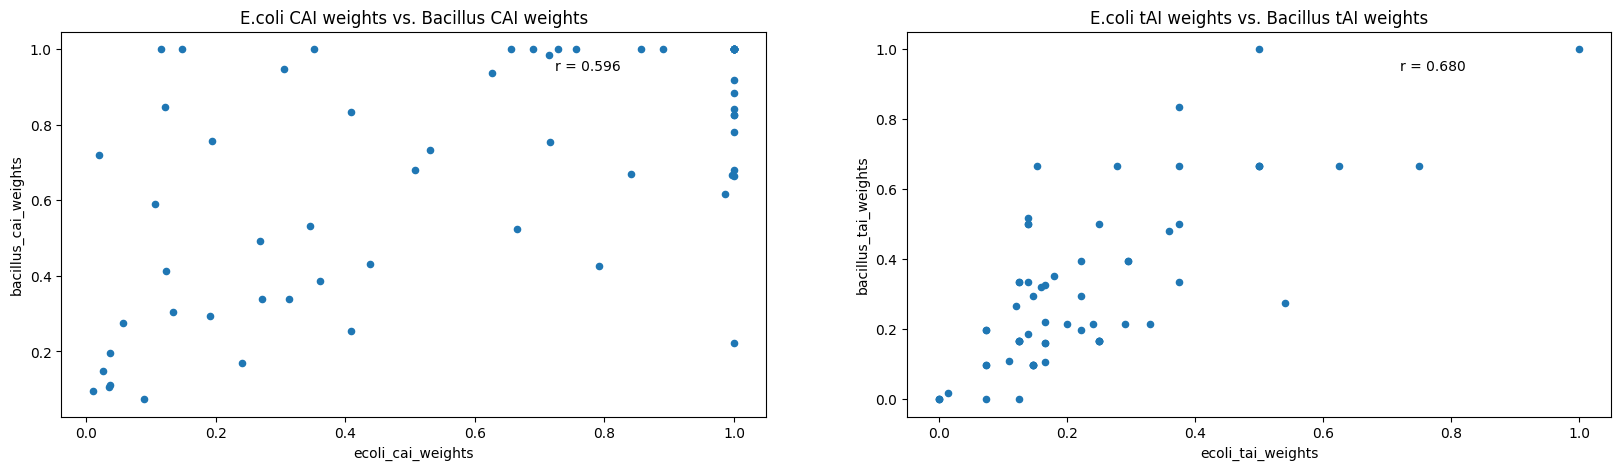

In [44]:
fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(20,5))
scatter = weights_dataframe.plot.scatter(x="ecoli_cai_weights", y="bacillus_cai_weights", title="E.coli CAI weights vs. Bacillus CAI weights", ax=axes[0])
r, p = stats.spearmanr(weights_dataframe["ecoli_cai_weights"], weights_dataframe["bacillus_cai_weights"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = weights_dataframe.plot.scatter(x="ecoli_tai_weights", y="bacillus_tai_weights", title="E.coli tAI weights vs. Bacillus tAI weights", ax=axes[1])
r, p = stats.spearmanr(weights_dataframe["ecoli_tai_weights"], weights_dataframe["bacillus_tai_weights"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

Text(0.7, 0.9, 'r = 0.2459, p=0.05013615573693014')

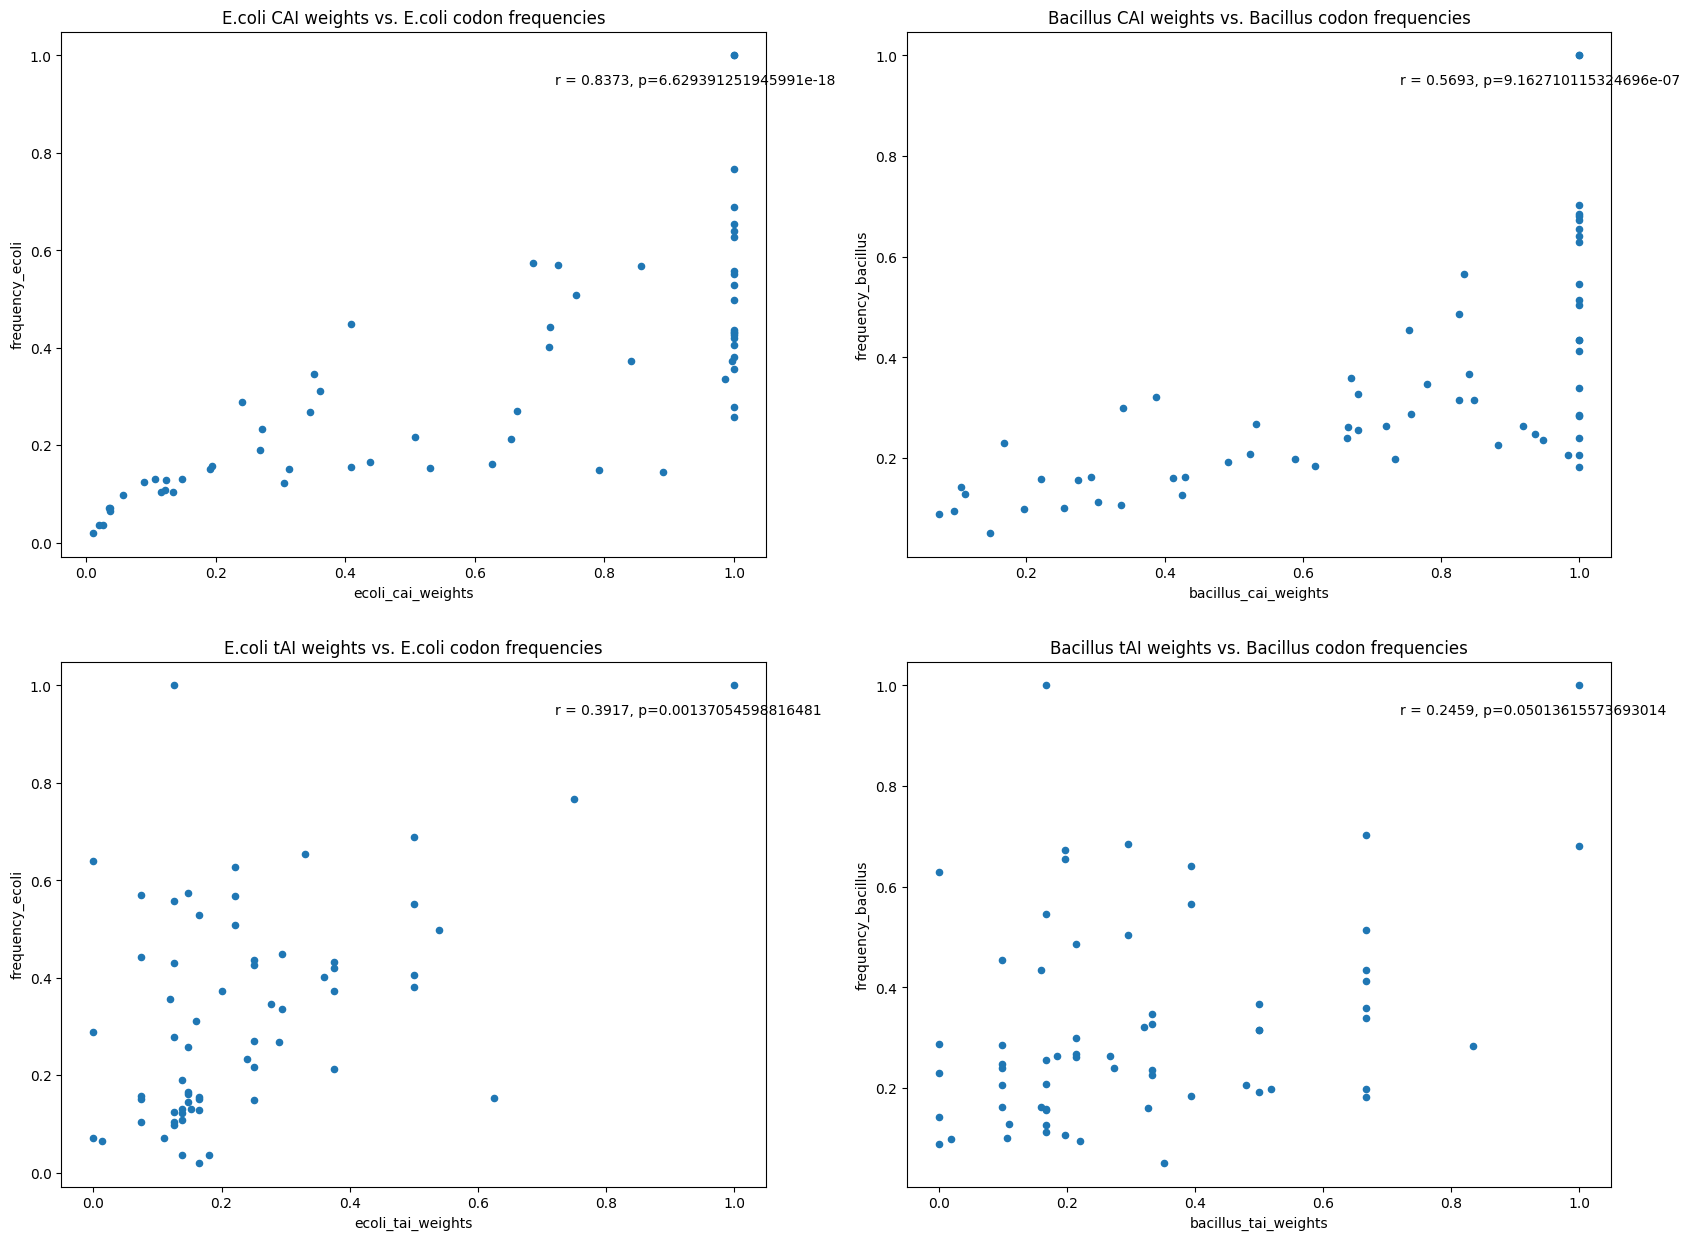

In [45]:
merged_weights_codon_frequencies_df = pd.merge(weights_dataframe, ecoli_codon_frequencies, on='codon', how='inner')
merged_weights_codon_frequencies_df = pd.merge(merged_weights_codon_frequencies_df, bacillus_codon_frequencies, on='codon', how='inner', suffixes=("_ecoli", "_bacillus"))

fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(20,15))
scatter = merged_weights_codon_frequencies_df.plot.scatter(x="ecoli_cai_weights", y="frequency_ecoli", title="E.coli CAI weights vs. E.coli codon frequencies", ax=axes[0,0])
r, p = stats.spearmanr(merged_weights_codon_frequencies_df["ecoli_cai_weights"], merged_weights_codon_frequencies_df["frequency_ecoli"])
scatter.annotate('r = {:.4f}, p={}'.format(r, p), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = merged_weights_codon_frequencies_df.plot.scatter(x="bacillus_cai_weights", y="frequency_bacillus", title="Bacillus CAI weights vs. Bacillus codon frequencies", ax=axes[0,1])
r, p = stats.spearmanr(merged_weights_codon_frequencies_df["ecoli_cai_weights"], merged_weights_codon_frequencies_df["frequency_bacillus"])
scatter.annotate('r = {:.4f}, p={}'.format(r, p), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = merged_weights_codon_frequencies_df.plot.scatter(x="ecoli_tai_weights", y="frequency_ecoli", title="E.coli tAI weights vs. E.coli codon frequencies", ax=axes[1,0])
r, p = stats.spearmanr(merged_weights_codon_frequencies_df["ecoli_tai_weights"], merged_weights_codon_frequencies_df["frequency_ecoli"])
scatter.annotate('r = {:.4f}, p={}'.format(r, p), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = merged_weights_codon_frequencies_df.plot.scatter(x="bacillus_tai_weights", y="frequency_bacillus", title="Bacillus tAI weights vs. Bacillus codon frequencies", ax=axes[1,1])
r, p = stats.spearmanr(merged_weights_codon_frequencies_df["ecoli_tai_weights"], merged_weights_codon_frequencies_df["frequency_bacillus"])
scatter.annotate('r = {:.4f}, p={}'.format(r, p), xy=(0.7, 0.9), xycoords='axes fraction')

Text(0.7, 0.9, 'r = 0.2728, p=0.02920944321573461')

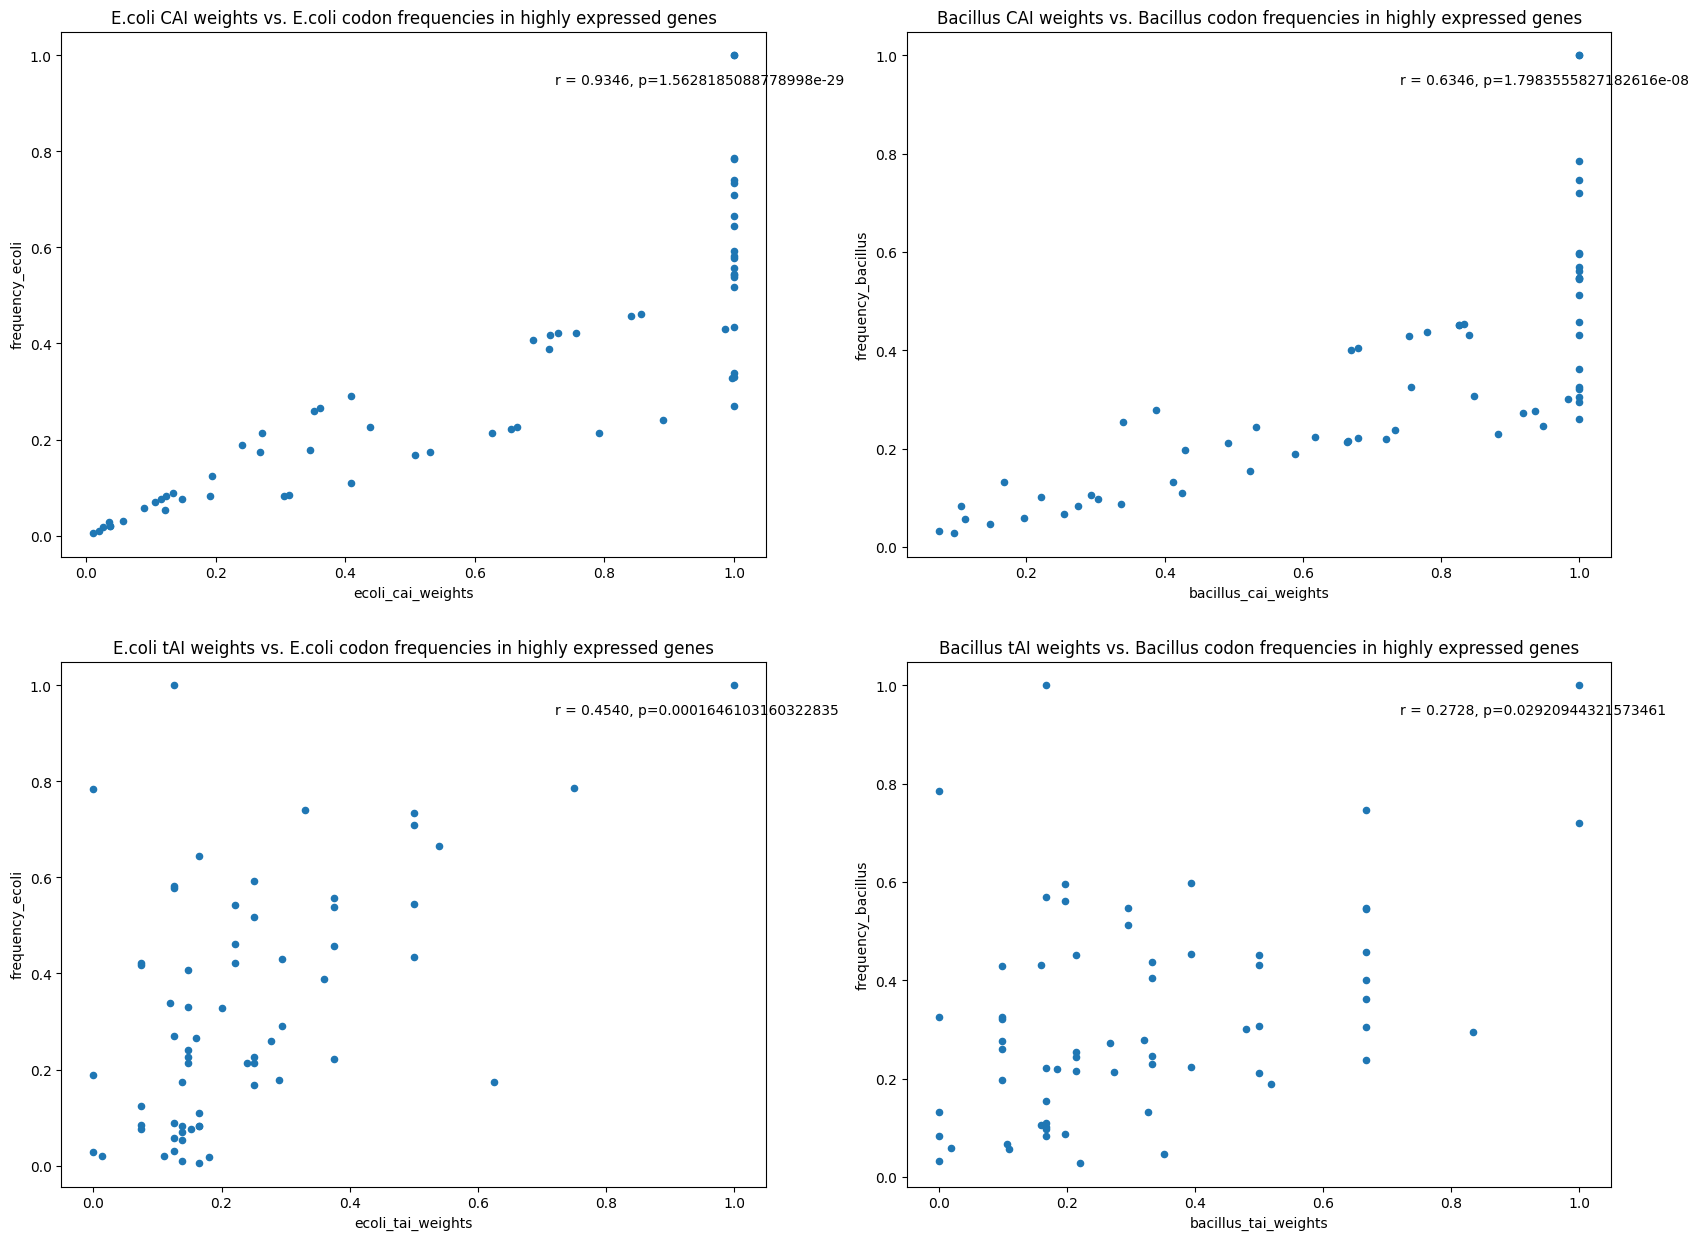

In [46]:
merged_weights_codon_frequencies_df = pd.merge(weights_dataframe, ecoli_highly_expressed_genes_codon_frequencies, on='codon', how='inner')
merged_weights_codon_frequencies_df = pd.merge(merged_weights_codon_frequencies_df, bacillus_highly_expressed_genes_codon_frequencies, on='codon', how='inner', suffixes=("_ecoli", "_bacillus"))

fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(20,15))
scatter = merged_weights_codon_frequencies_df.plot.scatter(x="ecoli_cai_weights", y="frequency_ecoli", title="E.coli CAI weights vs. E.coli codon frequencies in highly expressed genes", ax=axes[0,0])
r, p = stats.spearmanr(merged_weights_codon_frequencies_df["ecoli_cai_weights"], merged_weights_codon_frequencies_df["frequency_ecoli"])
scatter.annotate('r = {:.4f}, p={}'.format(r, p), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = merged_weights_codon_frequencies_df.plot.scatter(x="bacillus_cai_weights", y="frequency_bacillus", title="Bacillus CAI weights vs. Bacillus codon frequencies in highly expressed genes", ax=axes[0,1])
r, p = stats.spearmanr(merged_weights_codon_frequencies_df["ecoli_cai_weights"], merged_weights_codon_frequencies_df["frequency_bacillus"])
scatter.annotate('r = {:.4f}, p={}'.format(r, p), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = merged_weights_codon_frequencies_df.plot.scatter(x="ecoli_tai_weights", y="frequency_ecoli", title="E.coli tAI weights vs. E.coli codon frequencies in highly expressed genes", ax=axes[1,0])
r, p = stats.spearmanr(merged_weights_codon_frequencies_df["ecoli_tai_weights"], merged_weights_codon_frequencies_df["frequency_ecoli"])
scatter.annotate('r = {:.4f}, p={}'.format(r, p), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = merged_weights_codon_frequencies_df.plot.scatter(x="bacillus_tai_weights", y="frequency_bacillus", title="Bacillus tAI weights vs. Bacillus codon frequencies in highly expressed genes", ax=axes[1,1])
r, p = stats.spearmanr(merged_weights_codon_frequencies_df["ecoli_tai_weights"], merged_weights_codon_frequencies_df["frequency_bacillus"])
scatter.annotate('r = {:.4f}, p={}'.format(r, p), xy=(0.7, 0.9), xycoords='axes fraction')

In [47]:
ecoli_cai_scores, ecoli_tai_scores = get_cub_scores(r"C:\projects\Igem_TAU_2021_moran\analysis\example_data\Escherichia-coli_True_parsed.json")
bacillus_cai_scores, bacillus_tai_scores = get_cub_scores(r"C:\projects\Igem_TAU_2021_moran\analysis\example_data\Bacillus-subtilis_False_parsed.json")

In [48]:
def get_scores(estimated_expression_dict, cai_scores_dict, tai_scores_dict, expression_type, selected_genes=None):
    all_cds = cai_scores_dict.keys()
    selected_genes = selected_genes or all_cds
    filtered_cds = []
    expression_levels = []
    
    expression_levels_key = "mrna_level" if expression_type == "mrna_levels" else "pa"
    for k in all_cds:
        if not any(k.startswith(x) for x in selected_genes):
            continue
        short_name = k.split(" ")[0]
        if short_name in estimated_expression_dict:
            expression_levels.append(estimated_expression_dict[short_name][expression_levels_key])
            filtered_cds.append(k)

    scores_expression_levels_df_dict = {
        "gene": filtered_cds, 
        "cai_scores": [cai_scores_dict[k] for k in filtered_cds],
        "tai_scores": [tai_scores_dict[k] for k in filtered_cds],
        expression_levels_key: expression_levels,
    }
    return pd.DataFrame(scores_expression_levels_df_dict)

Ecoli mrna levels stats:
 records:3215
 min: 2.77694 
 max: 9134.66
 mean: 1076.834258622084
 std: 1335.093916895283
Bacillus mrna levels stats:
 records:1863
 min: 0.1 
 max: 1037.55
 mean: 19.086349973161564
 std: 64.85824879973497


<AxesSubplot:>

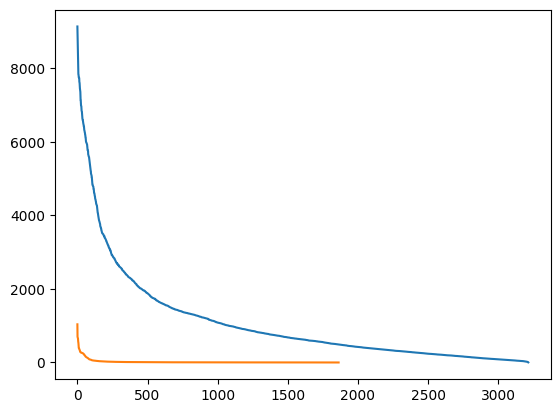

In [49]:
expression_type = "mrna_levels"
ecoli_estimated_expression = get_estimated_expression(endogenous_genes_fasta_file_path=ecoli_endogenous_genes_fasta_file_path,
                                                      expression_levels_file_path=r"C:\projects\Igem_TAU_2021_moran\analysis\example_data\ecoli_mrna_level.csv",
                                                      expression_type=expression_type)
ecoli_scores_dataframe =  get_scores(estimated_expression_dict=ecoli_estimated_expression, cai_scores_dict=ecoli_cai_scores, tai_scores_dict=ecoli_tai_scores, expression_type=expression_type)
print(f"Ecoli mrna levels stats:\n records:{len(ecoli_scores_dataframe['mrna_level'])}\n min: {ecoli_scores_dataframe['mrna_level'].min()} \n max: {ecoli_scores_dataframe['mrna_level'].max()}\n mean: {ecoli_scores_dataframe['mrna_level'].mean()}\n std: {ecoli_scores_dataframe['mrna_level'].std()}")  
ecoli_scores_dataframe["mrna_level"].sort_values(ascending=False).reset_index(drop=True).plot()

bacillus_estimated_expression = get_estimated_expression(endogenous_genes_fasta_file_path=bacillus_endogenous_genes_fasta_file_path,
                                                         expression_levels_file_path=r"C:\projects\Igem_TAU_2021_moran\analysis\example_data\bacillus_mrna_level.csv",
                                                          expression_type=expression_type)
bacillus_scores_dataframe =  get_scores(estimated_expression_dict=bacillus_estimated_expression, cai_scores_dict=bacillus_cai_scores, tai_scores_dict=bacillus_tai_scores, expression_type=expression_type)
print(f"Bacillus mrna levels stats:\n records:{len(bacillus_scores_dataframe['mrna_level'])}\n min: {bacillus_scores_dataframe['mrna_level'].min()} \n max: {bacillus_scores_dataframe['mrna_level'].max()}\n mean: {bacillus_scores_dataframe['mrna_level'].mean()}\n std: {bacillus_scores_dataframe['mrna_level'].std()}")  
bacillus_scores_dataframe["mrna_level"].sort_values(ascending=False).reset_index(drop=True).plot()

Text(0.7, 0.9, 'r = 0.2670, p=8.930948264085526e-32')

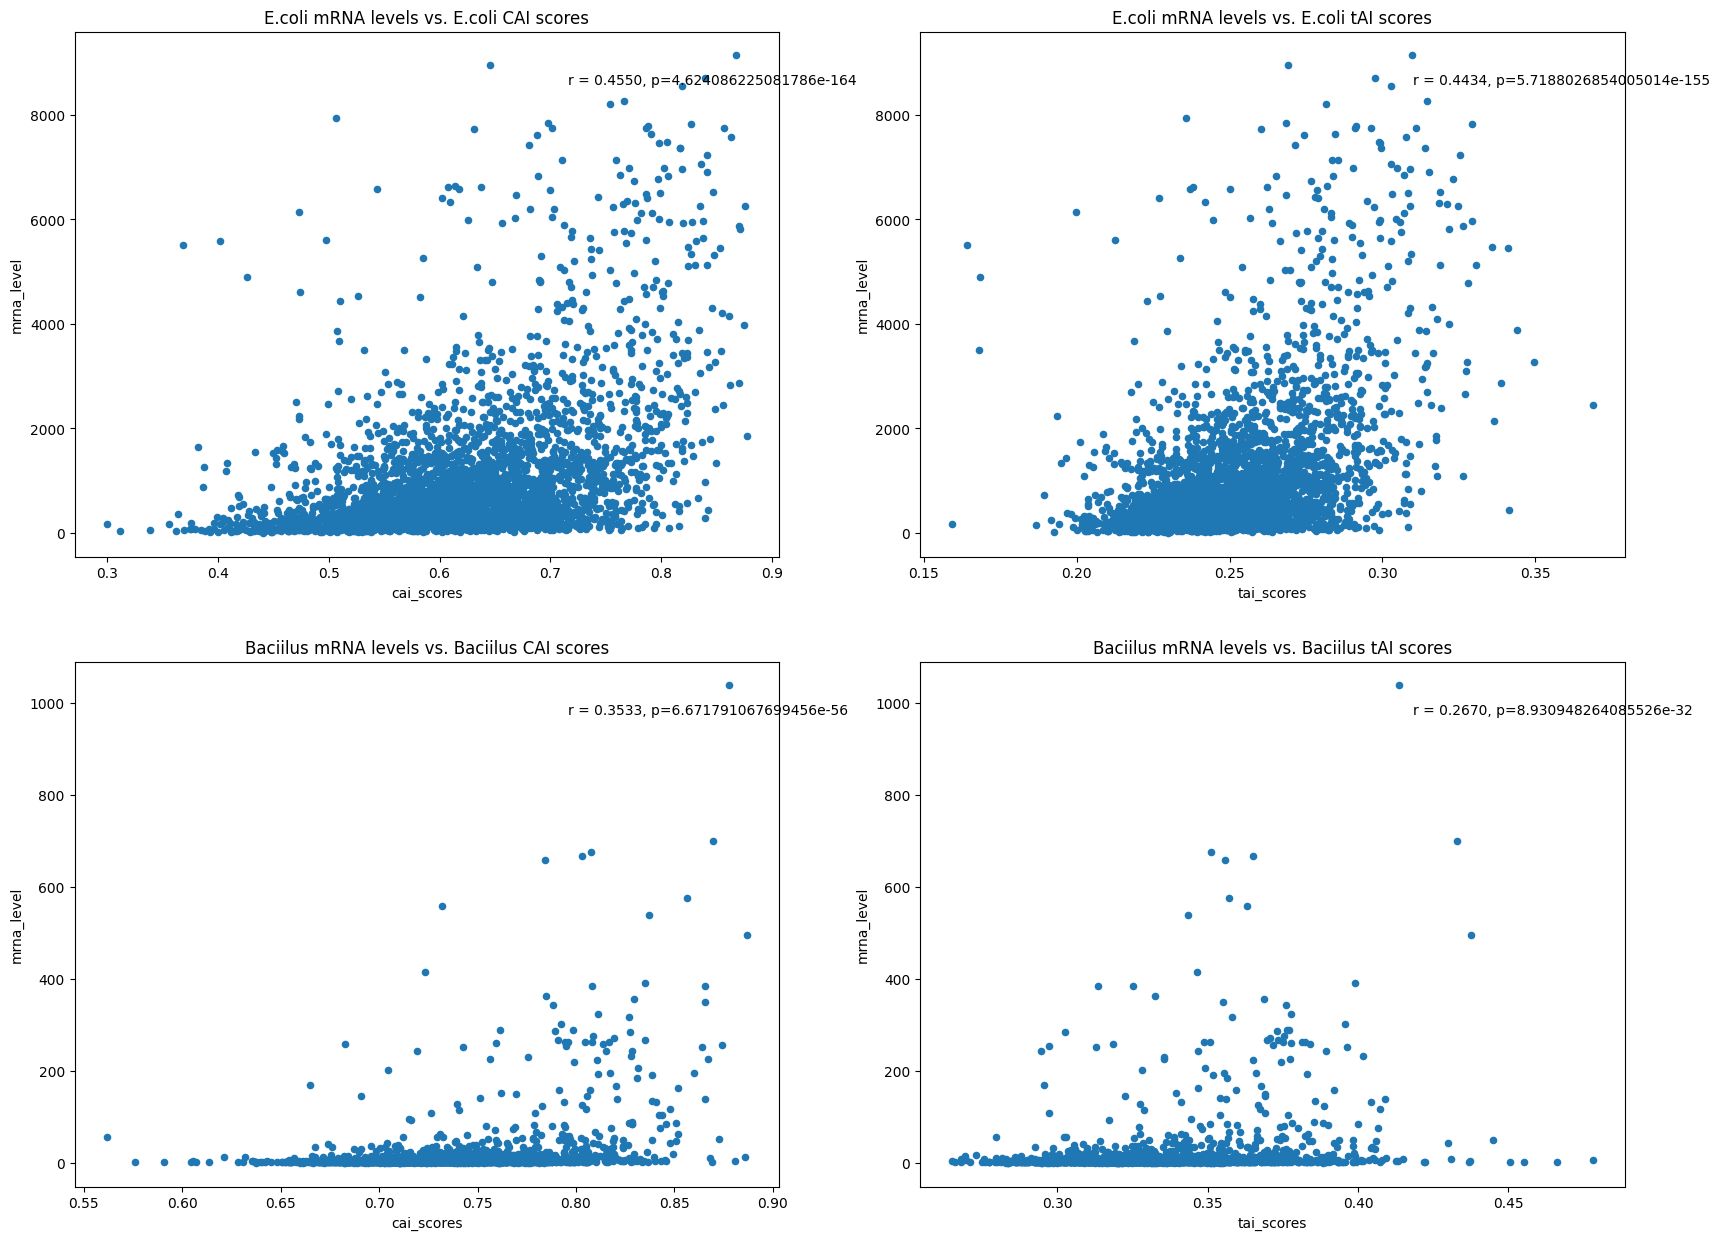

In [50]:
fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(20,15))

scatter = ecoli_scores_dataframe.plot.scatter(x="cai_scores", y="mrna_level", title="E.coli mRNA levels vs. E.coli CAI scores", ax=axes[0,0])
r, p = stats.spearmanr(ecoli_scores_dataframe["cai_scores"], ecoli_scores_dataframe["mrna_level"])
scatter.annotate('r = {:.4f}, p={}'.format(r, p), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = ecoli_scores_dataframe.plot.scatter(x="tai_scores", y="mrna_level", title="E.coli mRNA levels vs. E.coli tAI scores", ax=axes[0,1])
r, p = stats.spearmanr(ecoli_scores_dataframe["tai_scores"], ecoli_scores_dataframe["mrna_level"])
scatter.annotate('r = {:.4f}, p={}'.format(r, p), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = bacillus_scores_dataframe.plot.scatter(x="cai_scores", y="mrna_level", title="Baciilus mRNA levels vs. Baciilus CAI scores", ax=axes[1,0])
r, p = stats.spearmanr(bacillus_scores_dataframe["cai_scores"], bacillus_scores_dataframe["mrna_level"])
scatter.annotate('r = {:.4f}, p={}'.format(r, p), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = bacillus_scores_dataframe.plot.scatter(x="tai_scores", y="mrna_level", title="Baciilus mRNA levels vs. Baciilus tAI scores", ax=axes[1,1])
r, p = stats.spearmanr(bacillus_scores_dataframe["tai_scores"], bacillus_scores_dataframe["mrna_level"])
scatter.annotate('r = {:.4f}, p={}'.format(r, p), xy=(0.7, 0.9), xycoords='axes fraction')

Ecoli mrna levels stats:
 records:525
 min: 45.2732 
 max: 9134.66
 mean: 2873.2651965714285
 std: 2029.4328832847548
Bacillus mrna levels stats:
 records:419
 min: 0.3 
 max: 1037.55
 mean: 64.19424821002387
 std: 123.71735421734945


<AxesSubplot:>

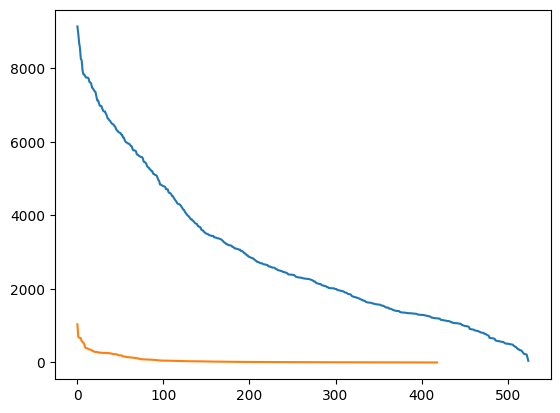

In [51]:
expression_type = "mrna_levels"
ecoli_estimated_expression = get_estimated_expression(endogenous_genes_fasta_file_path=ecoli_endogenous_genes_fasta_file_path,
                                                      expression_levels_file_path=r"C:\projects\Igem_TAU_2021_moran\analysis\example_data\ecoli_mrna_level.csv",
                                                      expression_type=expression_type)
ecoli_highly_expressed_scores_dataframe =  get_scores(estimated_expression_dict=ecoli_estimated_expression, cai_scores_dict=ecoli_cai_scores, tai_scores_dict=ecoli_tai_scores, selected_genes=ecoli_highly_expressed_genes.keys(), expression_type=expression_type)
print(f"Ecoli mrna levels stats:\n records:{len(ecoli_highly_expressed_scores_dataframe['mrna_level'])}\n min: {ecoli_highly_expressed_scores_dataframe['mrna_level'].min()} \n max: {ecoli_highly_expressed_scores_dataframe['mrna_level'].max()}\n mean: {ecoli_highly_expressed_scores_dataframe['mrna_level'].mean()}\n std: {ecoli_highly_expressed_scores_dataframe['mrna_level'].std()}")  
ecoli_highly_expressed_scores_dataframe["mrna_level"].sort_values(ascending=False).reset_index(drop=True).plot()
bacillus_estimated_expression = get_estimated_expression(endogenous_genes_fasta_file_path=bacillus_endogenous_genes_fasta_file_path,
                                                      expression_levels_file_path=r"C:\projects\Igem_TAU_2021_moran\analysis\example_data\bacillus_mrna_level.csv",
                                                        expression_type=expression_type)
bacillus_highly_expressed_scores_dataframe =  get_scores(estimated_expression_dict=bacillus_estimated_expression, cai_scores_dict=bacillus_cai_scores, tai_scores_dict=bacillus_tai_scores, selected_genes=bacillus_highly_expressed_genes.keys(), expression_type=expression_type)
print(f"Bacillus mrna levels stats:\n records:{len(bacillus_highly_expressed_scores_dataframe['mrna_level'])}\n min: {bacillus_highly_expressed_scores_dataframe['mrna_level'].min()} \n max: {bacillus_highly_expressed_scores_dataframe['mrna_level'].max()}\n mean: {bacillus_highly_expressed_scores_dataframe['mrna_level'].mean()}\n std: {bacillus_highly_expressed_scores_dataframe['mrna_level'].std()}")  
bacillus_highly_expressed_scores_dataframe["mrna_level"].sort_values(ascending=False).reset_index(drop=True).plot()

Text(0.7, 0.9, 'r = 0.2955, p=6.867693840115068e-10')

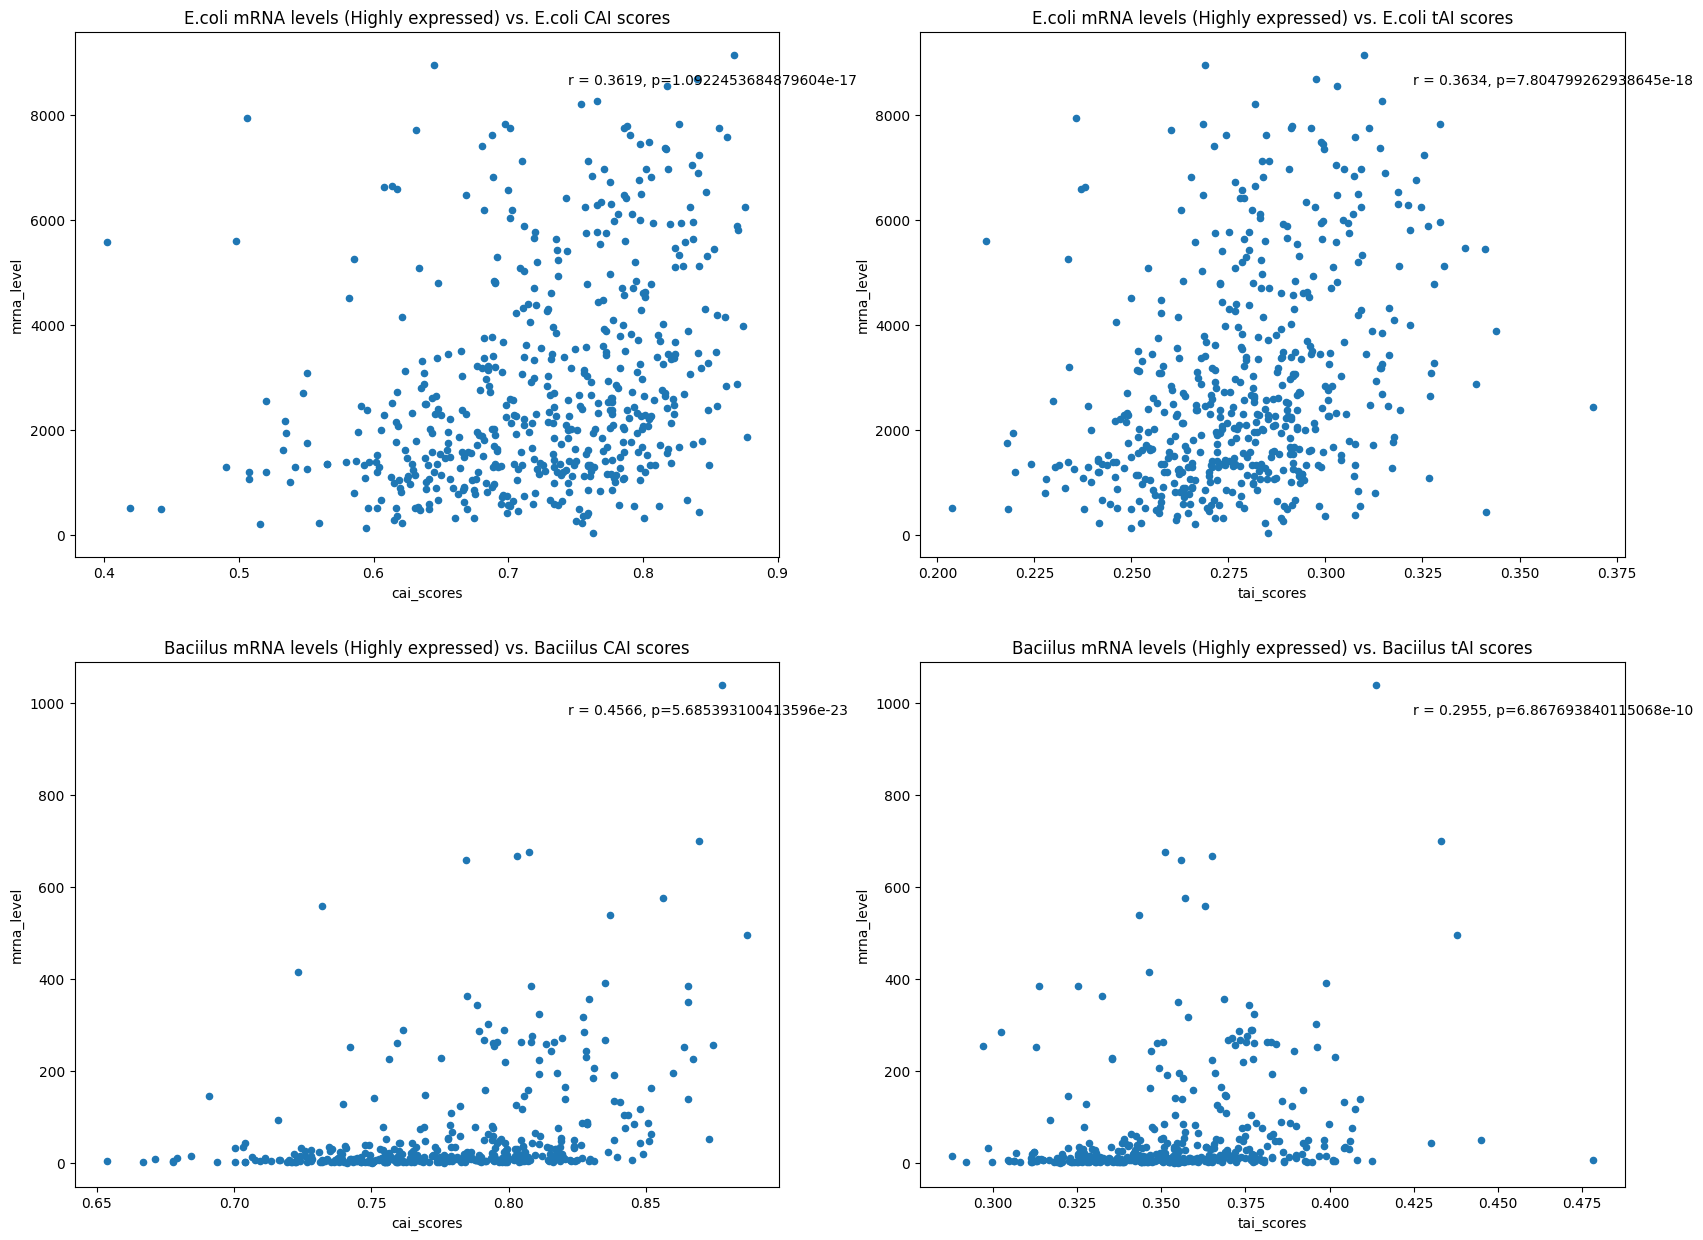

In [52]:
fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(20,15))

scatter = ecoli_highly_expressed_scores_dataframe.plot.scatter(x="cai_scores", y="mrna_level", title="E.coli mRNA levels (Highly expressed) vs. E.coli CAI scores", ax=axes[0,0])
r, p = stats.spearmanr(ecoli_highly_expressed_scores_dataframe["cai_scores"], ecoli_highly_expressed_scores_dataframe["mrna_level"])
scatter.annotate('r = {:.4f}, p={}'.format(r, p), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = ecoli_highly_expressed_scores_dataframe.plot.scatter(x="tai_scores", y="mrna_level", title="E.coli mRNA levels (Highly expressed) vs. E.coli tAI scores", ax=axes[0,1])
r, p = stats.spearmanr(ecoli_highly_expressed_scores_dataframe["tai_scores"], ecoli_highly_expressed_scores_dataframe["mrna_level"])
scatter.annotate('r = {:.4f}, p={}'.format(r, p), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = bacillus_highly_expressed_scores_dataframe.plot.scatter(x="cai_scores", y="mrna_level", title="Baciilus mRNA levels (Highly expressed) vs. Baciilus CAI scores", ax=axes[1,0])
r, p = stats.spearmanr(bacillus_highly_expressed_scores_dataframe["cai_scores"], bacillus_highly_expressed_scores_dataframe["mrna_level"])
scatter.annotate('r = {:.4f}, p={}'.format(r, p), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = bacillus_highly_expressed_scores_dataframe.plot.scatter(x="tai_scores", y="mrna_level", title="Baciilus mRNA levels (Highly expressed) vs. Baciilus tAI scores", ax=axes[1,1])
r, p = stats.spearmanr(bacillus_highly_expressed_scores_dataframe["tai_scores"], bacillus_highly_expressed_scores_dataframe["mrna_level"])
scatter.annotate('r = {:.4f}, p={}'.format(r, p), xy=(0.7, 0.9), xycoords='axes fraction')

Ecoli protein abundance stats:
 records:3892
 min: 0.0 
 max: 82534.0
 mean: 252.11530909558067
 std: 1560.8201786572558
Bacillus protein abundance stats:
 records:3543
 min: 0.092 
 max: 27351.0
 mean: 265.51427236804966
 std: 1249.33101300844


<AxesSubplot:>

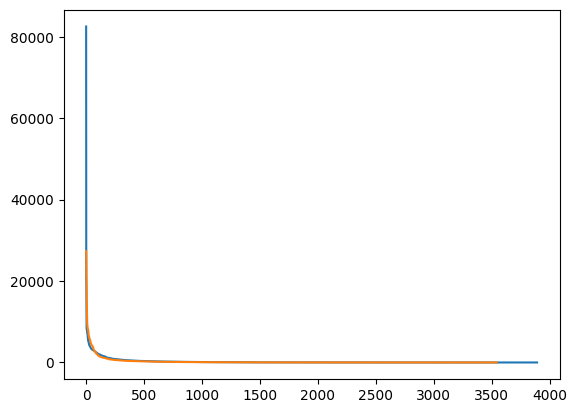

In [53]:
expression_type = "protein_abundance"
ecoli_estimated_expression_pa = get_estimated_expression(endogenous_genes_fasta_file_path=ecoli_endogenous_genes_fasta_file_path,
                                                         expression_levels_file_path=r"C:\projects\Igem_TAU_2021_moran\analysis\example_data\PA_ecoli.json",
                                                         expression_type=expression_type)
ecoli_scores_dataframe_pa =  get_scores(estimated_expression_dict=ecoli_estimated_expression_pa, cai_scores_dict=ecoli_cai_scores, tai_scores_dict=ecoli_tai_scores, expression_type=expression_type)
print(f"Ecoli protein abundance stats:\n records:{len(ecoli_scores_dataframe_pa['pa'])}\n min: {ecoli_scores_dataframe_pa['pa'].min()} \n max: {ecoli_scores_dataframe_pa['pa'].max()}\n mean: {ecoli_scores_dataframe_pa['pa'].mean()}\n std: {ecoli_scores_dataframe_pa['pa'].std()}")  
ecoli_scores_dataframe_pa["pa"].sort_values(ascending=False).reset_index(drop=True).plot()

bacillus_estimated_expression_pa = get_estimated_expression(endogenous_genes_fasta_file_path=bacillus_endogenous_genes_fasta_file_path,
                                                         expression_levels_file_path=r"C:\projects\Igem_TAU_2021_moran\analysis\example_data\PA_bacillus.json",
                                                          expression_type=expression_type)
bacillus_scores_dataframe_pa =  get_scores(estimated_expression_dict=bacillus_estimated_expression_pa, cai_scores_dict=bacillus_cai_scores, tai_scores_dict=bacillus_tai_scores, expression_type=expression_type)
print(f"Bacillus protein abundance stats:\n records:{len(bacillus_scores_dataframe_pa['pa'])}\n min: {bacillus_scores_dataframe_pa['pa'].min()} \n max: {bacillus_scores_dataframe_pa['pa'].max()}\n mean: {bacillus_scores_dataframe_pa['pa'].mean()}\n std: {bacillus_scores_dataframe_pa['pa'].std()}")  
bacillus_scores_dataframe_pa["pa"].sort_values(ascending=False).reset_index(drop=True).plot()

Text(0.7, 0.9, 'r = 0.4157, p=4.249230923123024e-148')

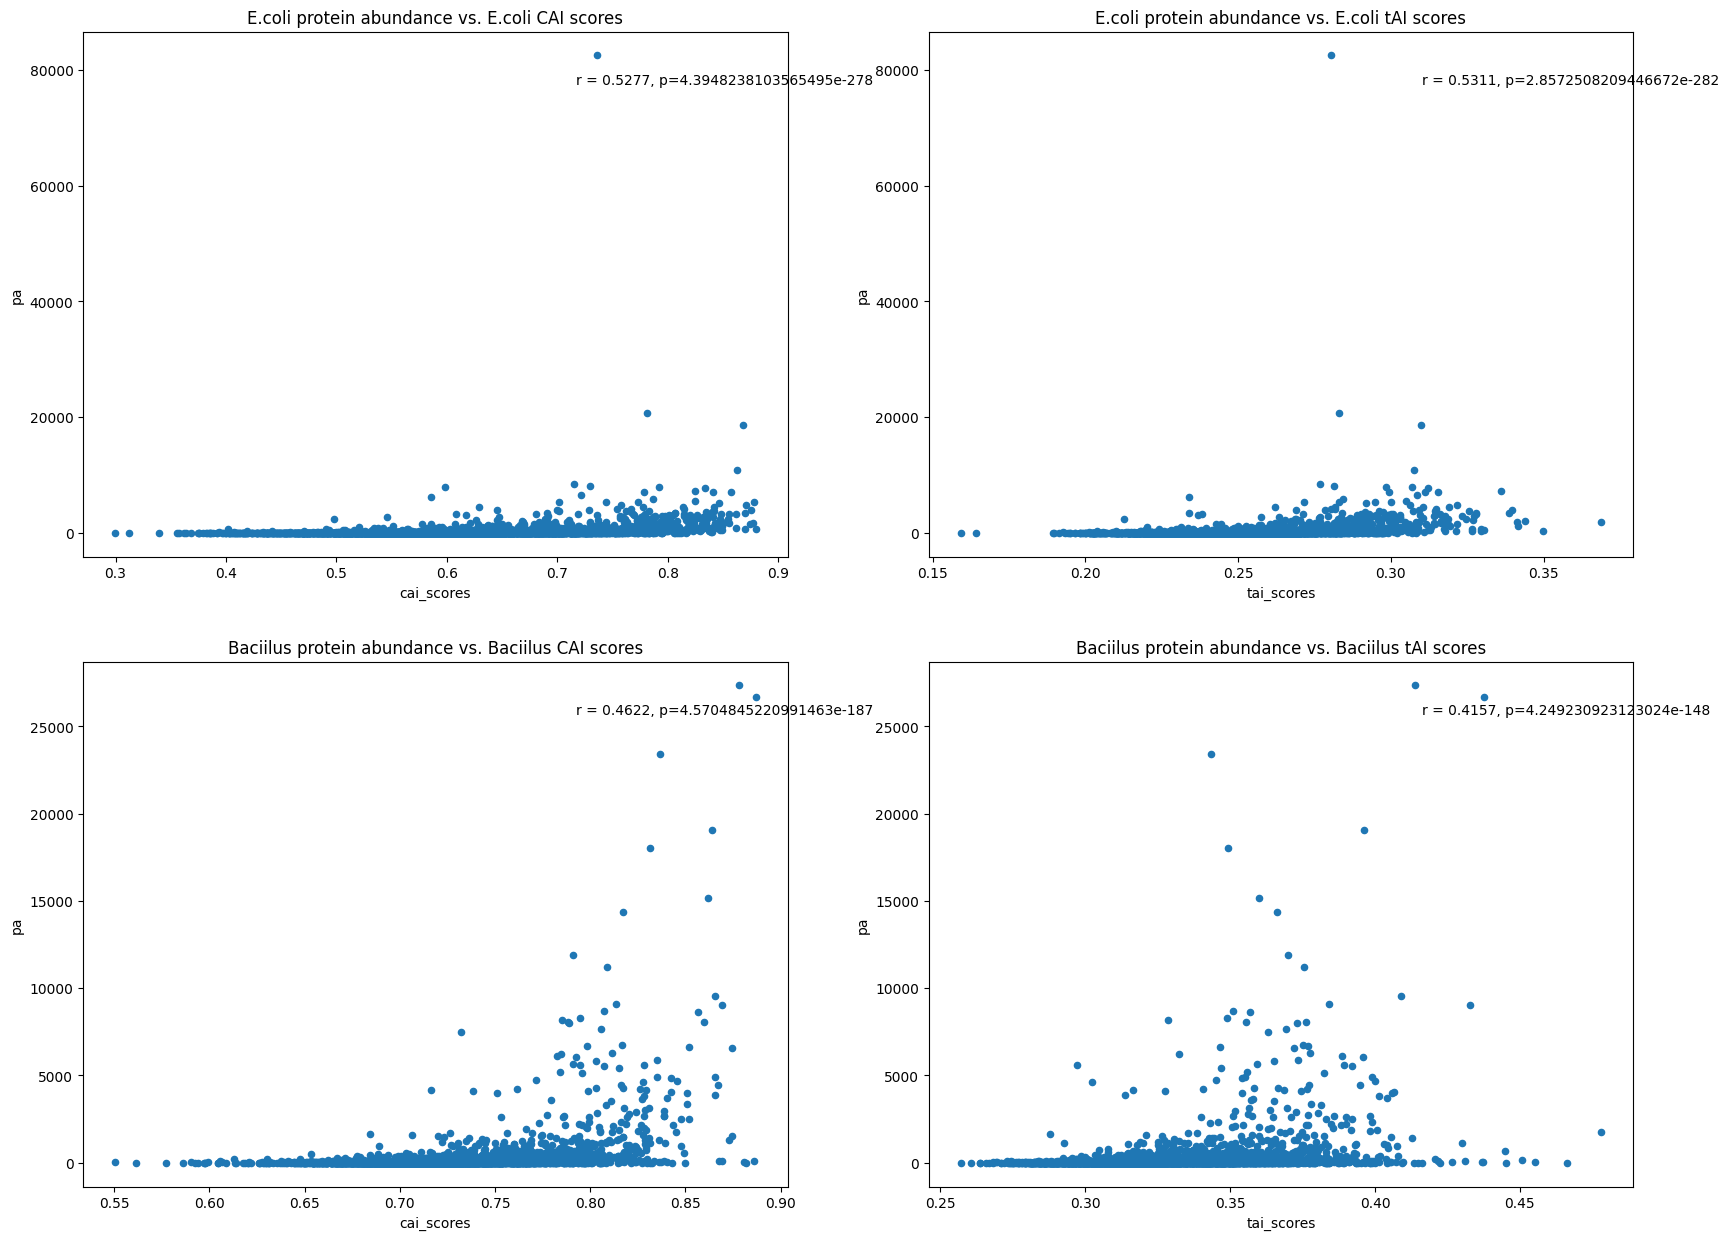

In [54]:
fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(20,15))

scatter = ecoli_scores_dataframe_pa.plot.scatter(x="cai_scores", y="pa", title="E.coli protein abundance vs. E.coli CAI scores", ax=axes[0,0])
r, p = stats.spearmanr(ecoli_scores_dataframe_pa["cai_scores"], ecoli_scores_dataframe_pa["pa"])
scatter.annotate('r = {:.4f}, p={}'.format(r, p), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = ecoli_scores_dataframe_pa.plot.scatter(x="tai_scores", y="pa", title="E.coli protein abundance vs. E.coli tAI scores", ax=axes[0,1])
r, p = stats.spearmanr(ecoli_scores_dataframe_pa["tai_scores"], ecoli_scores_dataframe_pa["pa"])
scatter.annotate('r = {:.4f}, p={}'.format(r, p), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = bacillus_scores_dataframe_pa.plot.scatter(x="cai_scores", y="pa", title="Baciilus protein abundance vs. Baciilus CAI scores", ax=axes[1,0])
r, p = stats.spearmanr(bacillus_scores_dataframe_pa["cai_scores"], bacillus_scores_dataframe_pa["pa"])
scatter.annotate('r = {:.4f}, p={}'.format(r, p), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = bacillus_scores_dataframe_pa.plot.scatter(x="tai_scores", y="pa", title="Baciilus protein abundance vs. Baciilus tAI scores", ax=axes[1,1])
r, p = stats.spearmanr(bacillus_scores_dataframe_pa["tai_scores"], bacillus_scores_dataframe_pa["pa"])
scatter.annotate('r = {:.4f}, p={}'.format(r, p), xy=(0.7, 0.9), xycoords='axes fraction')

Ecoli protein abundance stats:
 records:584
 min: 283.0 
 max: 82534.0
 mean: 1481.791095890411
 std: 3802.0128366170084
Bacillus protein abundance stats:
 records:531
 min: 250.0 
 max: 27351.0
 mean: 1562.949152542373
 std: 2903.748471885211


<AxesSubplot:>

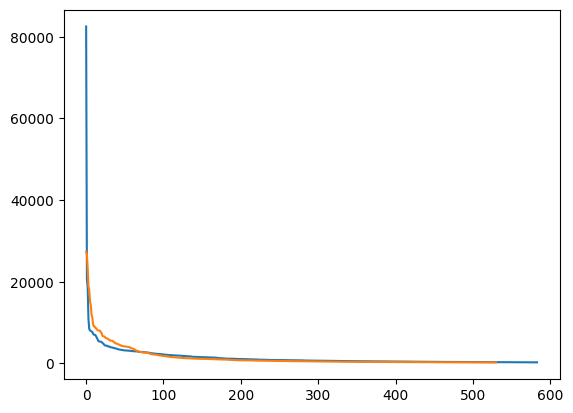

In [55]:
expression_type = "protein_abundance"
ecoli_estimated_expression_pa = get_estimated_expression(endogenous_genes_fasta_file_path=ecoli_endogenous_genes_fasta_file_path,
                                                         expression_levels_file_path=r"C:\projects\Igem_TAU_2021_moran\analysis\example_data\PA_ecoli.json",
                                                         expression_type=expression_type)
ecoli_scores_dataframe_pa_highly_expressed =  get_scores(estimated_expression_dict=ecoli_estimated_expression_pa, cai_scores_dict=ecoli_cai_scores, tai_scores_dict=ecoli_tai_scores, expression_type=expression_type, selected_genes=ecoli_highly_expressed_genes.keys())
print(f"Ecoli protein abundance stats:\n records:{len(ecoli_scores_dataframe_pa_highly_expressed['pa'])}\n min: {ecoli_scores_dataframe_pa_highly_expressed['pa'].min()} \n max: {ecoli_scores_dataframe_pa_highly_expressed['pa'].max()}\n mean: {ecoli_scores_dataframe_pa_highly_expressed['pa'].mean()}\n std: {ecoli_scores_dataframe_pa_highly_expressed['pa'].std()}")  
ecoli_scores_dataframe_pa_highly_expressed["pa"].sort_values(ascending=False).reset_index(drop=True).plot()

bacillus_estimated_expression_pa = get_estimated_expression(endogenous_genes_fasta_file_path=bacillus_endogenous_genes_fasta_file_path,
                                                         expression_levels_file_path=r"C:\projects\Igem_TAU_2021_moran\analysis\example_data\PA_bacillus.json",
                                                          expression_type=expression_type)
bacillus_scores_dataframe_pa_highly_expressed =  get_scores(estimated_expression_dict=bacillus_estimated_expression_pa, cai_scores_dict=bacillus_cai_scores, tai_scores_dict=bacillus_tai_scores, expression_type=expression_type, selected_genes=bacillus_highly_expressed_genes.keys())
print(f"Bacillus protein abundance stats:\n records:{len(bacillus_scores_dataframe_pa_highly_expressed['pa'])}\n min: {bacillus_scores_dataframe_pa_highly_expressed['pa'].min()} \n max: {bacillus_scores_dataframe_pa_highly_expressed['pa'].max()}\n mean: {bacillus_scores_dataframe_pa_highly_expressed['pa'].mean()}\n std: {bacillus_scores_dataframe_pa_highly_expressed['pa'].std()}")  
bacillus_scores_dataframe_pa_highly_expressed["pa"].sort_values(ascending=False).reset_index(drop=True).plot()

Text(0.7, 0.9, 'r = 0.3794, p=1.2786680615726634e-19')

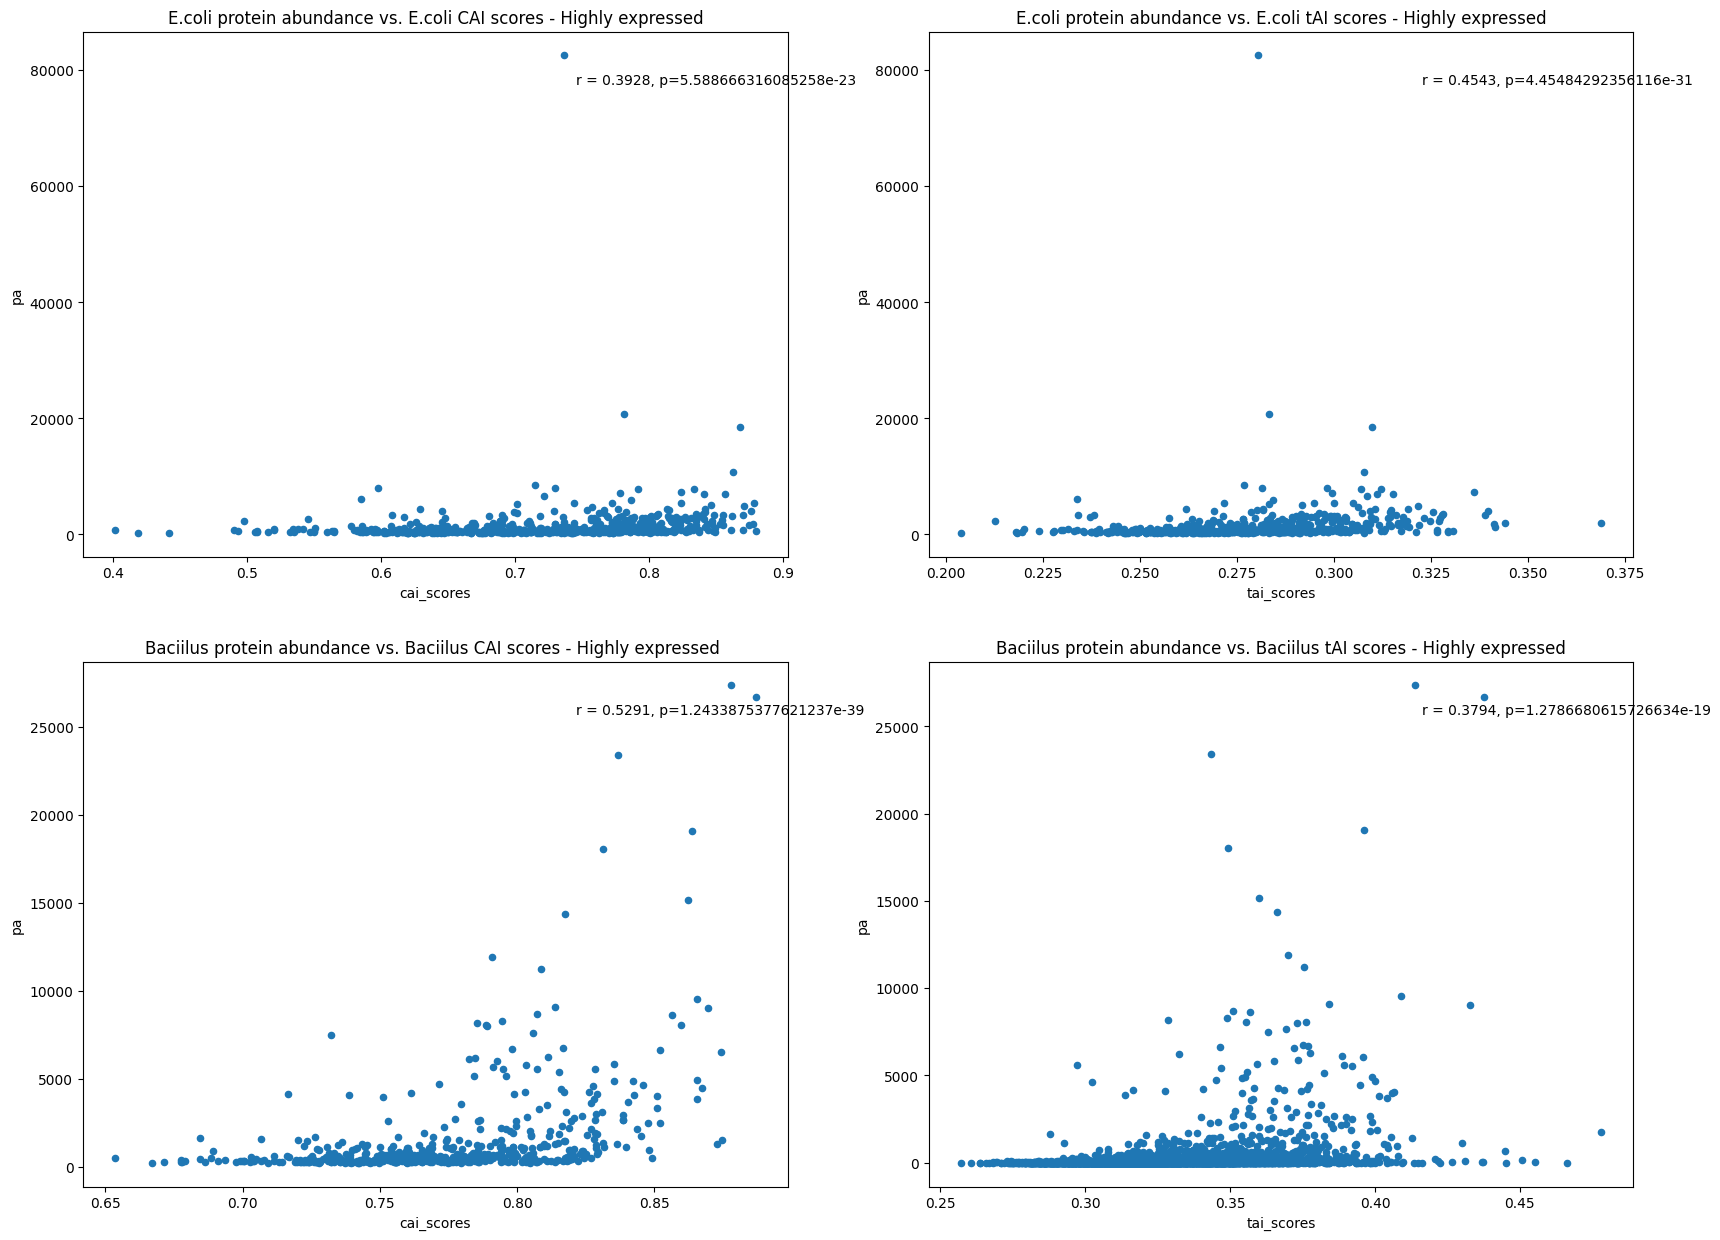

In [56]:
fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(20,15))

scatter = ecoli_scores_dataframe_pa_highly_expressed.plot.scatter(x="cai_scores", y="pa", title="E.coli protein abundance vs. E.coli CAI scores - Highly expressed", ax=axes[0,0])
r, p = stats.spearmanr(ecoli_scores_dataframe_pa_highly_expressed["cai_scores"], ecoli_scores_dataframe_pa_highly_expressed["pa"])
scatter.annotate('r = {:.4f}, p={}'.format(r, p), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = ecoli_scores_dataframe_pa_highly_expressed.plot.scatter(x="tai_scores", y="pa", title="E.coli protein abundance vs. E.coli tAI scores - Highly expressed", ax=axes[0,1])
r, p = stats.spearmanr(ecoli_scores_dataframe_pa_highly_expressed["tai_scores"], ecoli_scores_dataframe_pa_highly_expressed["pa"])
scatter.annotate('r = {:.4f}, p={}'.format(r, p), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = bacillus_scores_dataframe_pa_highly_expressed.plot.scatter(x="cai_scores", y="pa", title="Baciilus protein abundance vs. Baciilus CAI scores - Highly expressed ", ax=axes[1,0])
r, p = stats.spearmanr(bacillus_scores_dataframe_pa_highly_expressed["cai_scores"], bacillus_scores_dataframe_pa_highly_expressed["pa"])
scatter.annotate('r = {:.4f}, p={}'.format(r, p), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = bacillus_scores_dataframe_pa.plot.scatter(x="tai_scores", y="pa", title="Baciilus protein abundance vs. Baciilus tAI scores - Highly expressed", ax=axes[1,1])
r, p = stats.spearmanr(bacillus_scores_dataframe_pa_highly_expressed["tai_scores"], bacillus_scores_dataframe_pa_highly_expressed["pa"])
scatter.annotate('r = {:.4f}, p={}'.format(r, p), xy=(0.7, 0.9), xycoords='axes fraction')

# Verification of variants translation to correct amino acid sequence

Validating original mcherry sequence:

In [57]:
# Reference aa sequence is taken from: https://www.addgene.org/browse/sequence_vdb/6496/
reference_mcherry_protein_seq  = "MVSKGEEDNMAIIKEFMRFKVHMEGSVNGHEFEIEGEGEGRPYEGTQTAKLKVTKGGPLPFAWDILSPQFMYGSKAYVKHPADIPDYLKLSFPEGFKWERVMNFEDGGVVTVTQDSSLQDGEFIYKVKLRGTNFPSDGPVMQKKTMGWEASSERMYPEDGALKGEIKQRLKLKDGGHYDAEVKTTYKAKKPVQLPGAYNVNIKLDITSHNEDYTIVEQYERAEGRHSTGGMDELYK*"
formatted_reference_mcherry_protein_seq = reference_mcherry_protein_seq.replace("*", "_")

translated_original_mcherry_seq = shared_functions_and_vars.translate(original_mcherry_seq)

assert translated_original_mcherry_seq == formatted_reference_mcherry_protein_seq

Validating generated mcherry variants:

In [58]:
with open(mcherry_variants_file, "r") as mcherry_variants_fasta_file:
    mcherry_variants_dict = SeqIO.to_dict(SeqIO.parse(mcherry_variants_fasta_file, "fasta"))

for variant_name, variant_seq in mcherry_variants_dict.items():
    translated_seq = shared_functions_and_vars.translate(variant_seq.seq)
    if translated_seq != formatted_reference_mcherry_protein_seq:
        raise ValueError(f"Variant {variant_name} is not coding to correct sequence. \nReference sequence: {formatted_reference_mcherry_protein_seq} \nVariant sequence: {translated_seq}")

# Measurements for assessing variants scores 

#### Eucledean distance of codon frequencies

In [59]:
original_mcherry_codon_frequencies = calculate_codon_frequencies((str(original_mcherry_seq),))
original_mcherry_codon_frequencies = original_mcherry_codon_frequencies.sort_values("codon")

original_mcherry_codon_frequencies_lamda = calculate_codon_frequencies_lamda((str(original_mcherry_seq),))
original_mcherry_codon_frequencies_lamda = original_mcherry_codon_frequencies_lamda.sort_values("codon")

In [60]:
original_bacillus_dist = calculate_distance_between_frequencies(original_mcherry_codon_frequencies["frequency"].reset_index(drop=True), bacillus_codon_frequencies["frequency"].reset_index(drop=True))
original_ecoli_dist = calculate_distance_between_frequencies(original_mcherry_codon_frequencies["frequency"].reset_index(drop=True), ecoli_codon_frequencies["frequency"].reset_index(drop=True))

original_bacillus_dist_lamda = calculate_distance_between_frequencies(original_mcherry_codon_frequencies_lamda["frequency"].reset_index(drop=True), bacillus_codon_frequencies_lamda["frequency"].reset_index(drop=True))
original_ecoli_dist_lamda = calculate_distance_between_frequencies(original_mcherry_codon_frequencies_lamda["frequency"].reset_index(drop=True), ecoli_codon_frequencies_lamda["frequency"].reset_index(drop=True))

original_bacillus_dist_highly_expressed = calculate_distance_between_frequencies(original_mcherry_codon_frequencies["frequency"].reset_index(drop=True), bacillus_highly_expressed_genes_codon_frequencies["frequency"].reset_index(drop=True))
original_ecoli_dist_highly_expressed = calculate_distance_between_frequencies(original_mcherry_codon_frequencies["frequency"].reset_index(drop=True), ecoli_highly_expressed_genes_codon_frequencies["frequency"].reset_index(drop=True))

original_bacillus_dist_highly_expressed_lamda = calculate_distance_between_frequencies(original_mcherry_codon_frequencies_lamda["frequency"].reset_index(drop=True), bacillus_highly_expressed_genes_codon_frequencies_lamda["frequency"].reset_index(drop=True))
original_ecoli_dist_highly_expressed_lamda = calculate_distance_between_frequencies(original_mcherry_codon_frequencies_lamda["frequency"].reset_index(drop=True), ecoli_highly_expressed_genes_codon_frequencies_lamda["frequency"].reset_index(drop=True))

In [61]:
df_dict = get_variants_df_dict(mcherry_variants_file)

ecoli_opt_df_dict = {key: value for key, value in df_dict.items() if not key.endswith("for_optimized_bacillus")}
ecoli_opt_variants_dataframe = pd.DataFrame(ecoli_opt_df_dict)

bacillus_opt_df_dict = {key: value for key, value in df_dict.items() if not key.endswith("for_optimized_ecoli")}
bacillus_opt_variants_dataframe = pd.DataFrame(bacillus_opt_df_dict)

df_dict_highly_expressed = get_variants_df_dict_highly_expressed(mcherry_variants_file)

ecoli_opt_df_dict_highly_expressed = {key: value for key, value in df_dict_highly_expressed.items() if not key.endswith("for_optimized_bacillus")}
ecoli_opt_variants_dataframe_highly_expressed = pd.DataFrame(ecoli_opt_df_dict_highly_expressed)

bacillus_opt_df_dict_highly_expressed = {key: value for key, value in df_dict_highly_expressed.items() if not key.endswith("for_optimized_ecoli")}
bacillus_opt_variants_dataframe_highly_expressed = pd.DataFrame(bacillus_opt_df_dict_highly_expressed)

In [62]:
bacillus_A = bacillus_codon_frequencies[bacillus_codon_frequencies["amino_acid"] == "A"].sort_values("codon")
x = pd.DataFrame(get_codon_frequencies_df_dict(mcherry_variants_file))
x_A = x[x["amino_acid"] == "A"].sort_values("codon")
original_A = original_mcherry_codon_frequencies[original_mcherry_codon_frequencies["amino_acid"] == "A"].sort_values("codon")


original_dist = calculate_distance_between_frequencies(original_A["frequency"].reset_index(drop=True), bacillus_A["frequency"].reset_index(drop=True))
variant_dist = calculate_distance_between_frequencies(x_A["frequency"].reset_index(drop=True), bacillus_A["frequency"].reset_index(drop=True))
bacillus_A

codon amino_acid  frequency
36   GCA          A   0.282823
10   GCC          A   0.207163
42   GCG          A   0.262543
12   GCT          A   0.247470

In [63]:
original_A

codon amino_acid  frequency
51   GCA          A   0.000000
23   GCC          A   0.181818
29   GCG          A   0.636364
8    GCT          A   0.181818

In [64]:
x_A

codon amino_acid  frequency
40   GCA          A        0.0
41   GCC          A        0.0
42   GCG          A        0.0
8    GCT          A        1.0

In [65]:
print(f"original seq dist: {original_dist}, variant dist: {variant_dist}")

original seq dist: 0.4740076240253718, variant dist: 0.8707097798509963


#### CUB scores

In [66]:
df_dict = get_cub_score_df_dict(mcherry_root_dir)
cub_ecoli_opt_df_dict = {key.replace("_for_optimized_ecoli", ""): value for key, value in df_dict.items() if not (key.endswith("_for_optimized_bacillus") or key.startswith("evaluation_score"))}
cub_ecoli_opt_variants_dataframe = pd.DataFrame(cub_ecoli_opt_df_dict)

evaluation_ecoli_opt_df_dict = {key: value for key, value in df_dict.items() if key in ["variant", "evaluation_score_for_optimized_ecoli"]}
evaluation_ecoli_opt_variants_dataframe = pd.DataFrame(evaluation_ecoli_opt_df_dict)

cub_bacillus_opt_df_dict = {key.replace("_for_optimized_bacillus", ""): value for key, value in df_dict.items() if not (key.endswith("for_optimized_ecoli") or key.startswith("evaluation_score"))}
cub_bacillus_opt_variants_dataframe = pd.DataFrame(cub_bacillus_opt_df_dict)

evaluation_bacillus_opt_df_dict = {key: value for key, value in df_dict.items() if key in ["variant", "evaluation_score_for_optimized_bacillus"]}
evaluation_bacillus_opt_variants_dataframe = pd.DataFrame(evaluation_bacillus_opt_df_dict)

#### tuning parameter = 1 - Eucledean distance of codon frequencies

In [67]:
greater_alpha_df_dict = get_variants_df_dict(mcherry_greater_alpha_variants_file)
    
greater_alpha_ecoli_opt_df_dict = {key: value for key, value in greater_alpha_df_dict.items() if not key.endswith("for_optimized_bacillus")}
greater_alpha_ecoli_opt_variants_dataframe = pd.DataFrame(greater_alpha_ecoli_opt_df_dict)

greater_alpha_bacillus_opt_df_dict = {key: value for key, value in greater_alpha_df_dict.items() if not key.endswith("for_optimized_ecoli")}
greater_alpha_bacillus_opt_variants_dataframe = pd.DataFrame(greater_alpha_bacillus_opt_df_dict)

greater_alpha_df_dict_highly_expressed = get_variants_df_dict_highly_expressed(mcherry_greater_alpha_variants_file)

greater_alpha_ecoli_opt_df_dict_highly_expressed = {key: value for key, value in greater_alpha_df_dict_highly_expressed.items() if not key.endswith("for_optimized_bacillus")}
greater_alpha_ecoli_opt_variants_dataframe_highly_expressed = pd.DataFrame(greater_alpha_ecoli_opt_df_dict_highly_expressed)

greater_alpha_bacillus_opt_df_dict_highly_expressed = {key: value for key, value in greater_alpha_df_dict_highly_expressed.items() if not key.endswith("for_optimized_ecoli")}
greater_alpha_bacillus_opt_variants_dataframe_highly_expressed = pd.DataFrame(greater_alpha_bacillus_opt_df_dict_highly_expressed)

#### tuning parameter = 1 - CUB scores

In [68]:
greater_alpha_df_dict = get_cub_score_df_dict(mcherry_greater_alpha_root_dir)
cub_ecoli_opt_greater_alpha_df_dict = {key.replace("_for_optimized_ecoli", ""): value for key, value in greater_alpha_df_dict.items() if not (key.endswith("_for_optimized_bacillus") or key.startswith("evaluation_score"))}
cub_ecoli_opt_greater_alpha_variants_dataframe = pd.DataFrame(cub_ecoli_opt_greater_alpha_df_dict)

evaluation_ecoli_opt_greate_alpha_df_dict = {key: value for key, value in greater_alpha_df_dict.items() if key in ["variant", "evaluation_score_for_optimized_ecoli"]}
evaluation_ecoli_opt_greater_alpha_variants_dataframe = pd.DataFrame(evaluation_ecoli_opt_greate_alpha_df_dict)

cub_bacillus_opt_greater_alpha_df_dict = {key.replace("_for_optimized_bacillus", ""): value for key, value in greater_alpha_df_dict.items() if not (key.endswith("for_optimized_ecoli") or key.startswith("evaluation_score"))}
cub_bacillus_opt_greater_alpha_variants_dataframe = pd.DataFrame(cub_bacillus_opt_greater_alpha_df_dict)

evaluation_bacillus_opt_greater_alpha_df_dict = {key: value for key, value in greater_alpha_df_dict.items() if key in ["variant", "evaluation_score_for_optimized_bacillus"]}
evaluation_bacillus_opt_greater_alpha_variants_dataframe = pd.DataFrame(evaluation_bacillus_opt_greater_alpha_df_dict)

#### tuning parameter = 0 - Eucledean distance of codon frequencies & CUB scores 

In [69]:
lower_alpha_df_dict = get_variants_df_dict(mcherry_lower_alpha_variants_file)
    
lower_alpha_ecoli_opt_df_dict = {key: value for key, value in lower_alpha_df_dict.items() if not key.endswith("for_optimized_bacillus")}
lower_alpha_ecoli_opt_variants_dataframe = pd.DataFrame(lower_alpha_ecoli_opt_df_dict)

lower_alpha_bacillus_opt_df_dict = {key: value for key, value in lower_alpha_df_dict.items() if not key.endswith("for_optimized_ecoli")}
lower_alpha_bacillus_opt_variants_dataframe = pd.DataFrame(lower_alpha_bacillus_opt_df_dict)

lower_alpha_df_dict_highly_expressed = get_variants_df_dict_highly_expressed(mcherry_lower_alpha_variants_file)

lower_alpha_ecoli_opt_df_dict_highly_expressed = {key: value for key, value in lower_alpha_df_dict_highly_expressed.items() if not key.endswith("for_optimized_bacillus")}
lower_alpha_ecoli_opt_variants_dataframe_highly_expressed = pd.DataFrame(lower_alpha_ecoli_opt_df_dict_highly_expressed)

lower_alpha_bacillus_opt_df_dict_highly_expressed = {key: value for key, value in lower_alpha_df_dict_highly_expressed.items() if not key.endswith("for_optimized_ecoli")}
lower_alpha_bacillus_opt_variants_dataframe_highly_expressed = pd.DataFrame(lower_alpha_bacillus_opt_df_dict_highly_expressed)

In [70]:
lower_alpha_df_dict = get_cub_score_df_dict(mcherry_lower_alpha_root_dir)
cub_ecoli_opt_lower_alpha_df_dict = {key.replace("_for_optimized_ecoli", ""): value for key, value in lower_alpha_df_dict.items() if not (key.endswith("_for_optimized_bacillus") or key.startswith("evaluation_score"))}
cub_ecoli_opt_lower_alpha_variants_dataframe = pd.DataFrame(cub_ecoli_opt_lower_alpha_df_dict)

evaluation_ecoli_opt_lower_alpha_df_dict = {key: value for key, value in lower_alpha_df_dict.items() if key in ["variant", "evaluation_score_for_optimized_ecoli"]}
evaluation_ecoli_opt_lower_alpha_variants_dataframe = pd.DataFrame(evaluation_ecoli_opt_lower_alpha_df_dict)

cub_bacillus_opt_lower_alpha_df_dict = {key.replace("_for_optimized_bacillus", ""): value for key, value in lower_alpha_df_dict.items() if not (key.endswith("for_optimized_ecoli") or key.startswith("evaluation_score"))}
cub_bacillus_opt_lower_alpha_variants_dataframe = pd.DataFrame(cub_bacillus_opt_lower_alpha_df_dict)

evaluation_bacillus_opt_lower_alpha_df_dict = {key: value for key, value in lower_alpha_df_dict.items() if key in ["variant", "evaluation_score_for_optimized_bacillus"]}
evaluation_bacillus_opt_lower_alpha_variants_dataframe = pd.DataFrame(evaluation_bacillus_opt_lower_alpha_df_dict)

# Comparative analysis

<AxesSubplot:title={'center':'Bacillus optimized'}, ylabel='variant'>

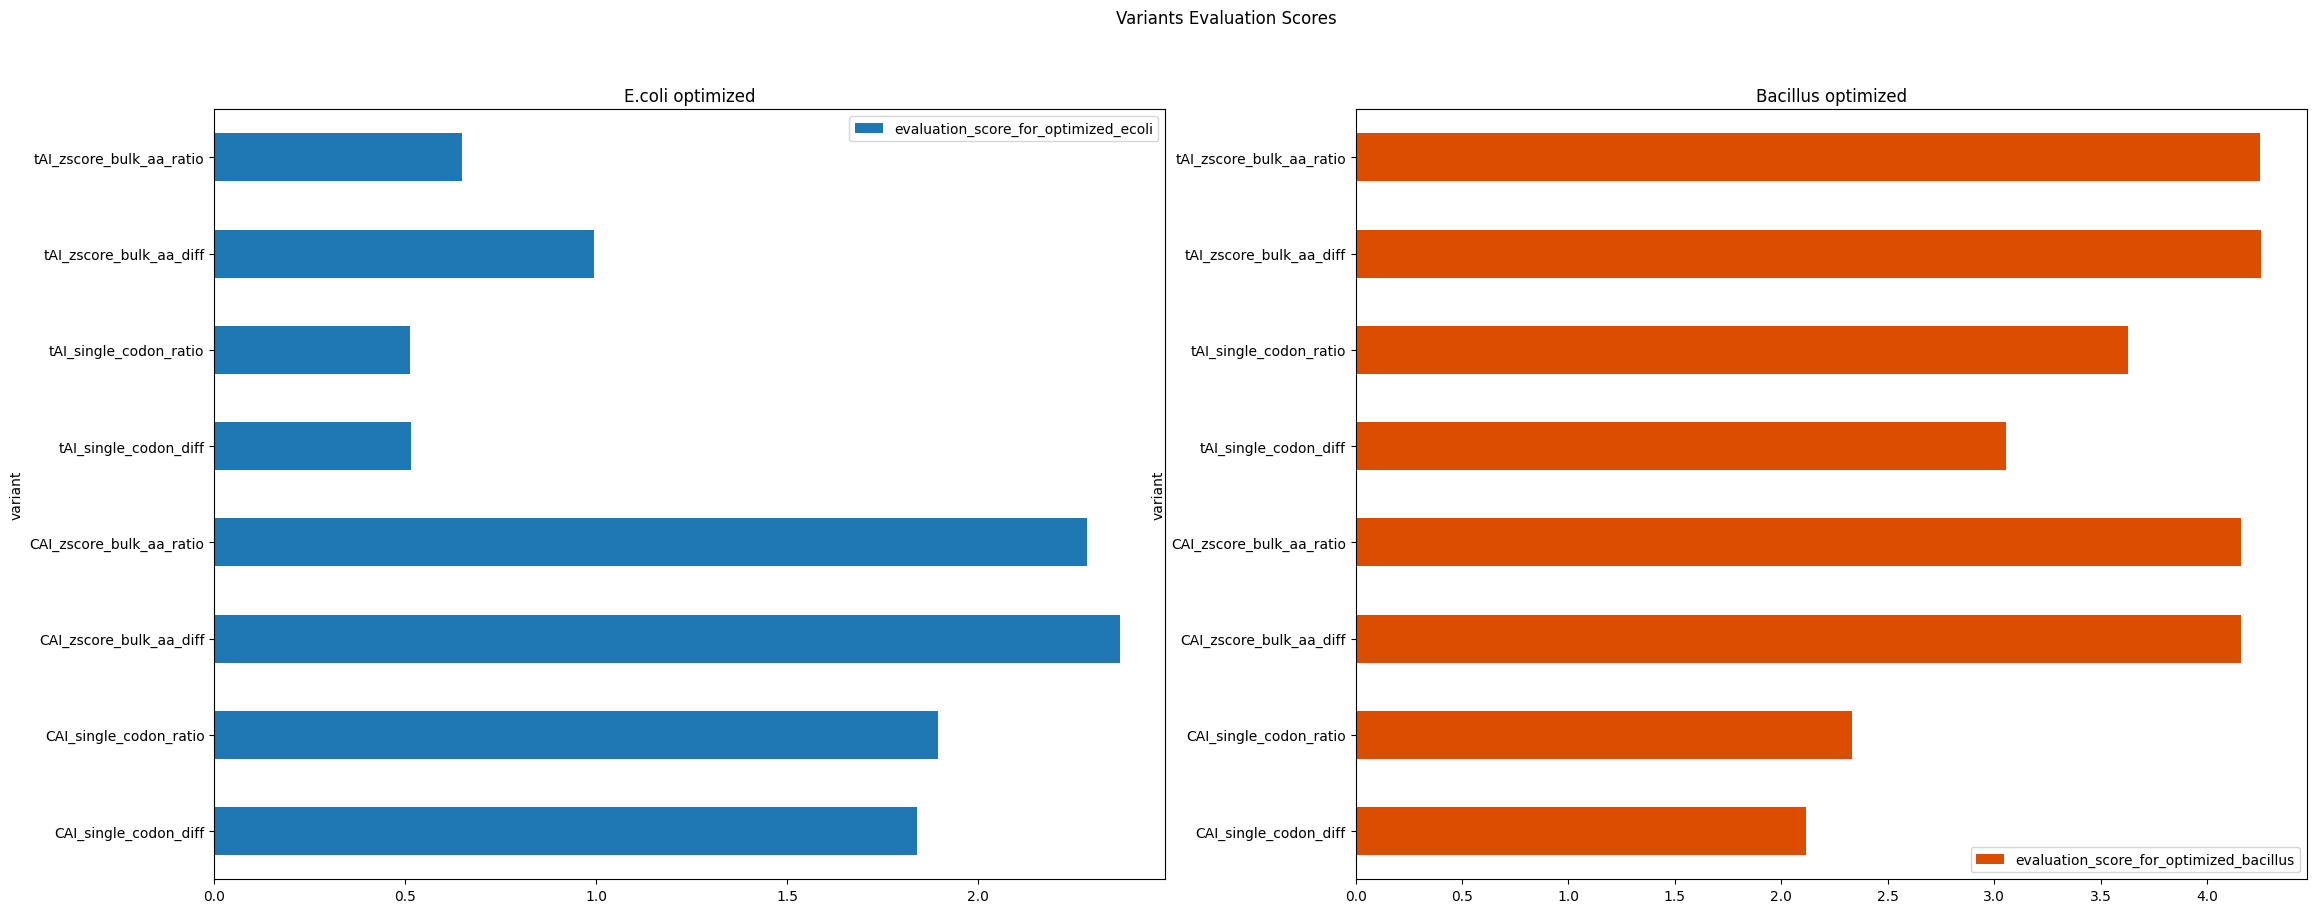

In [71]:
fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(27,10))

fig.suptitle("Variants Evaluation Scores")
evaluation_ecoli_opt_variants_dataframe.plot("variant", kind="barh", ax=axes[0], title="E.coli optimized")
evaluation_bacillus_opt_variants_dataframe.plot("variant", kind="barh", ax=axes[1], title="Bacillus optimized", color="#dc4d01")

Text(0.7, 0.9, 'r = -0.258')

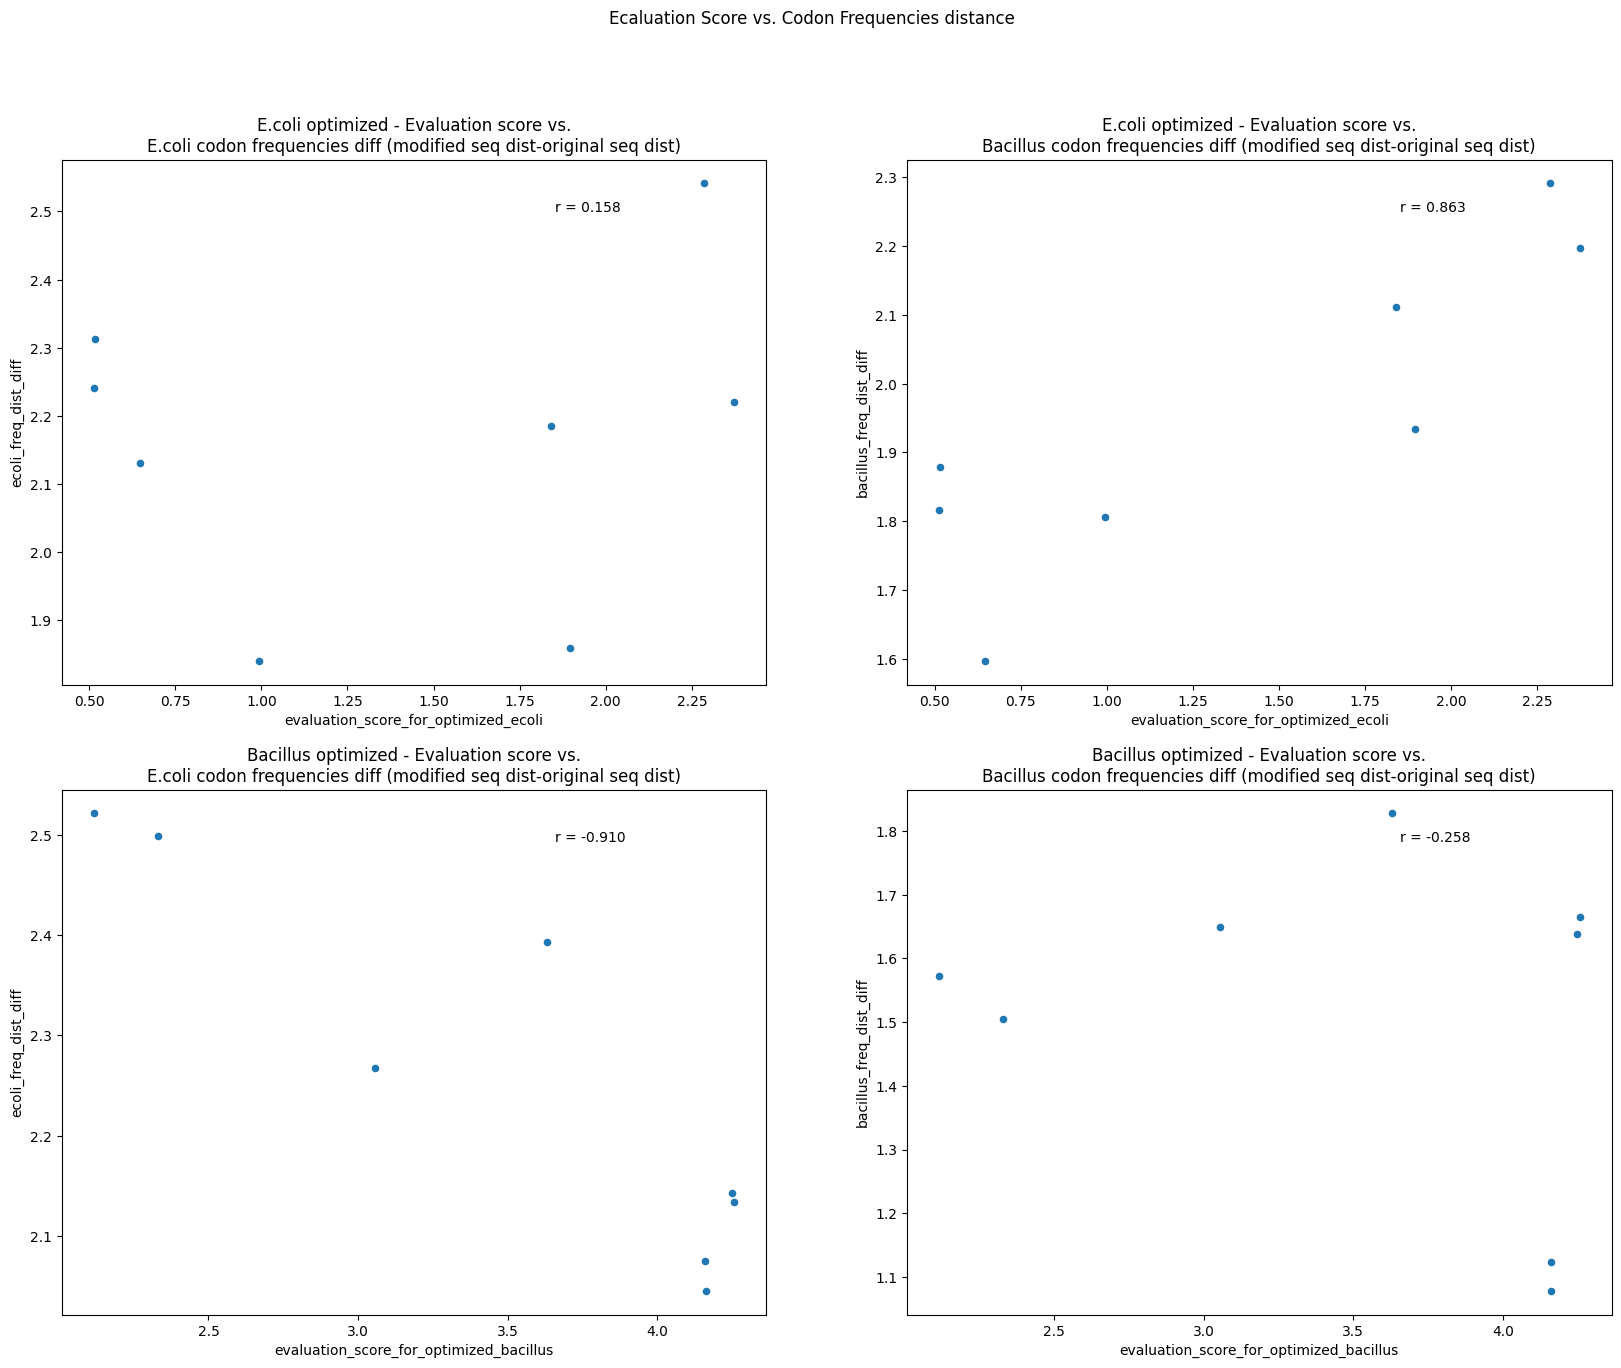

In [72]:
merged_df_ecoli = pd.merge(evaluation_ecoli_opt_variants_dataframe, ecoli_opt_variants_dataframe, on='variant', how='inner')
merged_df_ecoli['ecoli_freq_dist_diff'] =  merged_df_ecoli['ecoli_dist_for_optimized_ecoli'] - merged_df_ecoli['ecoli_dist_for_original_mcherry']
merged_df_ecoli['bacillus_freq_dist_diff'] = merged_df_ecoli['bacillus_dist_for_optimized_ecoli'] - merged_df_ecoli['bacillus_dist_for_original_mcherry']

merged_df_bacillus = pd.merge(evaluation_bacillus_opt_variants_dataframe, bacillus_opt_variants_dataframe, on='variant', how='inner')
merged_df_bacillus['ecoli_freq_dist_diff'] =  merged_df_bacillus['ecoli_dist_for_optimized_bacillus'] - merged_df_bacillus['ecoli_dist_for_original_mcherry']
merged_df_bacillus['bacillus_freq_dist_diff'] = merged_df_bacillus['bacillus_dist_for_optimized_bacillus'] - merged_df_bacillus['bacillus_dist_for_original_mcherry'] 


fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(20,15))
fig.suptitle("Ecaluation Score vs. Codon Frequencies distance")

scatter = merged_df_ecoli.plot.scatter(x="evaluation_score_for_optimized_ecoli", y="ecoli_freq_dist_diff", ax=axes[0,0], title="E.coli optimized - Evaluation score vs.\nE.coli codon frequencies diff (modified seq dist-original seq dist)")
r, p = stats.pearsonr(merged_df_ecoli["evaluation_score_for_optimized_ecoli"], merged_df_ecoli["ecoli_freq_dist_diff"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = merged_df_ecoli.plot.scatter(x="evaluation_score_for_optimized_ecoli", y="bacillus_freq_dist_diff", ax=axes[0,1], title="E.coli optimized - Evaluation score vs.\nBacillus codon frequencies diff (modified seq dist-original seq dist)")
r, p = stats.pearsonr(merged_df_ecoli["evaluation_score_for_optimized_ecoli"], merged_df_ecoli["bacillus_freq_dist_diff"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = merged_df_bacillus.plot.scatter(x="evaluation_score_for_optimized_bacillus", y="ecoli_freq_dist_diff", ax=axes[1,0], title="Bacillus optimized - Evaluation score vs.\nE.coli codon frequencies diff (modified seq dist-original seq dist)")
r, p = stats.pearsonr(merged_df_bacillus["evaluation_score_for_optimized_bacillus"], merged_df_bacillus["ecoli_freq_dist_diff"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = merged_df_bacillus.plot.scatter(x="evaluation_score_for_optimized_bacillus", y="bacillus_freq_dist_diff", ax=axes[1,1], title="Bacillus optimized - Evaluation score vs.\nBacillus codon frequencies diff (modified seq dist-original seq dist)")
r, p = stats.pearsonr(merged_df_bacillus["evaluation_score_for_optimized_bacillus"], merged_df_bacillus["bacillus_freq_dist_diff"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

Text(0.7, 0.9, 'r = 0.989')

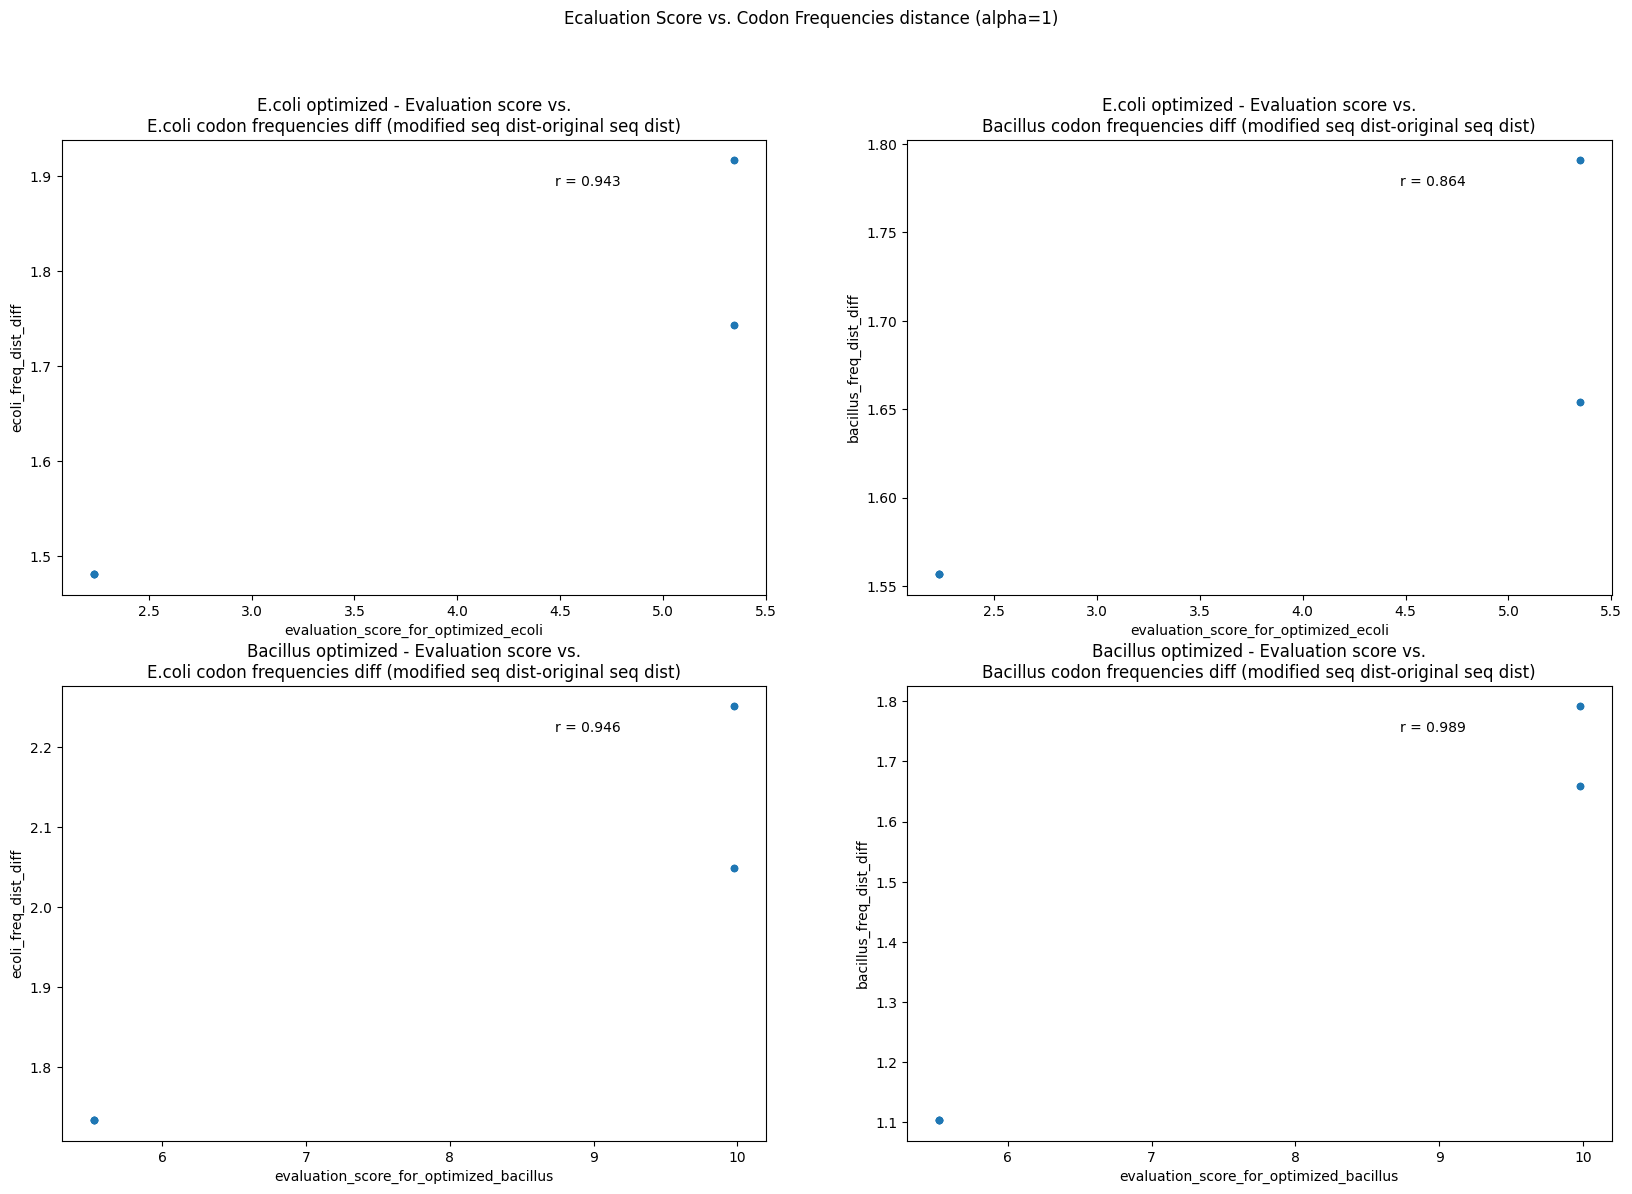

In [73]:
merged_df_ecoli = pd.merge(evaluation_ecoli_opt_greater_alpha_variants_dataframe, greater_alpha_ecoli_opt_variants_dataframe, on='variant', how='inner')
merged_df_ecoli['ecoli_freq_dist_diff'] =  merged_df_ecoli['ecoli_dist_for_optimized_ecoli'] - merged_df_ecoli['ecoli_dist_for_original_mcherry']
merged_df_ecoli['bacillus_freq_dist_diff'] = merged_df_ecoli['bacillus_dist_for_optimized_ecoli'] - merged_df_ecoli['bacillus_dist_for_original_mcherry']

merged_df_bacillus = pd.merge(evaluation_bacillus_opt_greater_alpha_variants_dataframe, greater_alpha_bacillus_opt_variants_dataframe, on='variant', how='inner')
merged_df_bacillus['ecoli_freq_dist_diff'] =  merged_df_bacillus['ecoli_dist_for_optimized_bacillus'] - merged_df_bacillus['ecoli_dist_for_original_mcherry']
merged_df_bacillus['bacillus_freq_dist_diff'] = merged_df_bacillus['bacillus_dist_for_optimized_bacillus'] - merged_df_bacillus['bacillus_dist_for_original_mcherry'] 


fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(20,13))
fig.suptitle("Ecaluation Score vs. Codon Frequencies distance (alpha=1)")

scatter = merged_df_ecoli.plot.scatter(x="evaluation_score_for_optimized_ecoli", y="ecoli_freq_dist_diff", ax=axes[0,0], title="E.coli optimized - Evaluation score vs.\nE.coli codon frequencies diff (modified seq dist-original seq dist)")
r, p = stats.pearsonr(merged_df_ecoli["evaluation_score_for_optimized_ecoli"], merged_df_ecoli["ecoli_freq_dist_diff"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = merged_df_ecoli.plot.scatter(x="evaluation_score_for_optimized_ecoli", y="bacillus_freq_dist_diff", ax=axes[0,1], title="E.coli optimized - Evaluation score vs.\nBacillus codon frequencies diff (modified seq dist-original seq dist)")
r, p = stats.pearsonr(merged_df_ecoli["evaluation_score_for_optimized_ecoli"], merged_df_ecoli["bacillus_freq_dist_diff"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = merged_df_bacillus.plot.scatter(x="evaluation_score_for_optimized_bacillus", y="ecoli_freq_dist_diff", ax=axes[1,0], title="Bacillus optimized - Evaluation score vs.\nE.coli codon frequencies diff (modified seq dist-original seq dist)")
r, p = stats.pearsonr(merged_df_bacillus["evaluation_score_for_optimized_bacillus"], merged_df_bacillus["ecoli_freq_dist_diff"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = merged_df_bacillus.plot.scatter(x="evaluation_score_for_optimized_bacillus", y="bacillus_freq_dist_diff", ax=axes[1,1], title="Bacillus optimized - Evaluation score vs.\nBacillus codon frequencies diff (modified seq dist-original seq dist)")
r, p = stats.pearsonr(merged_df_bacillus["evaluation_score_for_optimized_bacillus"], merged_df_bacillus["bacillus_freq_dist_diff"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

Text(0.7, 0.9, 'r = -0.854')

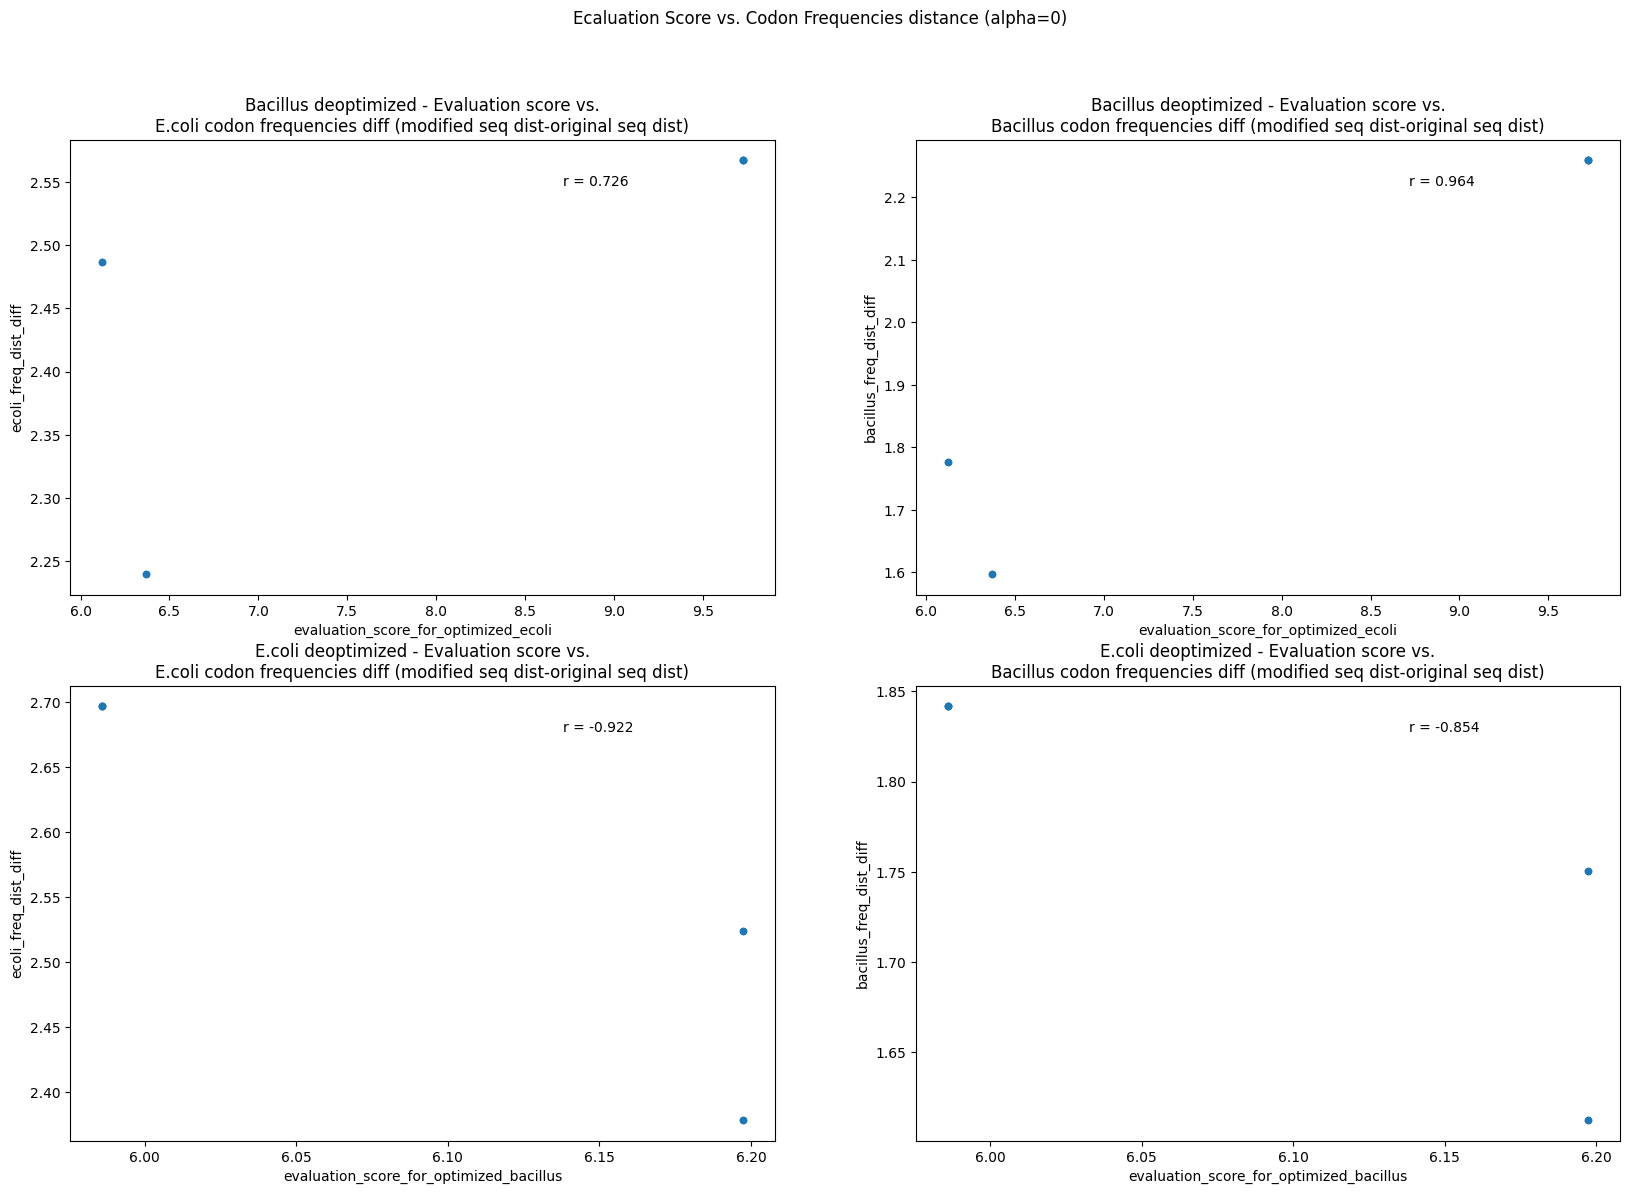

In [74]:
merged_df_ecoli = pd.merge(evaluation_ecoli_opt_lower_alpha_variants_dataframe, lower_alpha_ecoli_opt_variants_dataframe, on='variant', how='inner')
merged_df_ecoli['ecoli_freq_dist_diff'] =  merged_df_ecoli['ecoli_dist_for_optimized_ecoli'] - merged_df_ecoli['ecoli_dist_for_original_mcherry']
merged_df_ecoli['bacillus_freq_dist_diff'] = merged_df_ecoli['bacillus_dist_for_optimized_ecoli'] - merged_df_ecoli['bacillus_dist_for_original_mcherry']

merged_df_bacillus = pd.merge(evaluation_bacillus_opt_lower_alpha_variants_dataframe, lower_alpha_bacillus_opt_variants_dataframe, on='variant', how='inner')
merged_df_bacillus['ecoli_freq_dist_diff'] =  merged_df_bacillus['ecoli_dist_for_optimized_bacillus'] - merged_df_bacillus['ecoli_dist_for_original_mcherry']
merged_df_bacillus['bacillus_freq_dist_diff'] = merged_df_bacillus['bacillus_dist_for_optimized_bacillus'] - merged_df_bacillus['bacillus_dist_for_original_mcherry'] 


fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(20,13))
fig.suptitle("Ecaluation Score vs. Codon Frequencies distance (alpha=0)")

scatter = merged_df_ecoli.plot.scatter(x="evaluation_score_for_optimized_ecoli", y="ecoli_freq_dist_diff", ax=axes[0,0], title="Bacillus deoptimized - Evaluation score vs.\nE.coli codon frequencies diff (modified seq dist-original seq dist)")
r, p = stats.pearsonr(merged_df_ecoli["evaluation_score_for_optimized_ecoli"], merged_df_ecoli["ecoli_freq_dist_diff"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = merged_df_ecoli.plot.scatter(x="evaluation_score_for_optimized_ecoli", y="bacillus_freq_dist_diff", ax=axes[0,1], title="Bacillus deoptimized - Evaluation score vs.\nBacillus codon frequencies diff (modified seq dist-original seq dist)")
r, p = stats.pearsonr(merged_df_ecoli["evaluation_score_for_optimized_ecoli"], merged_df_ecoli["bacillus_freq_dist_diff"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = merged_df_bacillus.plot.scatter(x="evaluation_score_for_optimized_bacillus", y="ecoli_freq_dist_diff", ax=axes[1,0], title="E.coli deoptimized - Evaluation score vs.\nE.coli codon frequencies diff (modified seq dist-original seq dist)")
r, p = stats.pearsonr(merged_df_bacillus["evaluation_score_for_optimized_bacillus"], merged_df_bacillus["ecoli_freq_dist_diff"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = merged_df_bacillus.plot.scatter(x="evaluation_score_for_optimized_bacillus", y="bacillus_freq_dist_diff", ax=axes[1,1], title="E.coli deoptimized - Evaluation score vs.\nBacillus codon frequencies diff (modified seq dist-original seq dist)")
r, p = stats.pearsonr(merged_df_bacillus["evaluation_score_for_optimized_bacillus"], merged_df_bacillus["bacillus_freq_dist_diff"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

Text(0.7, 0.9, 'r = 1.000')

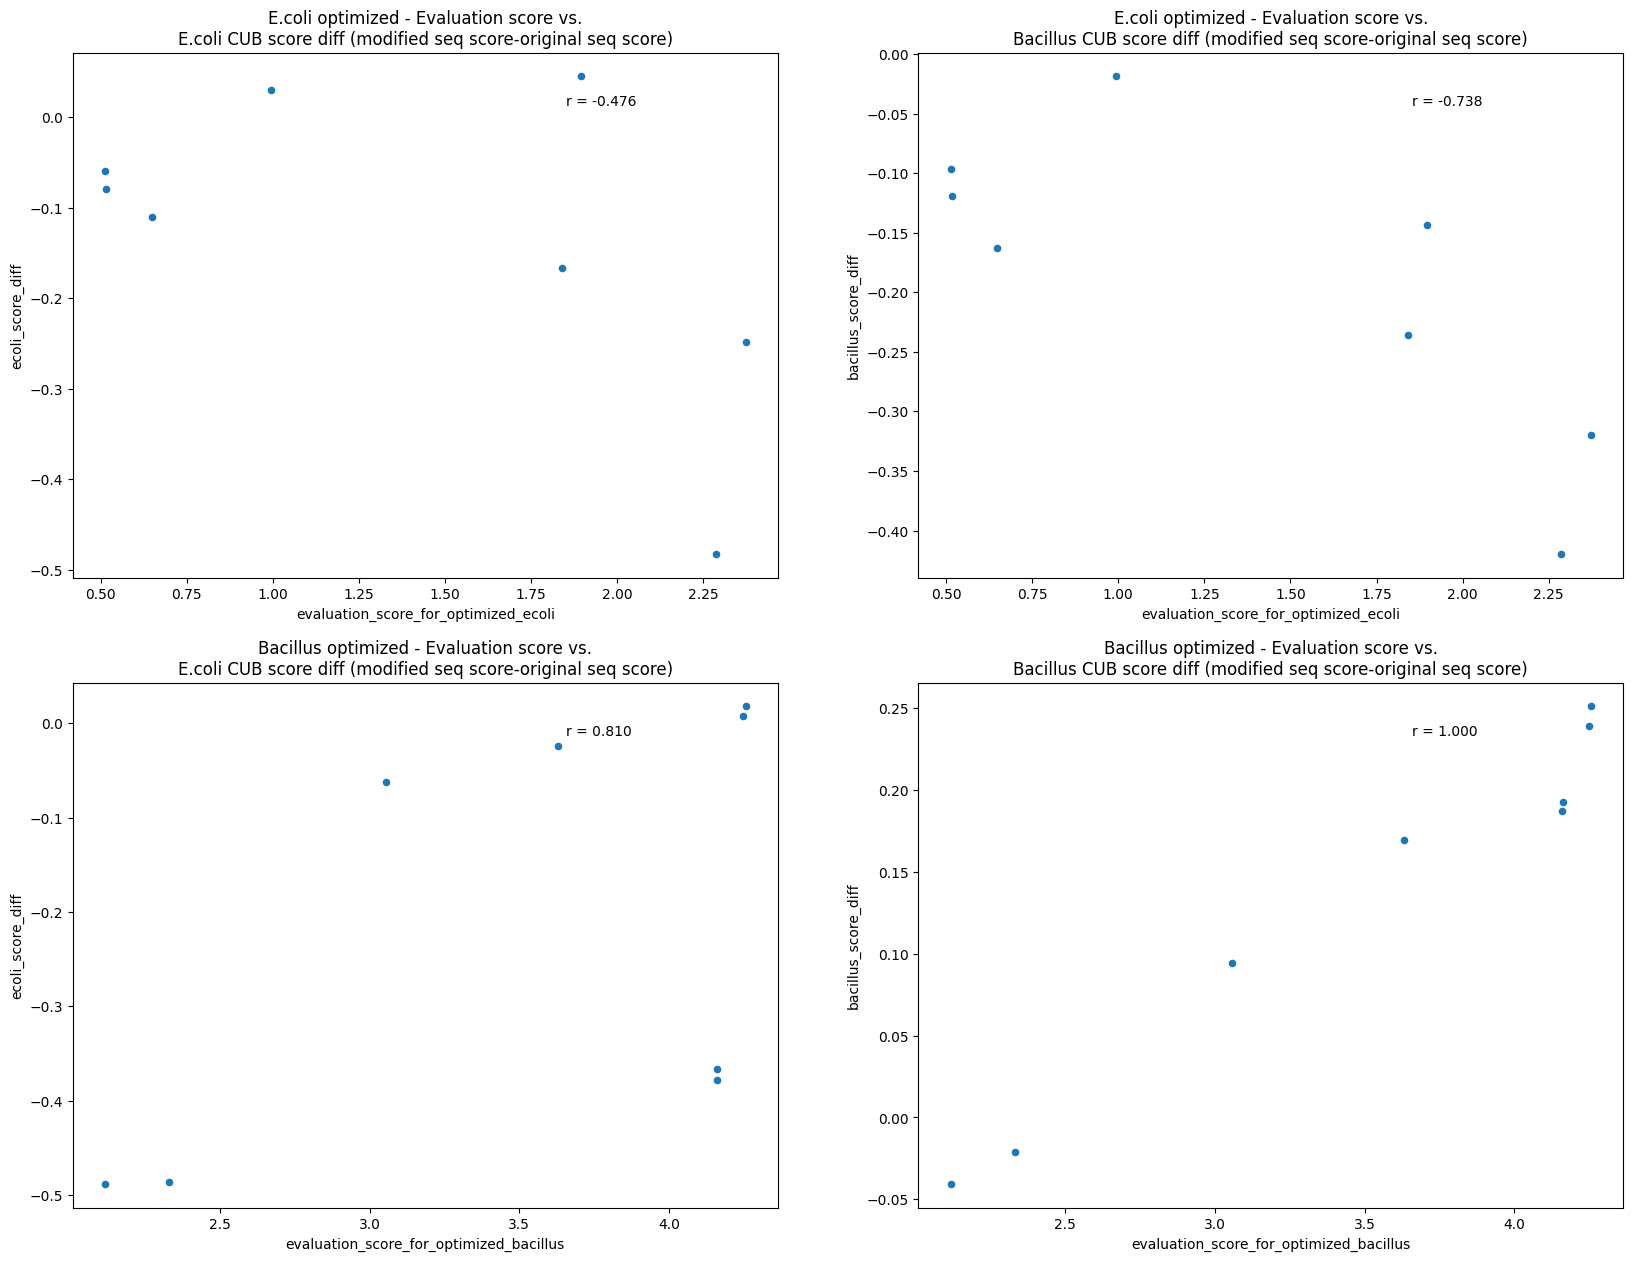

In [75]:
merged_df_ecoli = pd.merge(evaluation_ecoli_opt_variants_dataframe, cub_ecoli_opt_variants_dataframe, on='variant', how='inner')
merged_df_ecoli['ecoli_score_diff'] = merged_df_ecoli['ecoli_final_score'] - merged_df_ecoli['ecoli_initial_score']
merged_df_ecoli['bacillus_score_diff'] = merged_df_ecoli['bacillus_final_score'] - merged_df_ecoli['bacillus_initial_score']

merged_df_bacillus = pd.merge(evaluation_bacillus_opt_variants_dataframe, cub_bacillus_opt_variants_dataframe, on='variant', how='inner')
merged_df_bacillus['ecoli_score_diff'] = merged_df_bacillus['ecoli_final_score'] - merged_df_bacillus['ecoli_initial_score']
merged_df_bacillus['bacillus_score_diff'] = merged_df_bacillus['bacillus_final_score'] - merged_df_bacillus['bacillus_initial_score']

fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(20,15))

scatter = merged_df_ecoli.plot.scatter(x="evaluation_score_for_optimized_ecoli", y="ecoli_score_diff", ax=axes[0,0], title="E.coli optimized - Evaluation score vs.\nE.coli CUB score diff (modified seq score-original seq score)")
r, p = stats.spearmanr(merged_df_ecoli["evaluation_score_for_optimized_ecoli"], merged_df_ecoli["ecoli_score_diff"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = merged_df_ecoli.plot.scatter(x="evaluation_score_for_optimized_ecoli", y="bacillus_score_diff", ax=axes[0,1], title="E.coli optimized - Evaluation score vs.\nBacillus CUB score diff (modified seq score-original seq score)")
r, p = stats.spearmanr(merged_df_ecoli["evaluation_score_for_optimized_ecoli"], merged_df_ecoli["bacillus_score_diff"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = merged_df_bacillus.plot.scatter(x="evaluation_score_for_optimized_bacillus", y="ecoli_score_diff", ax=axes[1,0], title="Bacillus optimized - Evaluation score vs.\nE.coli CUB score diff (modified seq score-original seq score)")
r, p = stats.spearmanr(merged_df_bacillus["evaluation_score_for_optimized_bacillus"], merged_df_bacillus["ecoli_score_diff"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = merged_df_bacillus.plot.scatter(x="evaluation_score_for_optimized_bacillus", y="bacillus_score_diff", ax=axes[1,1], title="Bacillus optimized - Evaluation score vs.\nBacillus CUB score diff (modified seq score-original seq score)")
r, p = stats.spearmanr(merged_df_bacillus["evaluation_score_for_optimized_bacillus"], merged_df_bacillus["bacillus_score_diff"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

Text(0.7, 0.9, 'r = 1.000')

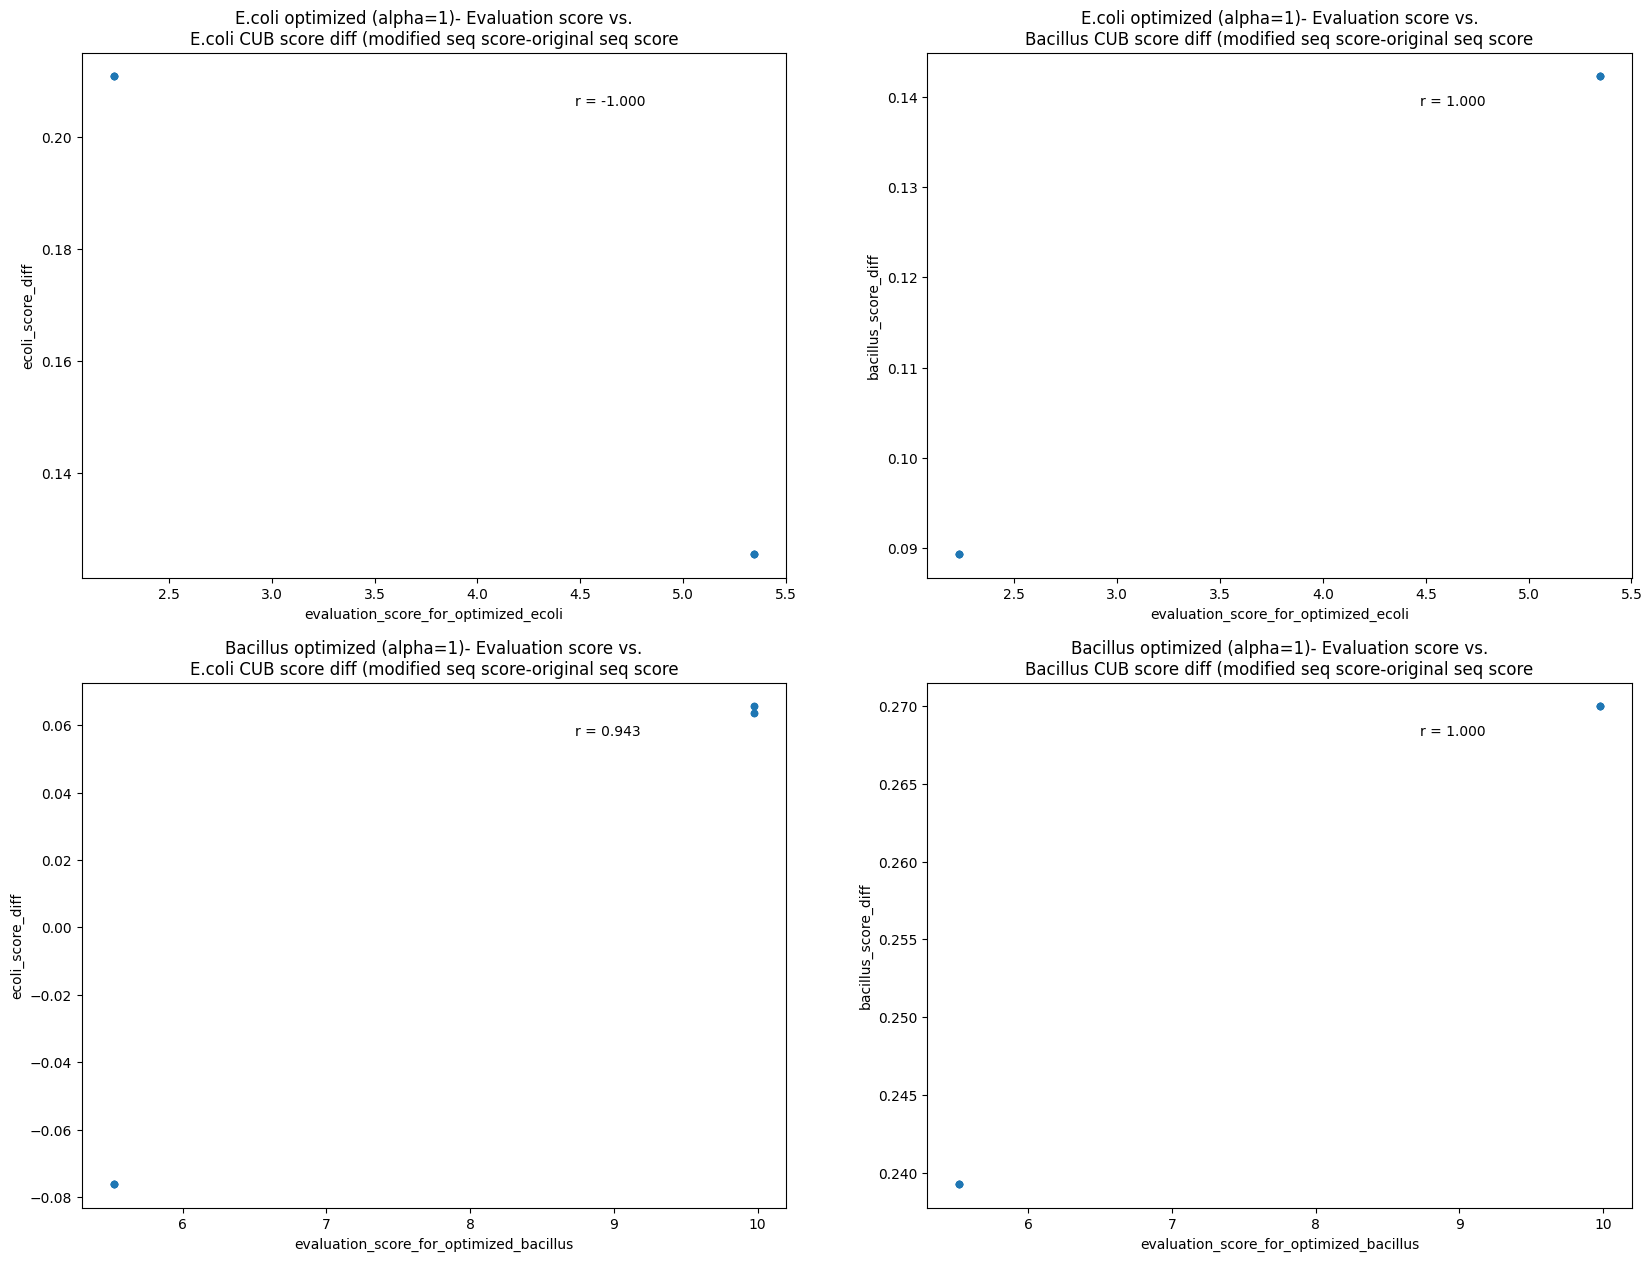

In [76]:
merged_df_ecoli_greater_alpha = pd.merge(evaluation_ecoli_opt_greater_alpha_variants_dataframe, cub_ecoli_opt_greater_alpha_variants_dataframe, on='variant', how='inner')
merged_df_ecoli_greater_alpha['ecoli_score_diff'] = merged_df_ecoli_greater_alpha['ecoli_final_score'] - merged_df_ecoli_greater_alpha['ecoli_initial_score']
merged_df_ecoli_greater_alpha['bacillus_score_diff'] = merged_df_ecoli_greater_alpha['bacillus_final_score'] - merged_df_ecoli_greater_alpha['bacillus_initial_score']

merged_df_bacillus_greater_alpha = pd.merge(evaluation_bacillus_opt_greater_alpha_variants_dataframe, cub_bacillus_opt_greater_alpha_variants_dataframe, on='variant', how='inner')
merged_df_bacillus_greater_alpha['ecoli_score_diff'] = merged_df_bacillus_greater_alpha['ecoli_final_score'] - merged_df_bacillus_greater_alpha['ecoli_initial_score']
merged_df_bacillus_greater_alpha['bacillus_score_diff'] = merged_df_bacillus_greater_alpha['bacillus_final_score'] - merged_df_bacillus_greater_alpha['bacillus_initial_score']

fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(20,15))

scatter = merged_df_ecoli_greater_alpha.plot.scatter(x="evaluation_score_for_optimized_ecoli", y="ecoli_score_diff", ax=axes[0,0], title="E.coli optimized (alpha=1)- Evaluation score vs.\nE.coli CUB score diff (modified seq score-original seq score")
r, p = stats.spearmanr(merged_df_ecoli_greater_alpha["evaluation_score_for_optimized_ecoli"], merged_df_ecoli_greater_alpha["ecoli_score_diff"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = merged_df_ecoli_greater_alpha.plot.scatter(x="evaluation_score_for_optimized_ecoli", y="bacillus_score_diff", ax=axes[0,1], title="E.coli optimized (alpha=1)- Evaluation score vs.\nBacillus CUB score diff (modified seq score-original seq score")
r, p = stats.spearmanr(merged_df_ecoli_greater_alpha["evaluation_score_for_optimized_ecoli"], merged_df_ecoli_greater_alpha["bacillus_score_diff"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = merged_df_bacillus_greater_alpha.plot.scatter(x="evaluation_score_for_optimized_bacillus", y="ecoli_score_diff", ax=axes[1,0], title="Bacillus optimized (alpha=1)- Evaluation score vs.\nE.coli CUB score diff (modified seq score-original seq score")
r, p = stats.spearmanr(merged_df_bacillus_greater_alpha["evaluation_score_for_optimized_bacillus"], merged_df_bacillus_greater_alpha["ecoli_score_diff"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = merged_df_bacillus_greater_alpha.plot.scatter(x="evaluation_score_for_optimized_bacillus", y="bacillus_score_diff", ax=axes[1,1], title="Bacillus optimized (alpha=1)- Evaluation score vs.\nBacillus CUB score diff (modified seq score-original seq score")
r, p = stats.spearmanr(merged_df_bacillus_greater_alpha["evaluation_score_for_optimized_bacillus"], merged_df_bacillus_greater_alpha["bacillus_score_diff"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

Text(0.7, 0.9, 'r = 1.000')

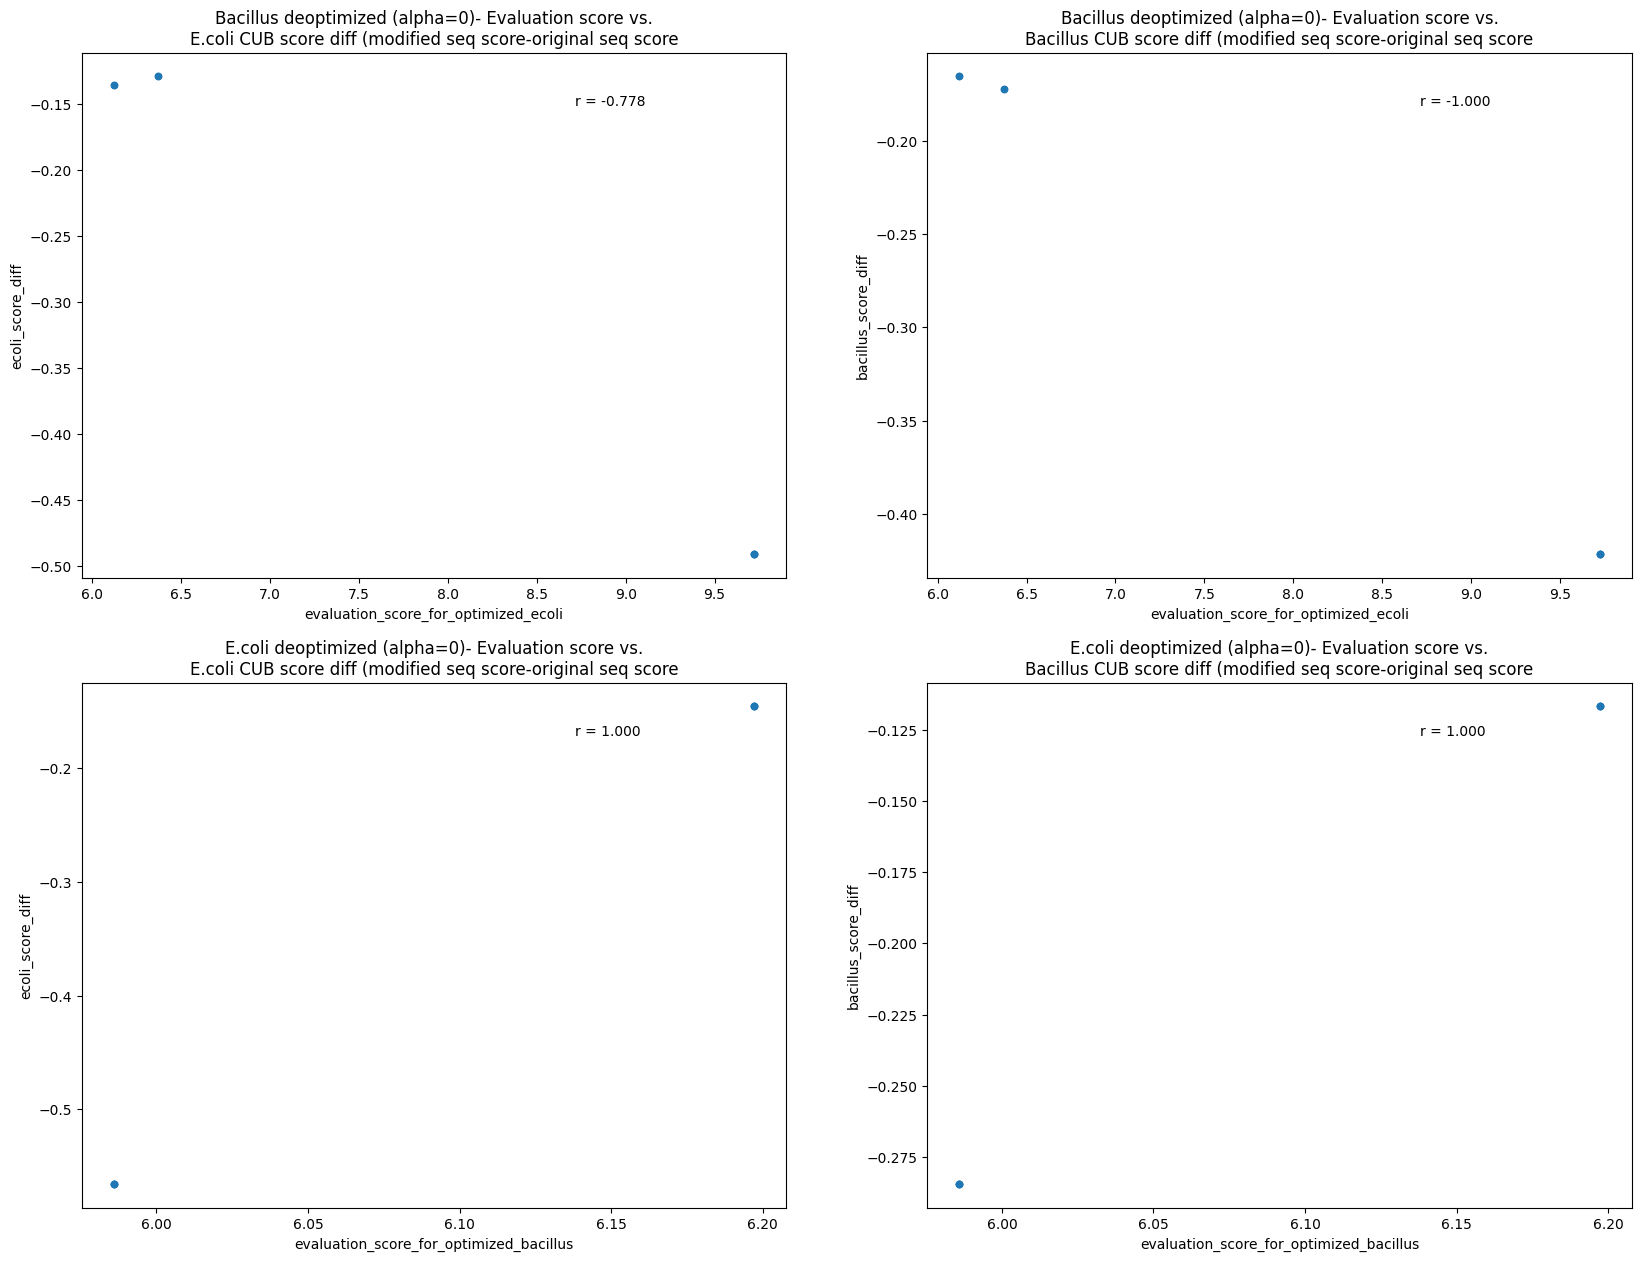

In [77]:
merged_df_ecoli_lower_alpha = pd.merge(evaluation_ecoli_opt_lower_alpha_variants_dataframe, cub_ecoli_opt_lower_alpha_variants_dataframe, on='variant', how='inner')
merged_df_ecoli_lower_alpha['ecoli_score_diff'] = merged_df_ecoli_lower_alpha['ecoli_final_score'] - merged_df_ecoli_lower_alpha['ecoli_initial_score']
merged_df_ecoli_lower_alpha['bacillus_score_diff'] = merged_df_ecoli_lower_alpha['bacillus_final_score'] - merged_df_ecoli_lower_alpha['bacillus_initial_score']

merged_df_bacillus_lower_alpha = pd.merge(evaluation_bacillus_opt_lower_alpha_variants_dataframe, cub_bacillus_opt_lower_alpha_variants_dataframe, on='variant', how='inner')
merged_df_bacillus_lower_alpha['ecoli_score_diff'] = merged_df_bacillus_lower_alpha['ecoli_final_score'] - merged_df_bacillus_lower_alpha['ecoli_initial_score']
merged_df_bacillus_lower_alpha['bacillus_score_diff'] = merged_df_bacillus_lower_alpha['bacillus_final_score'] - merged_df_bacillus_lower_alpha['bacillus_initial_score']

fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(20,15))

scatter = merged_df_ecoli_lower_alpha.plot.scatter(x="evaluation_score_for_optimized_ecoli", y="ecoli_score_diff", ax=axes[0,0], title="Bacillus deoptimized (alpha=0)- Evaluation score vs.\nE.coli CUB score diff (modified seq score-original seq score")
r, p = stats.spearmanr(merged_df_ecoli_lower_alpha["evaluation_score_for_optimized_ecoli"], merged_df_ecoli_lower_alpha["ecoli_score_diff"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = merged_df_ecoli_lower_alpha.plot.scatter(x="evaluation_score_for_optimized_ecoli", y="bacillus_score_diff", ax=axes[0,1], title="Bacillus deoptimized (alpha=0)- Evaluation score vs.\nBacillus CUB score diff (modified seq score-original seq score")
r, p = stats.spearmanr(merged_df_ecoli_lower_alpha["evaluation_score_for_optimized_ecoli"], merged_df_ecoli_lower_alpha["bacillus_score_diff"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = merged_df_bacillus_lower_alpha.plot.scatter(x="evaluation_score_for_optimized_bacillus", y="ecoli_score_diff", ax=axes[1,0], title="E.coli deoptimized (alpha=0)- Evaluation score vs.\nE.coli CUB score diff (modified seq score-original seq score")
r, p = stats.spearmanr(merged_df_bacillus_lower_alpha["evaluation_score_for_optimized_bacillus"], merged_df_bacillus_lower_alpha["ecoli_score_diff"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = merged_df_bacillus_lower_alpha.plot.scatter(x="evaluation_score_for_optimized_bacillus", y="bacillus_score_diff", ax=axes[1,1], title="E.coli deoptimized (alpha=0)- Evaluation score vs.\nBacillus CUB score diff (modified seq score-original seq score")
r, p = stats.spearmanr(merged_df_bacillus_lower_alpha["evaluation_score_for_optimized_bacillus"], merged_df_bacillus_lower_alpha["bacillus_score_diff"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

C:\projects\Igem_TAU_2021_moran\venv\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


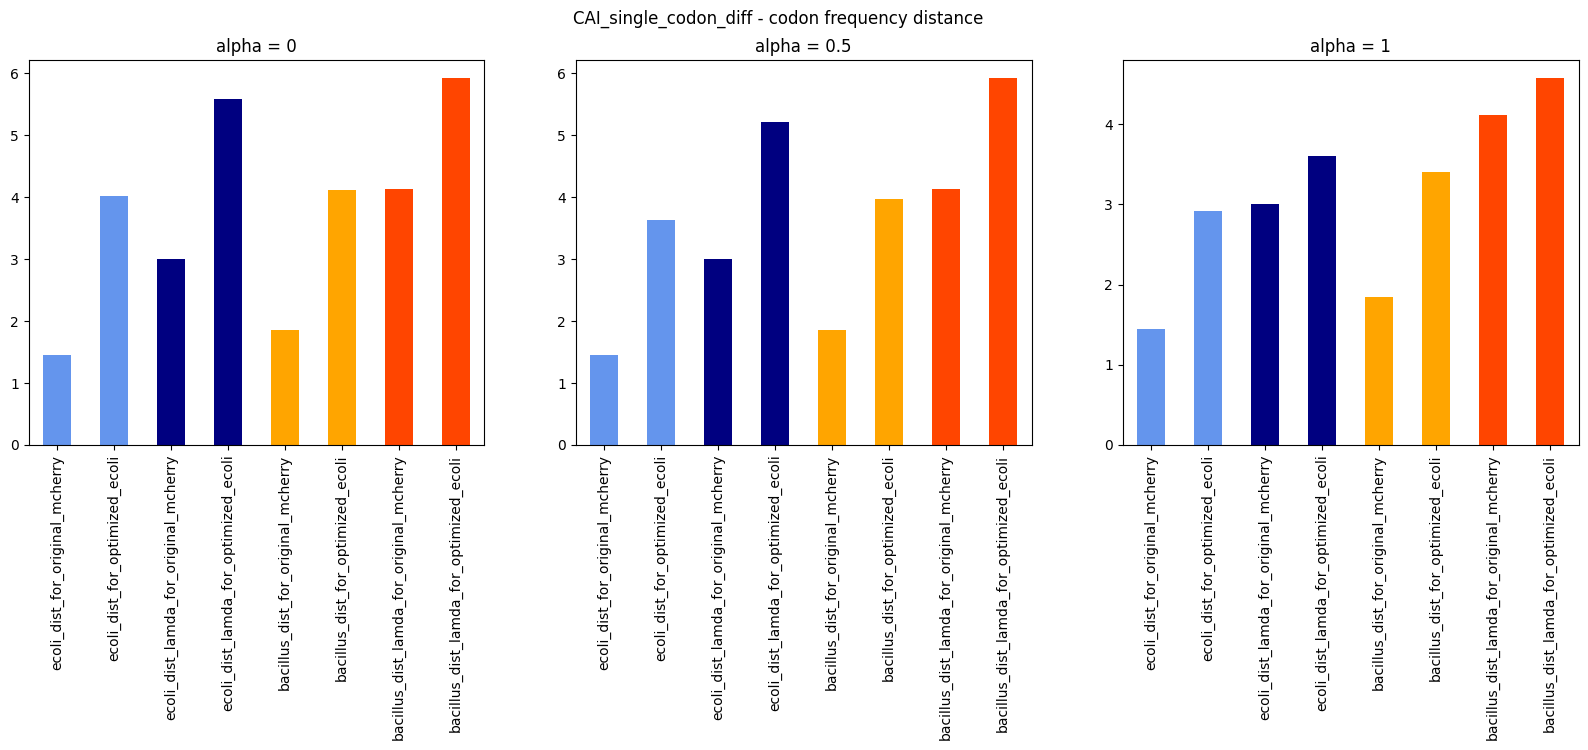

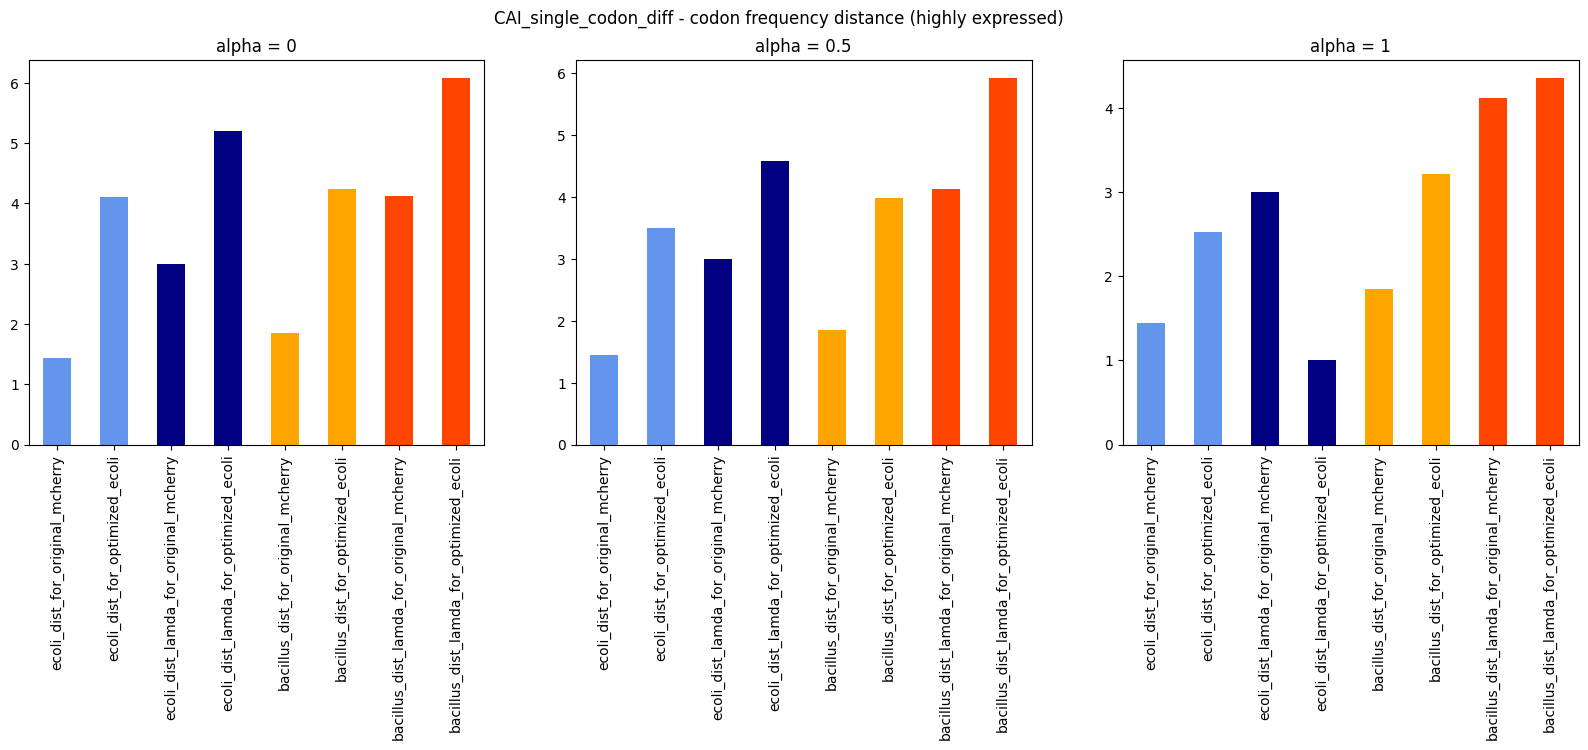

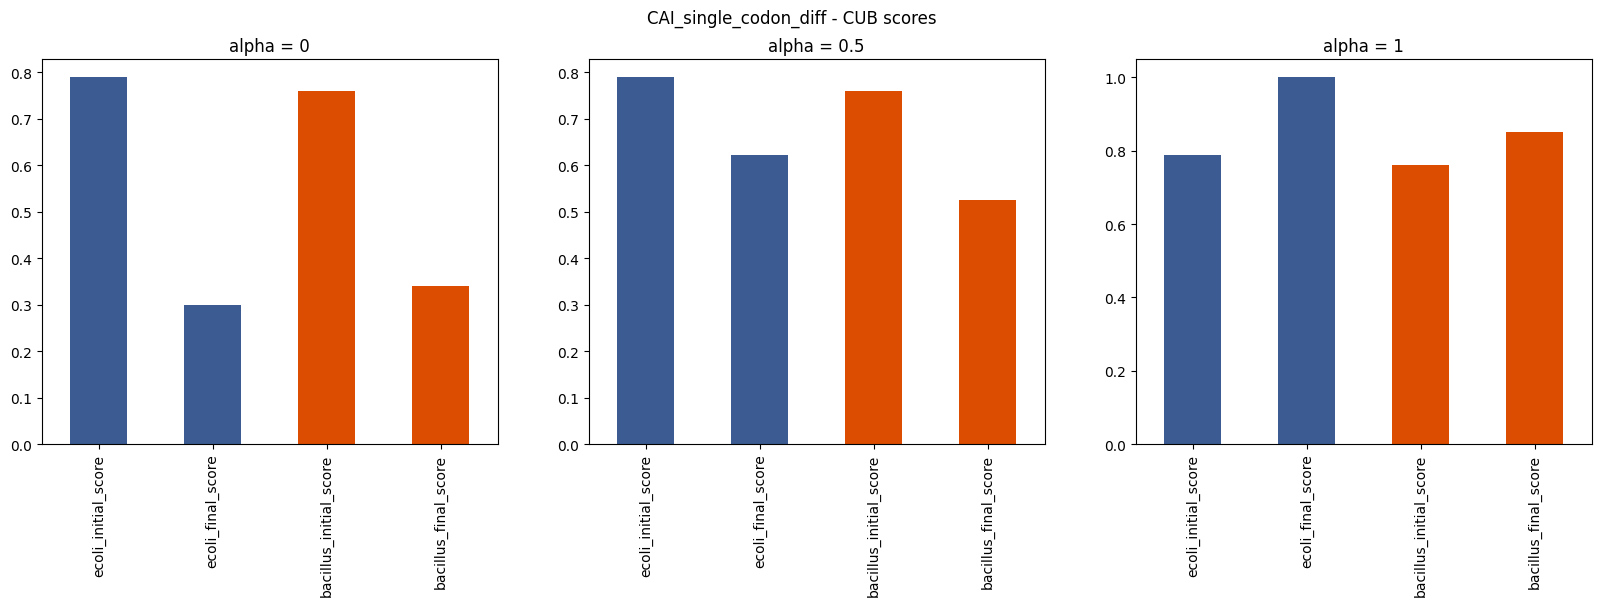

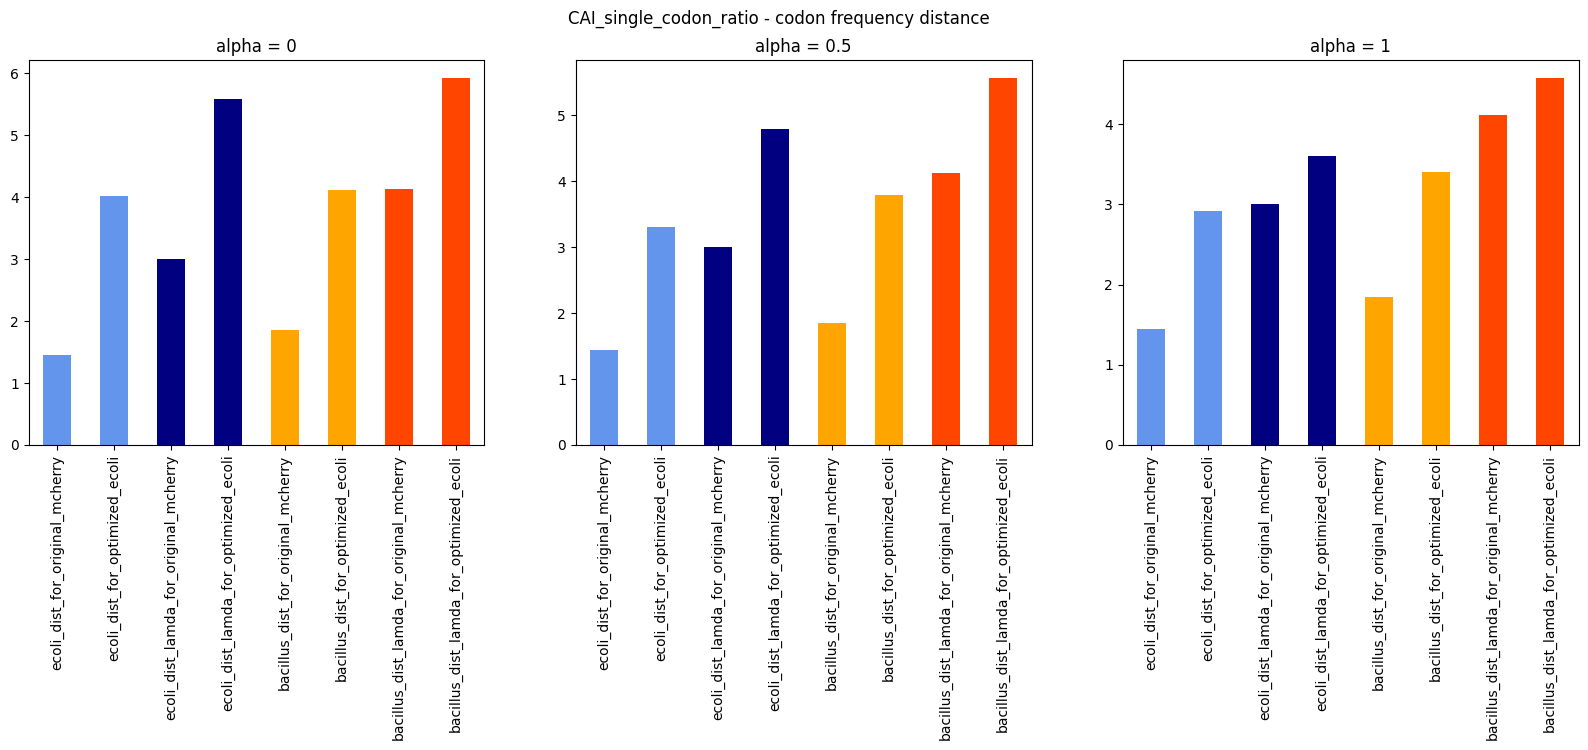

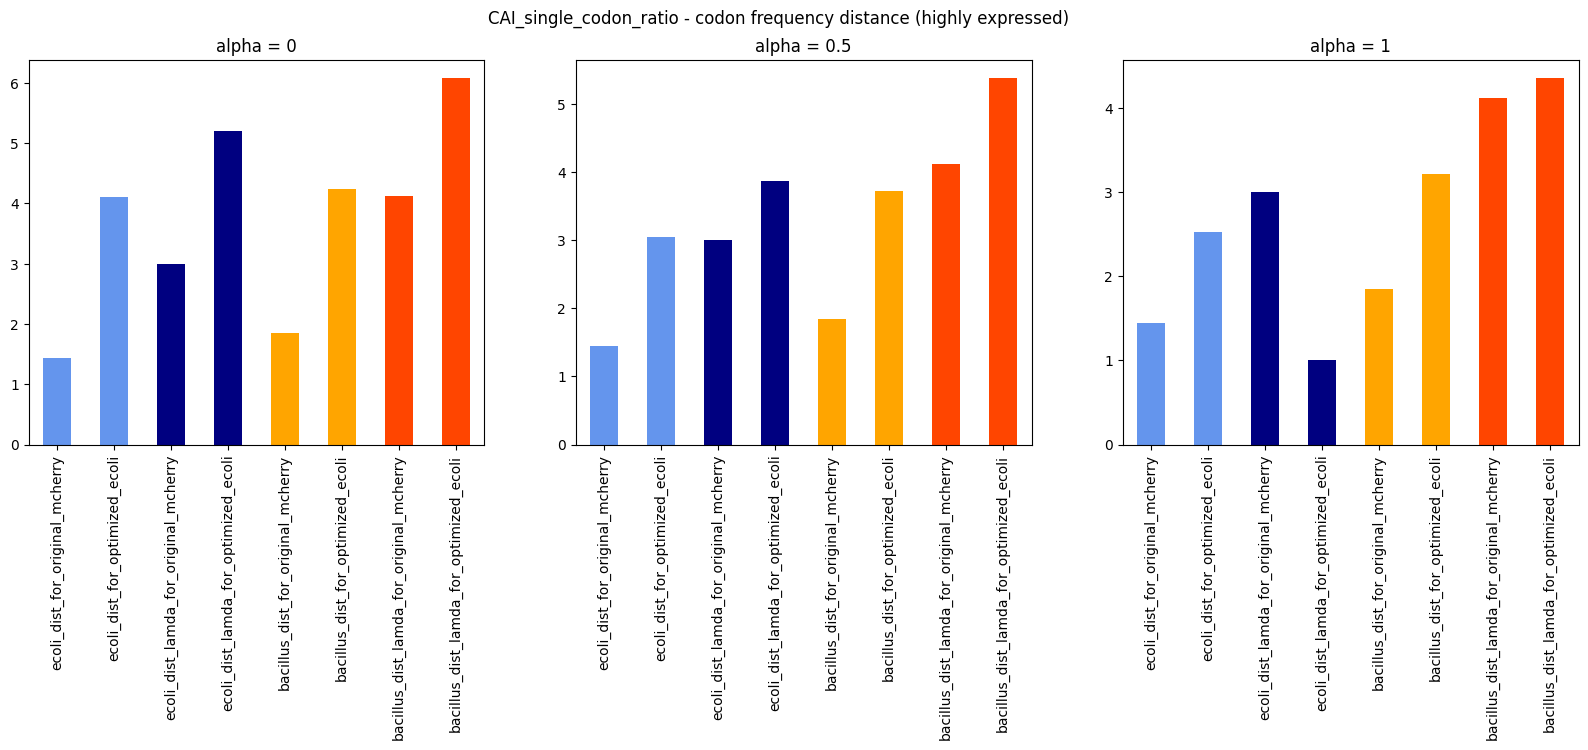

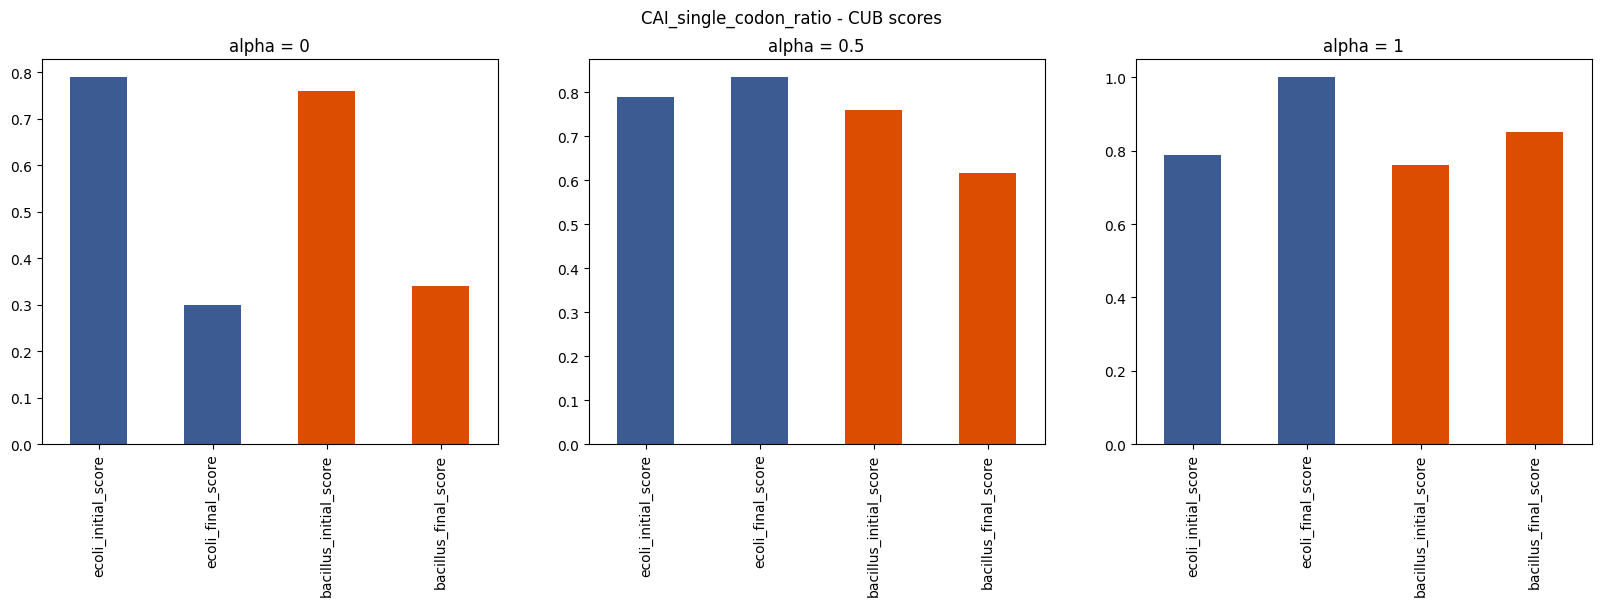

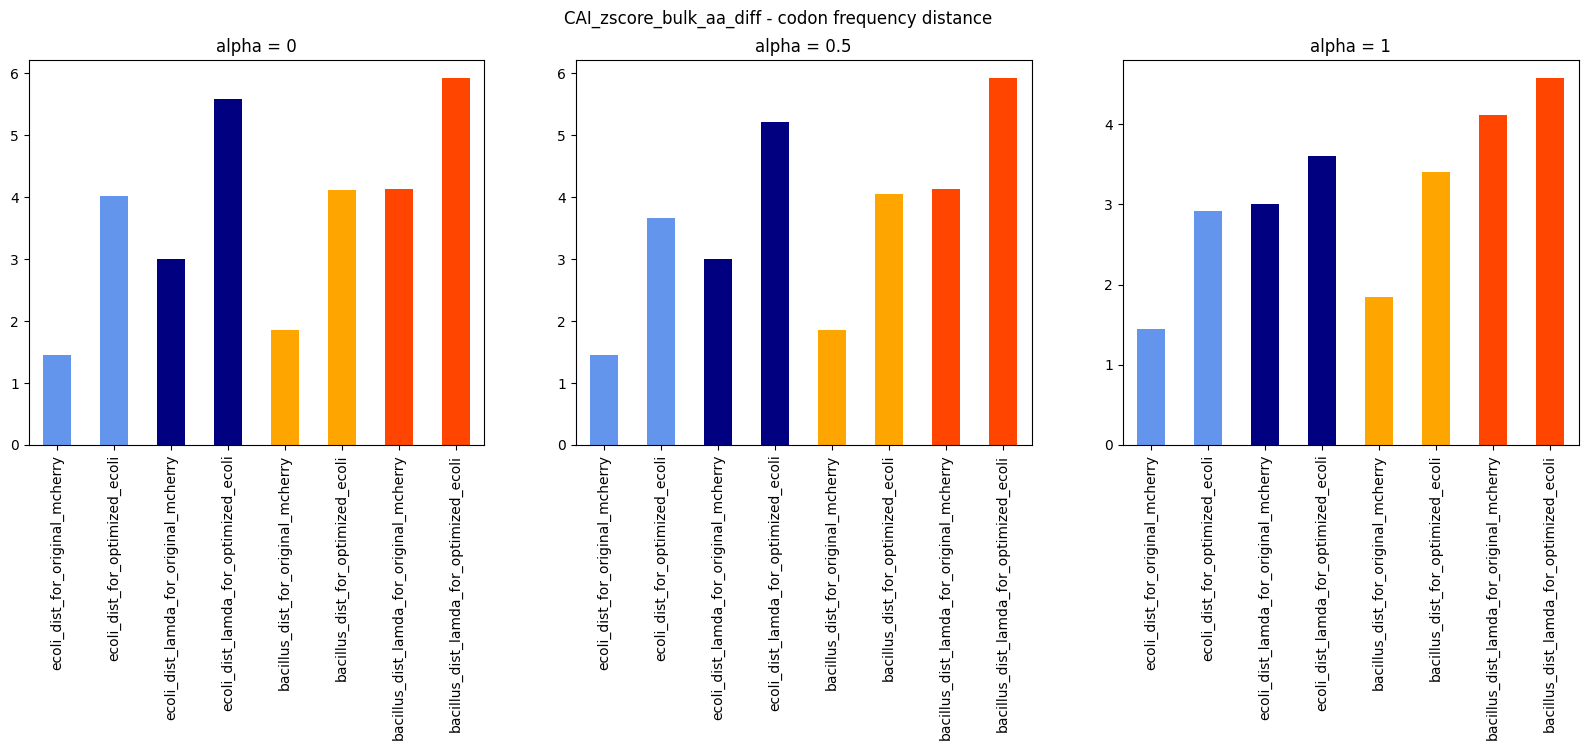

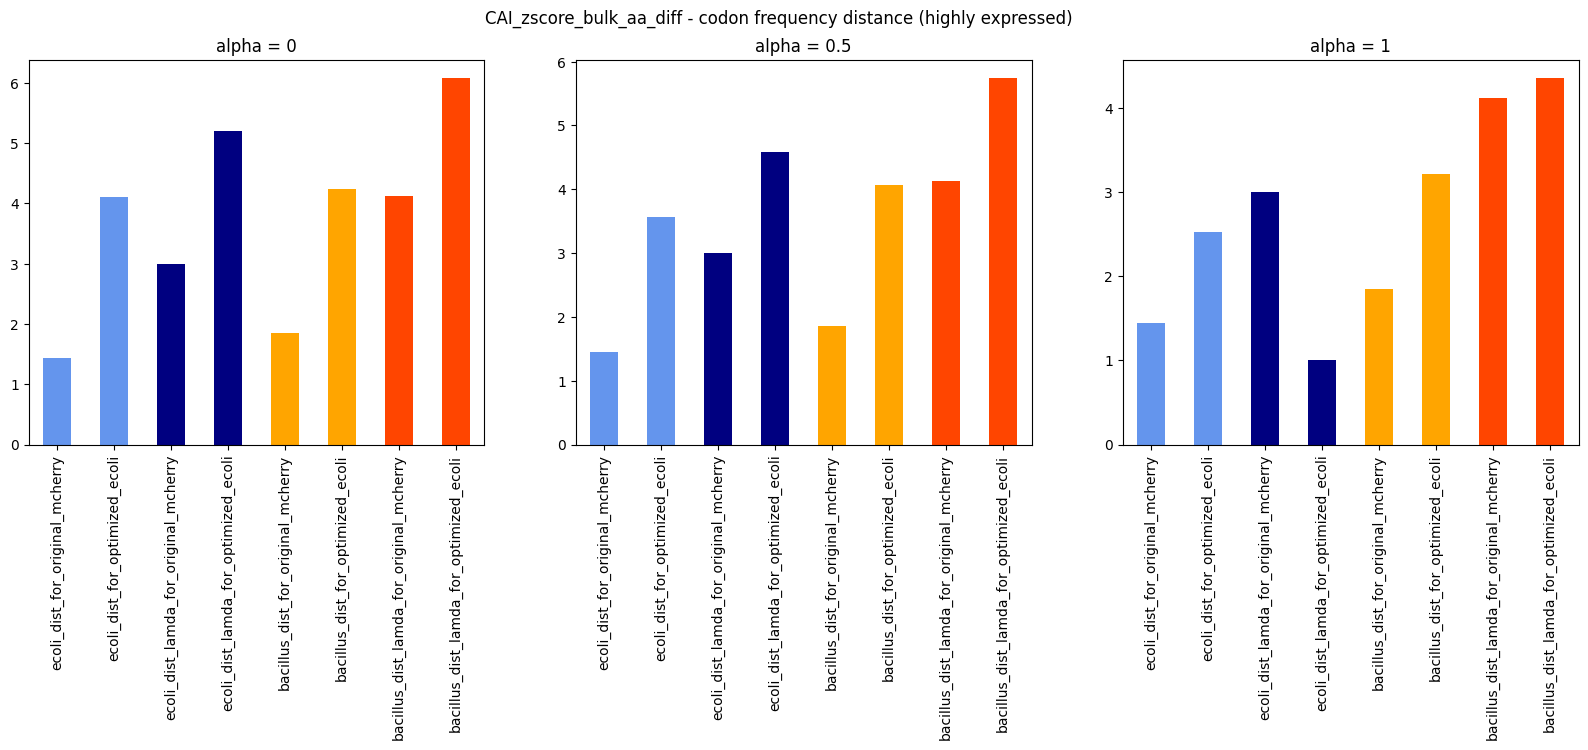

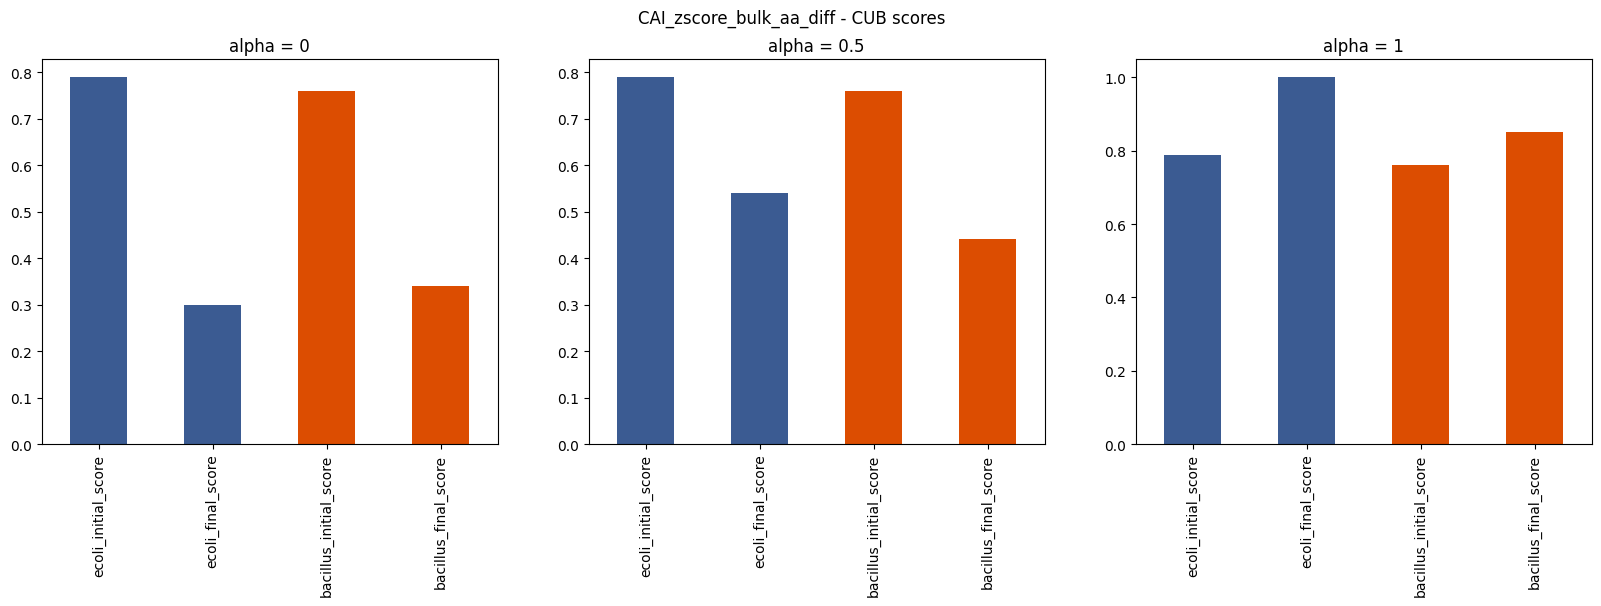

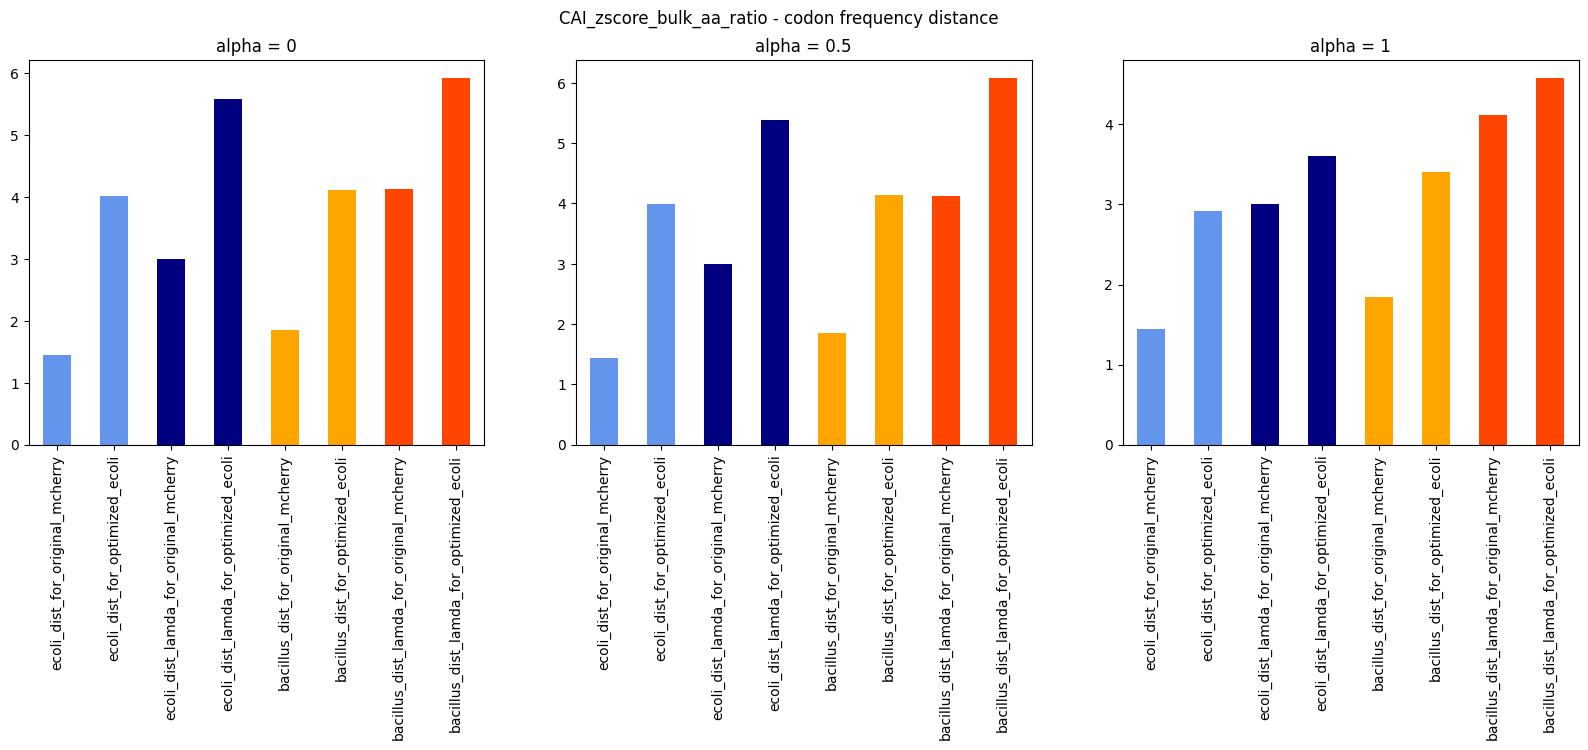

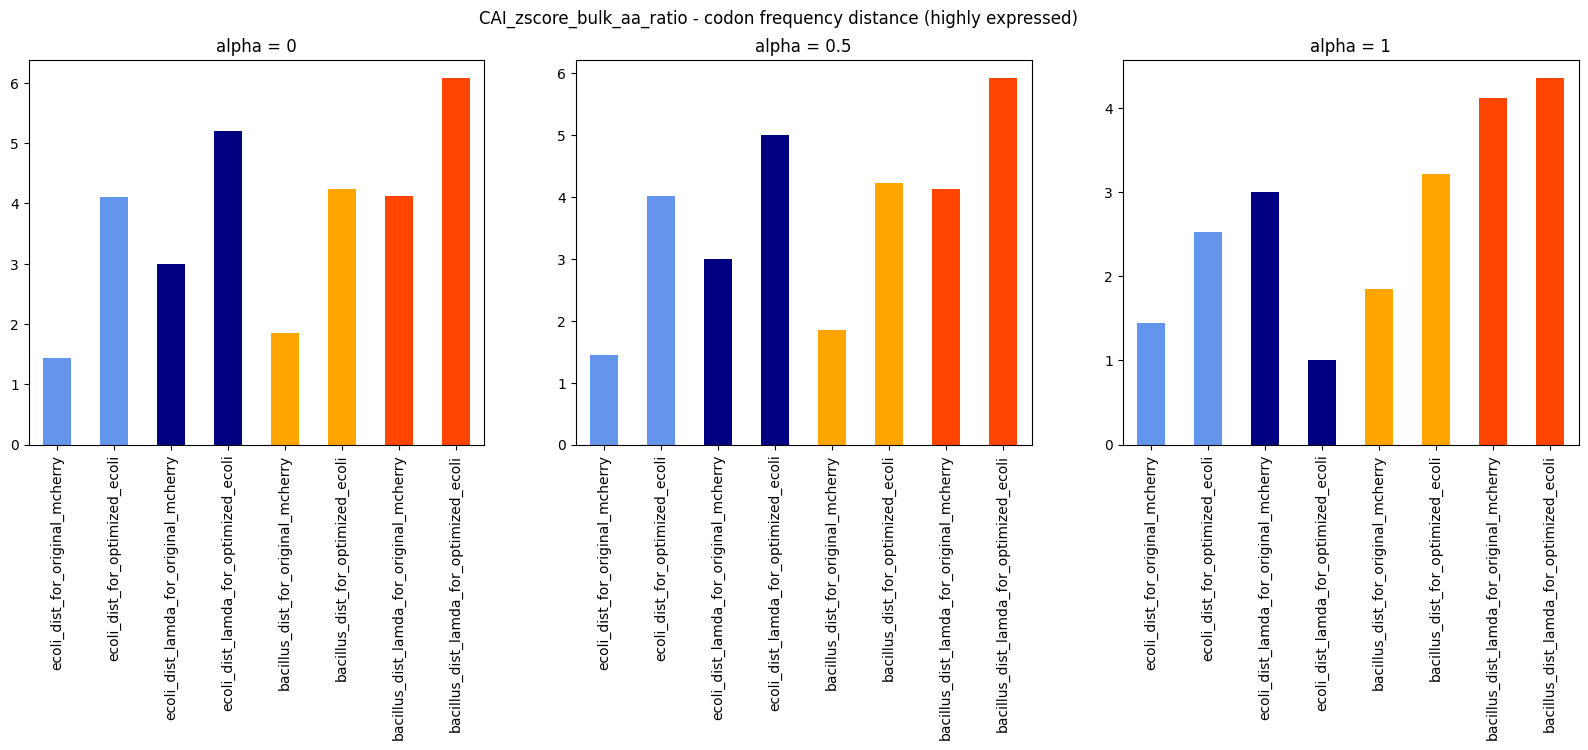

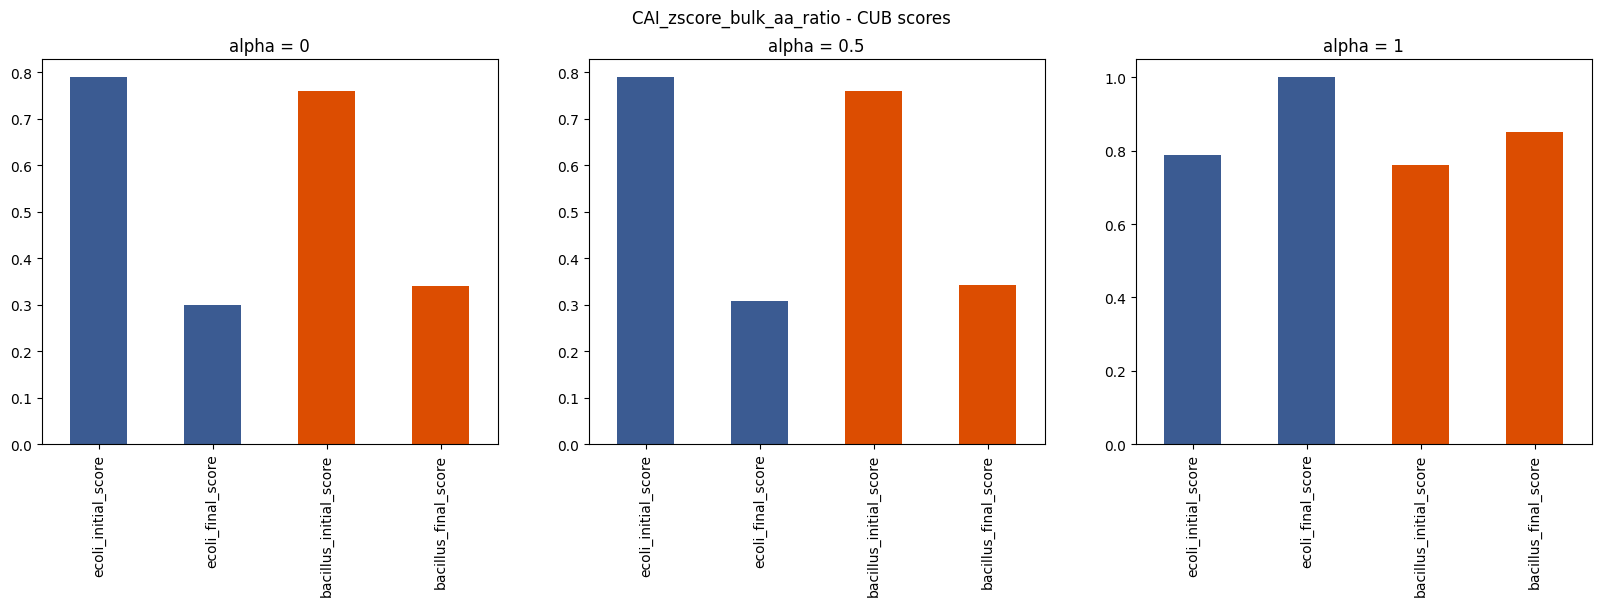

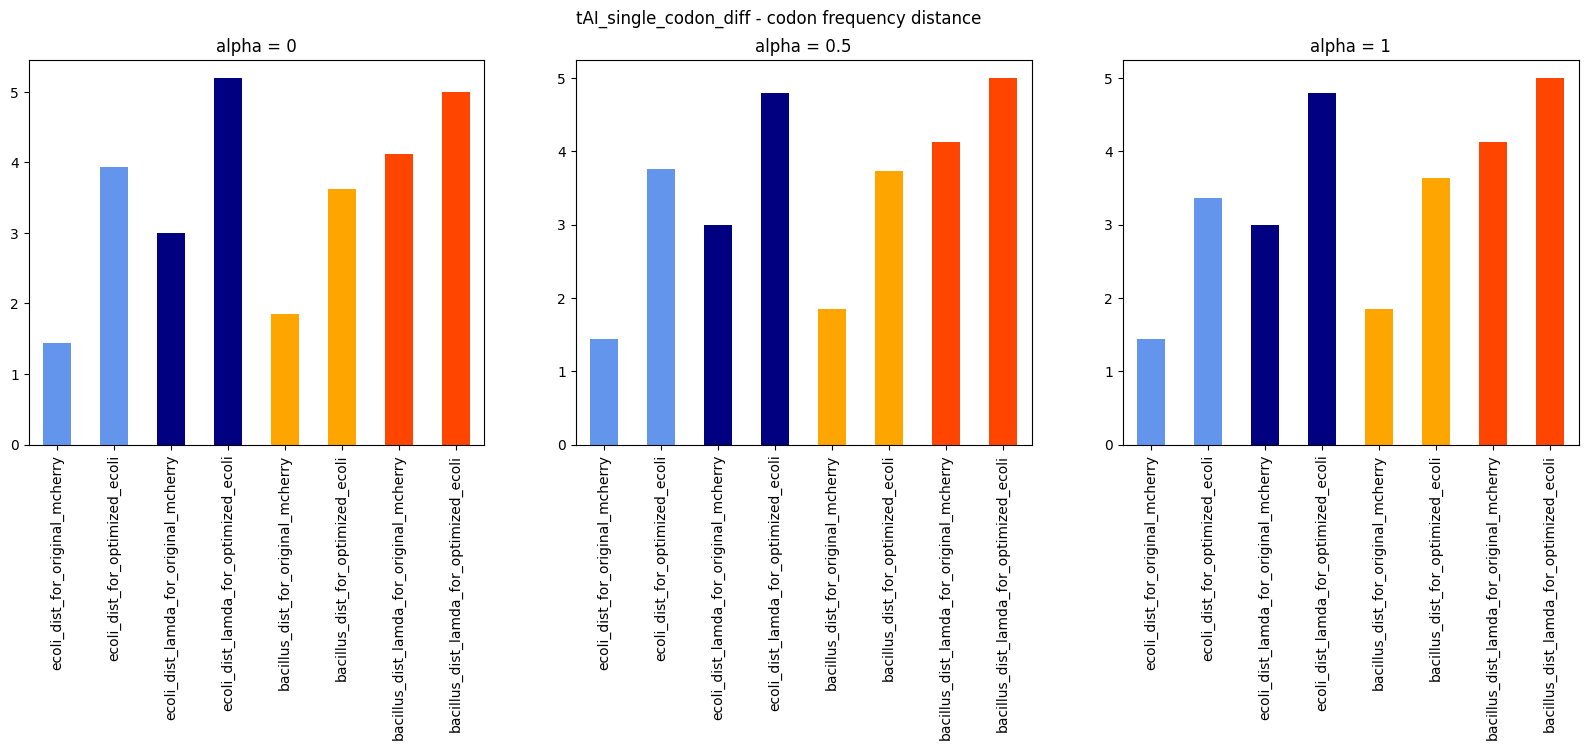

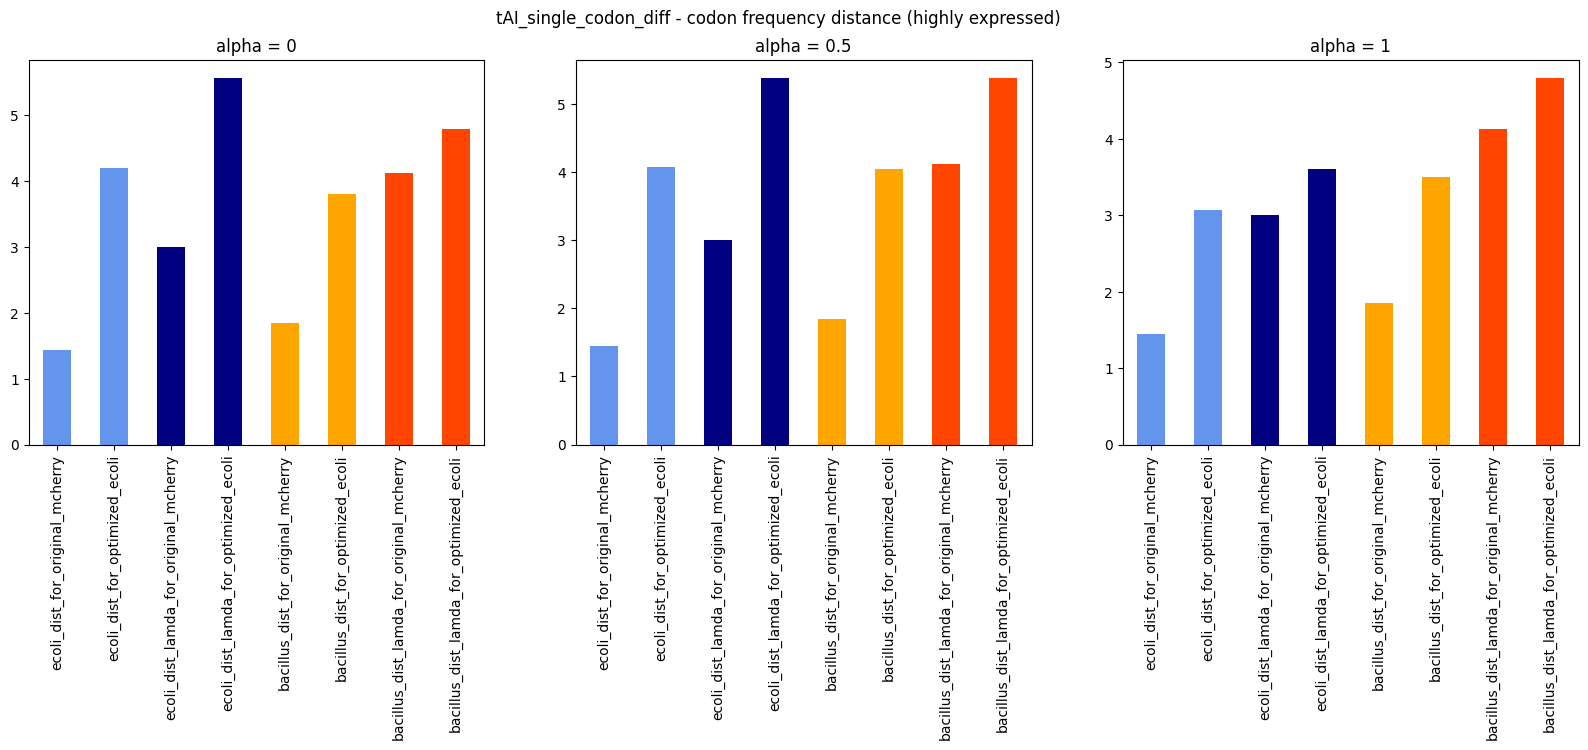

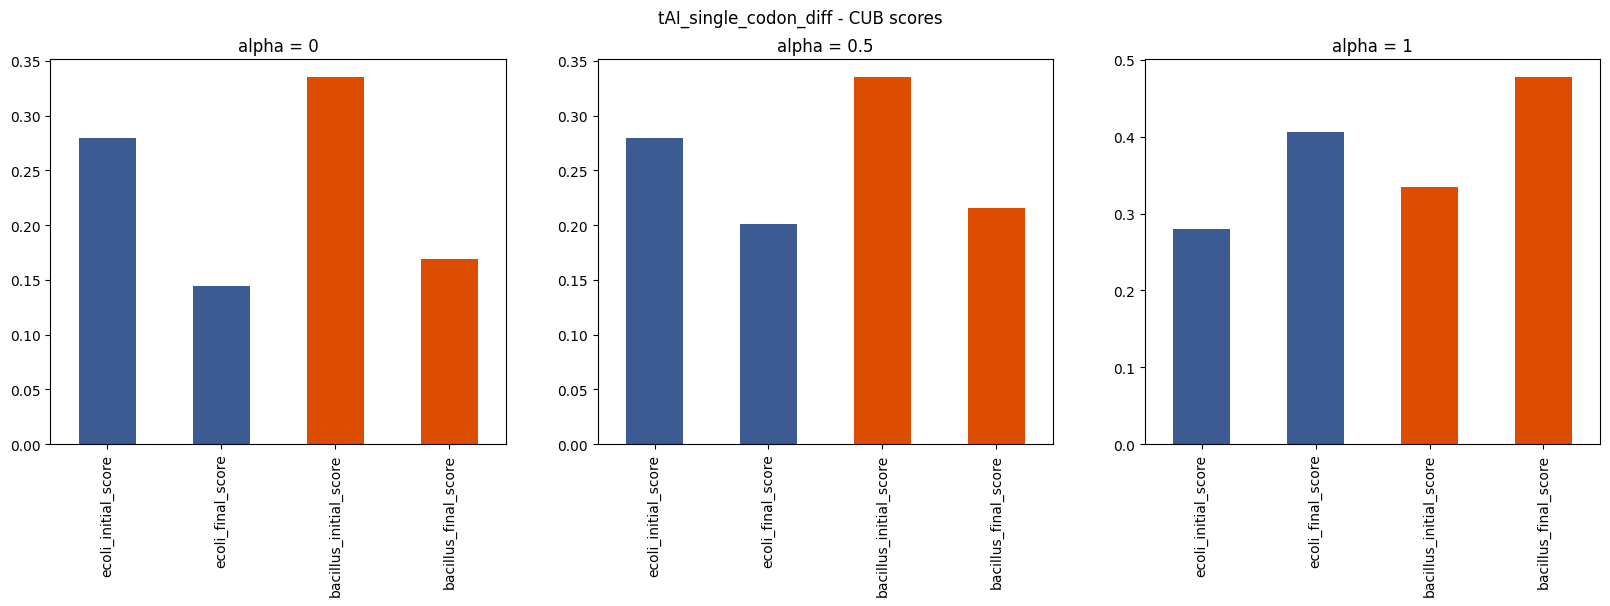

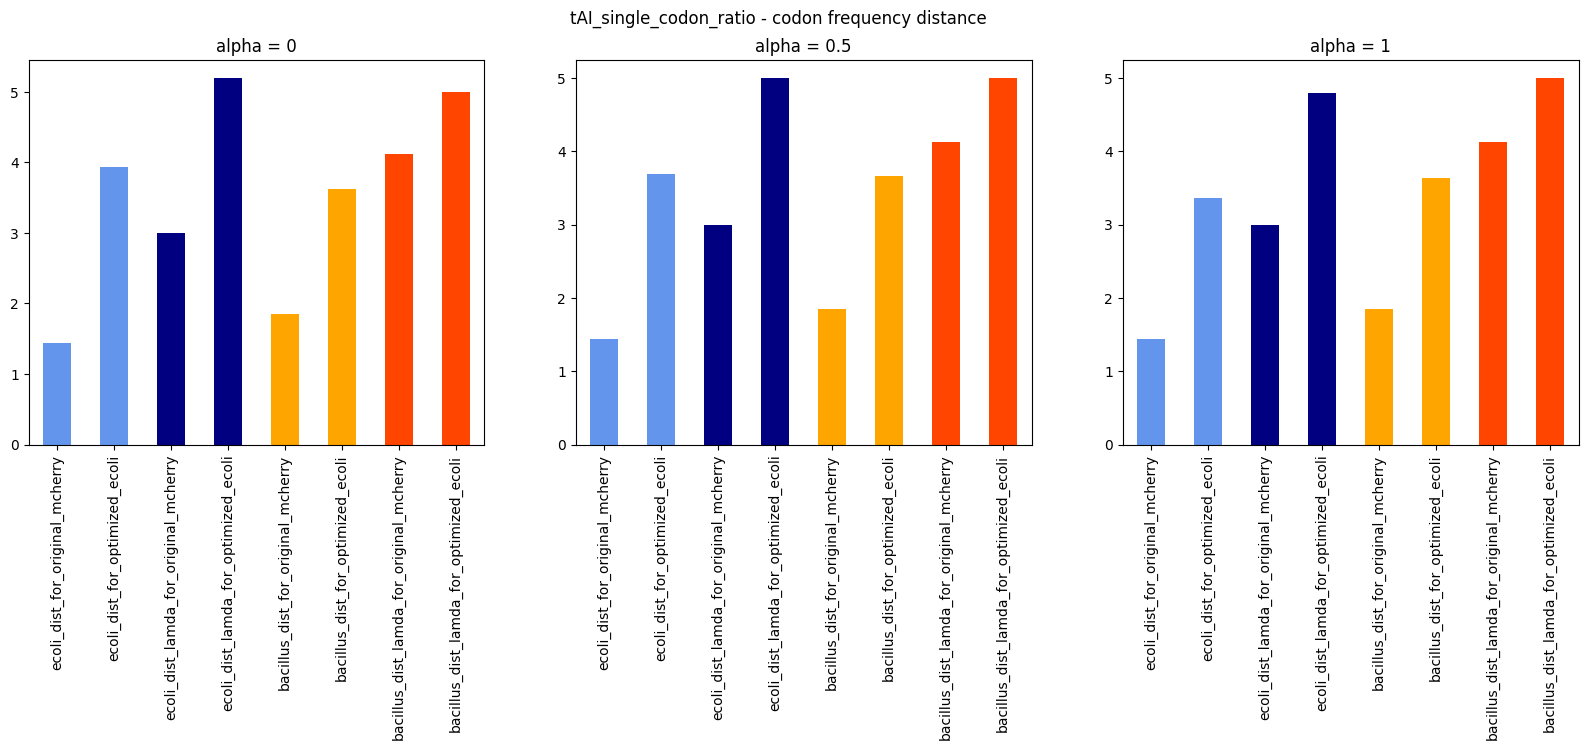

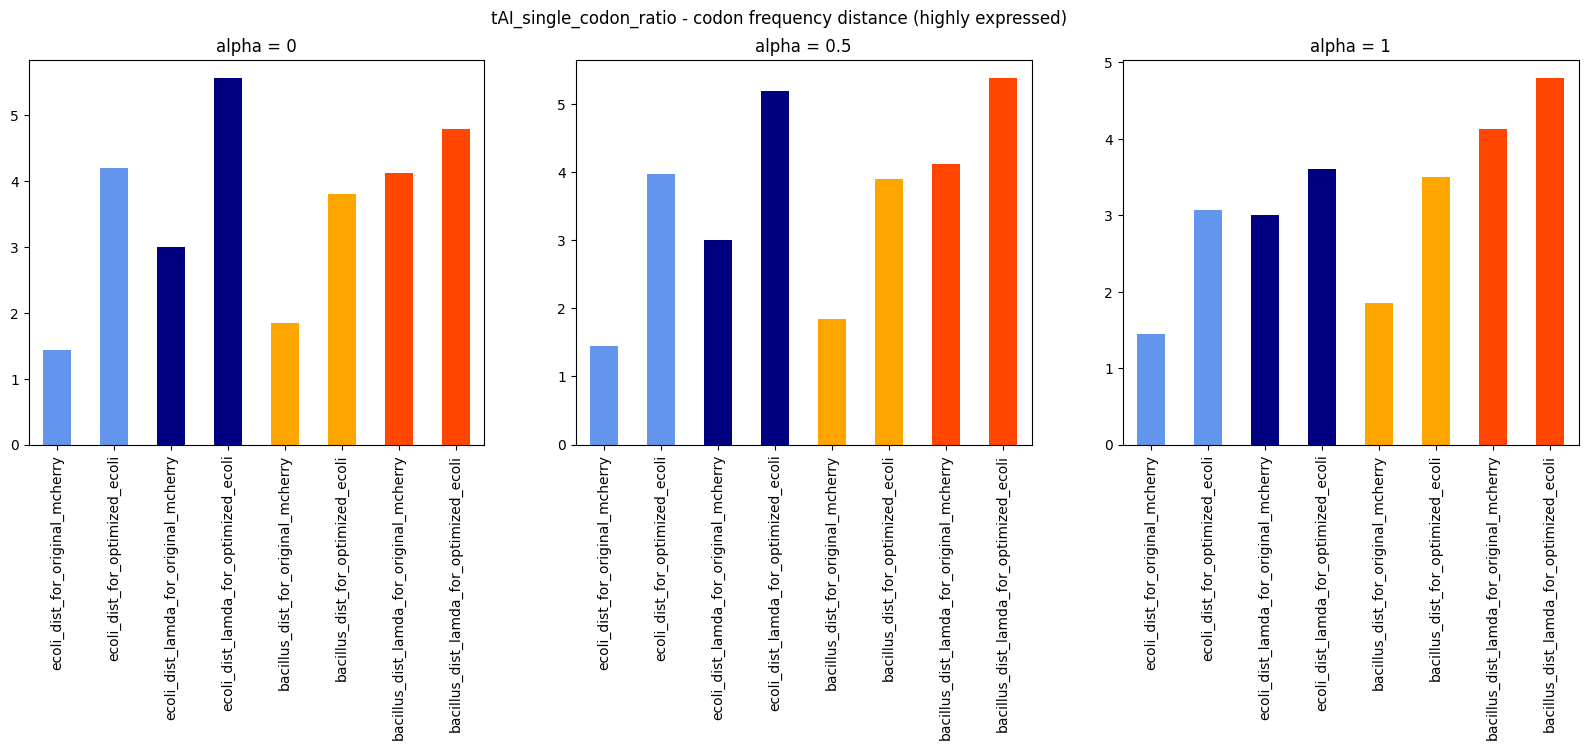

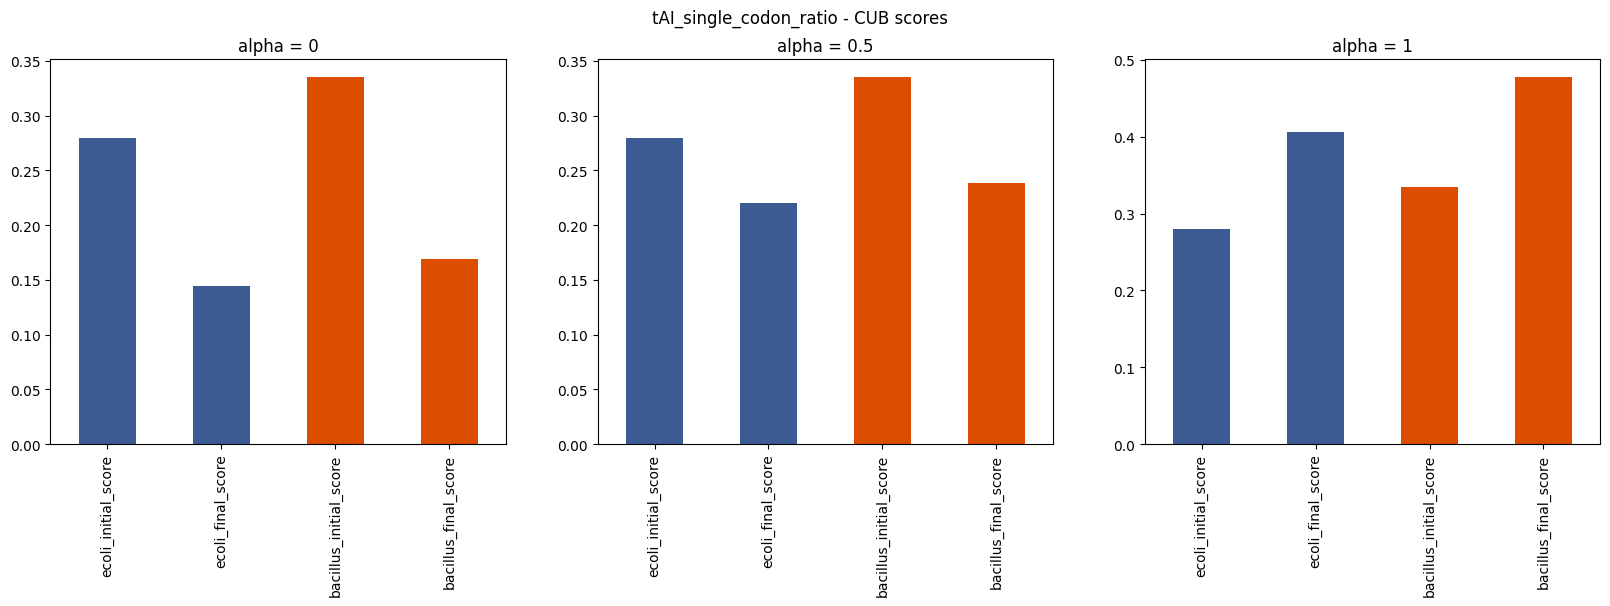

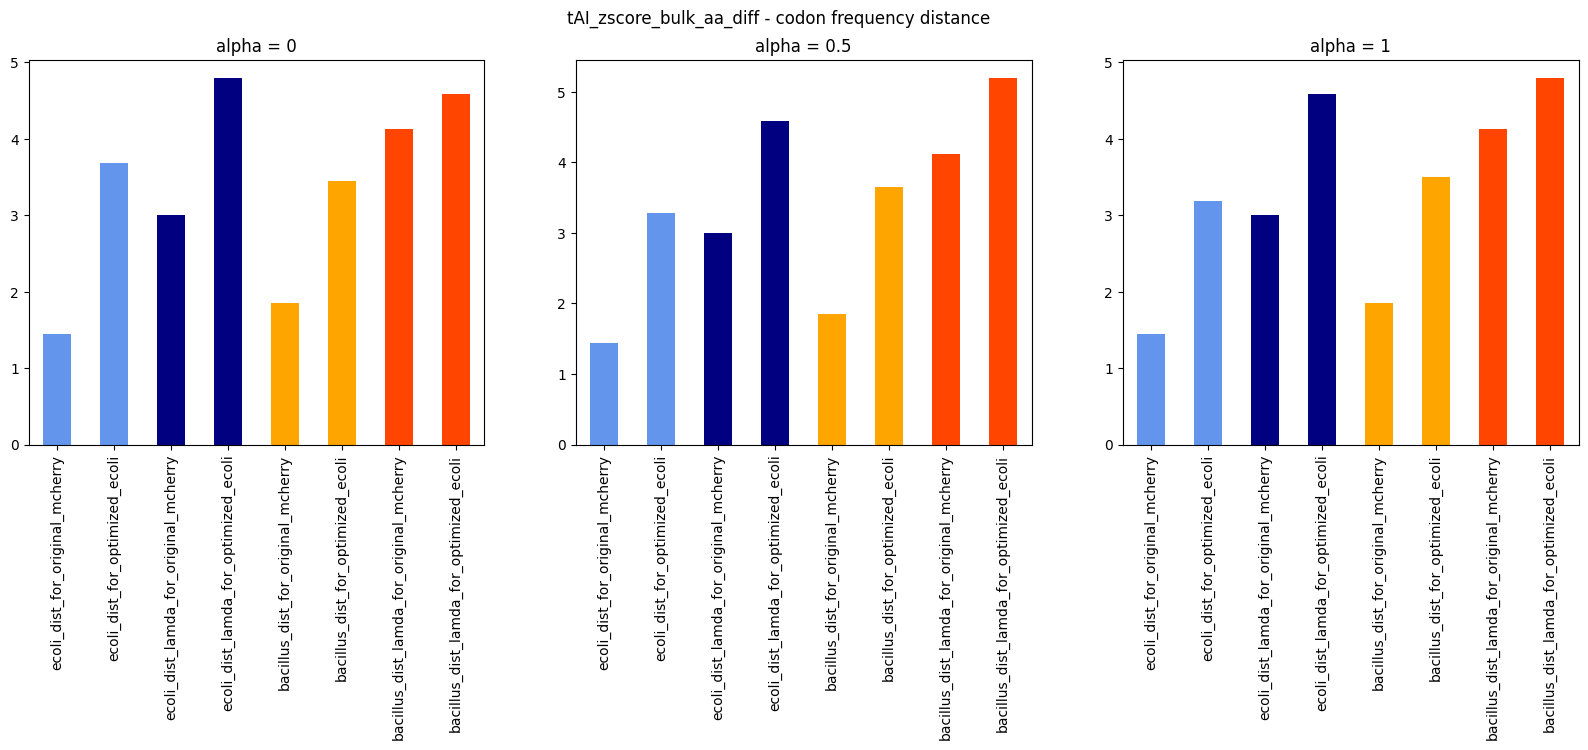

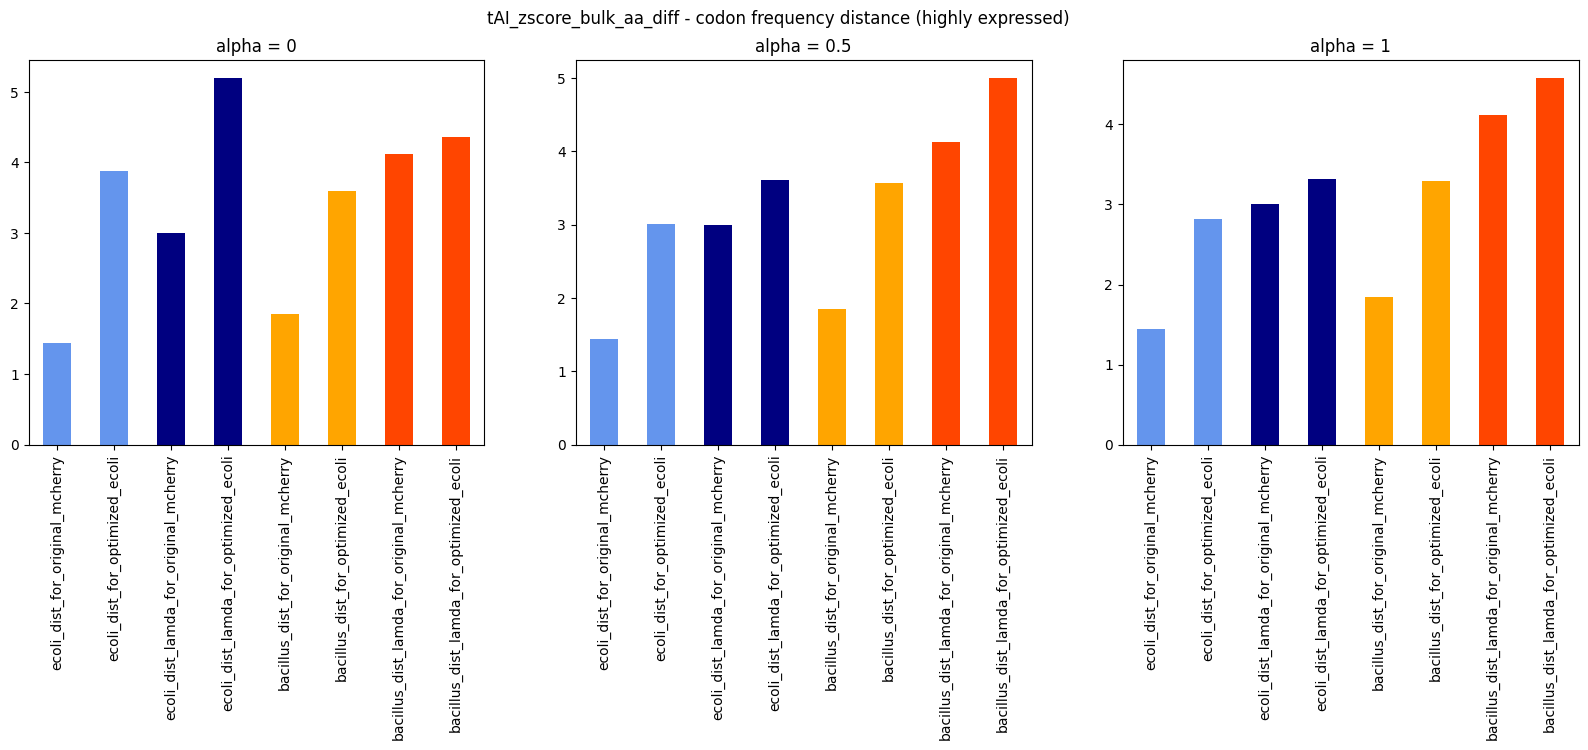

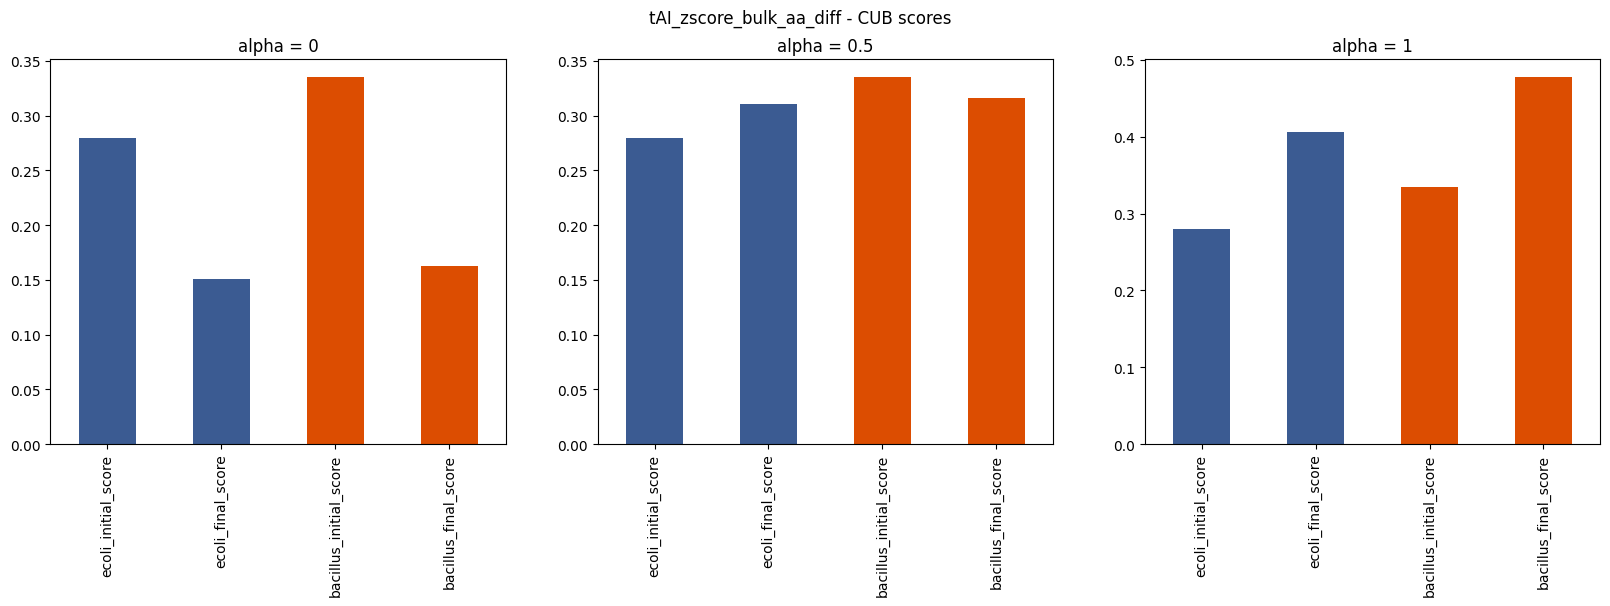

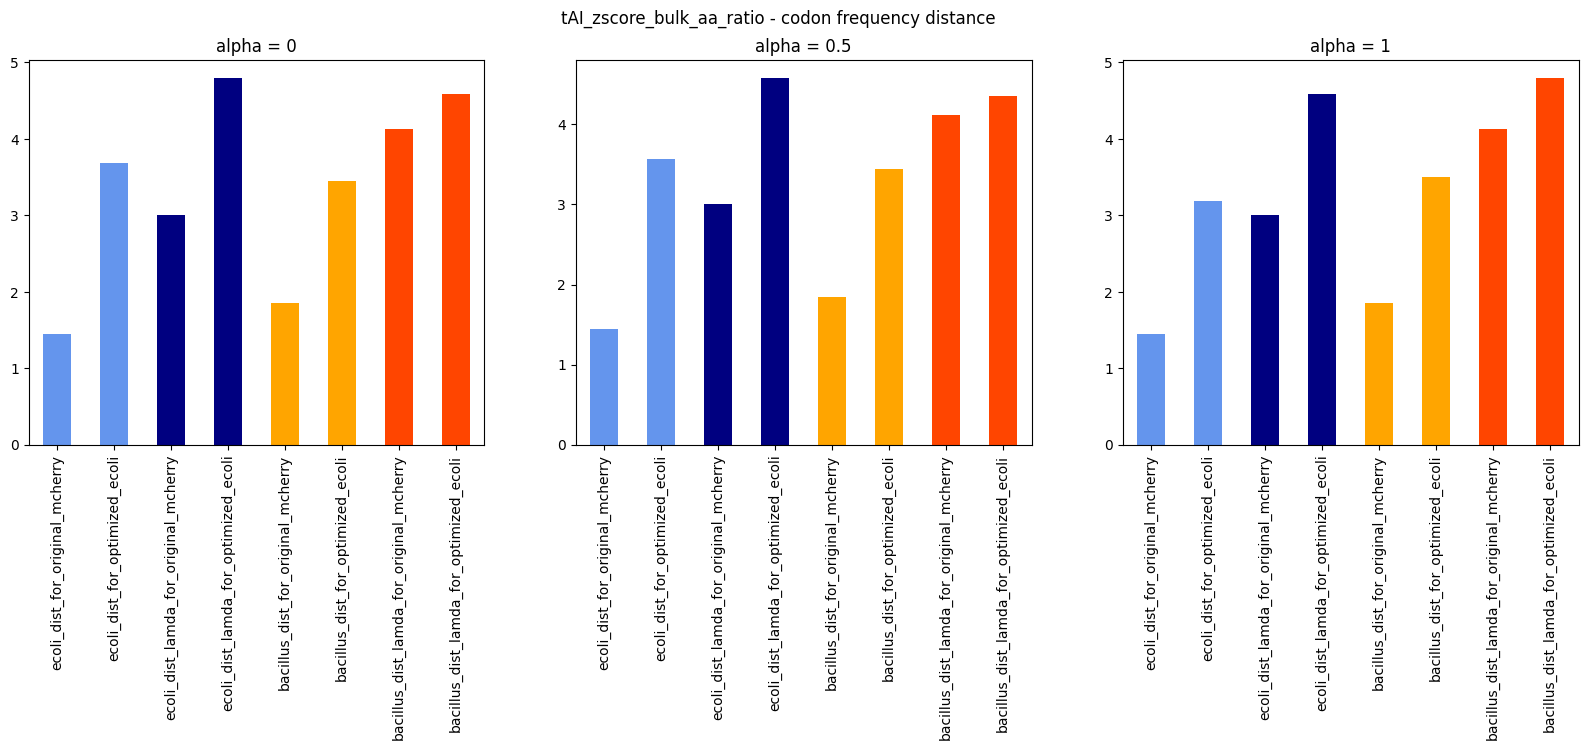

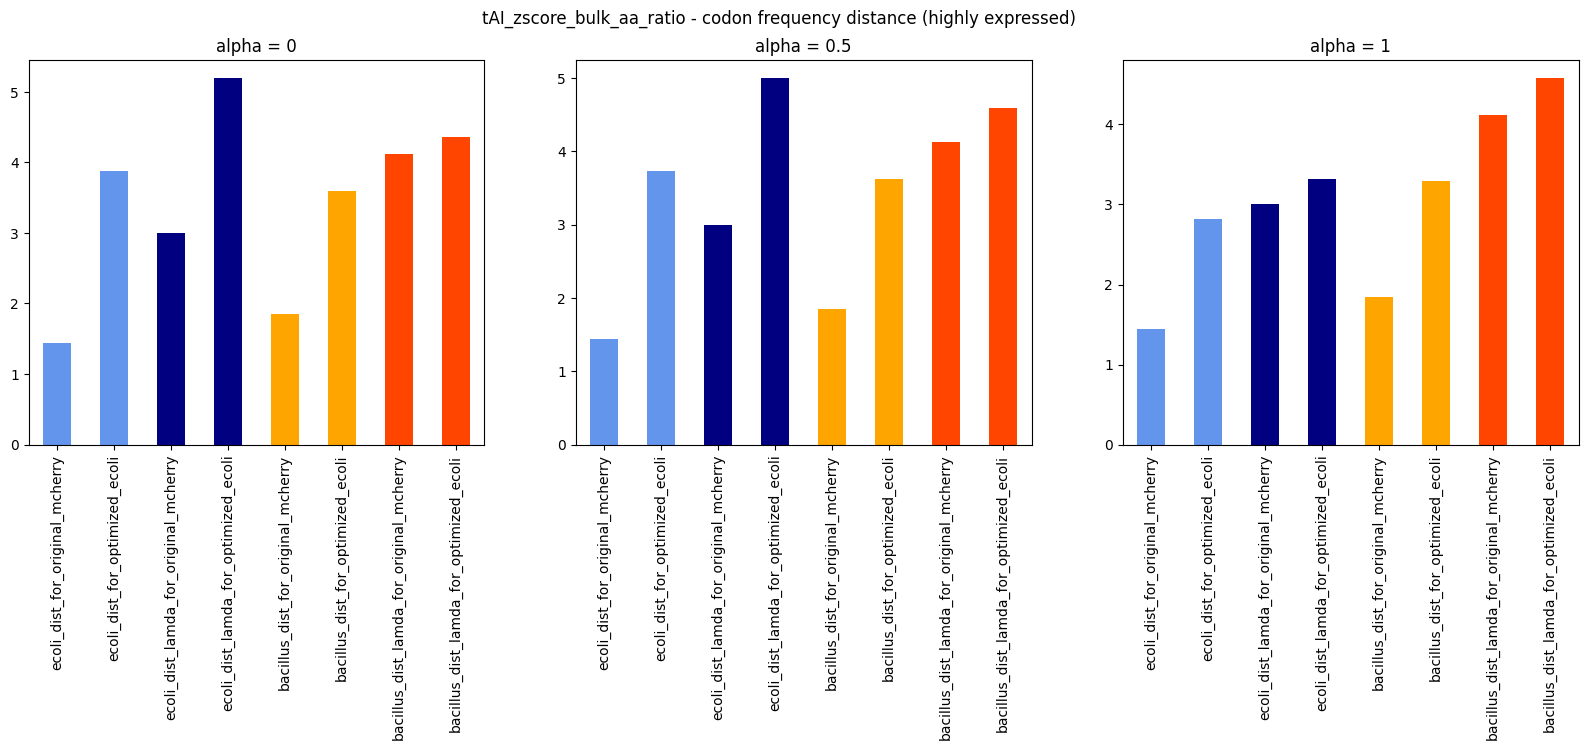

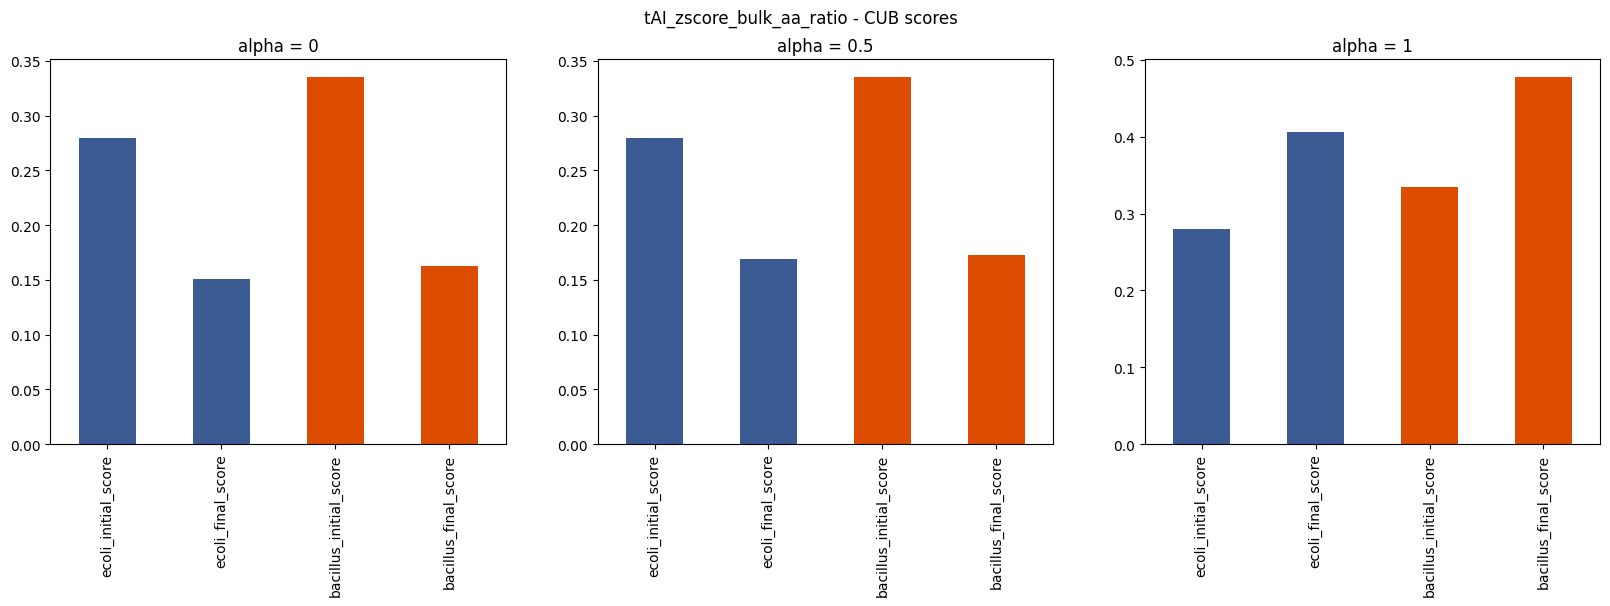

In [78]:
my_colors = ['#3b5b92', '#3b5b92', '#dc4d01', '#dc4d01'] 
my_colors_extended = ['cornflowerblue', 'cornflowerblue', 'navy', 'navy', 'orange', 'orange', 'orangered', 'orangered'] 
for q in range(cub_ecoli_opt_greater_alpha_variants_dataframe.shape[0]):

    fig, axes = plt.subplots(nrows=1,ncols=3, figsize=(20,5))
    fig.suptitle(greater_alpha_ecoli_opt_variants_dataframe.iloc[q,0] + " - codon frequency distance")
    lower_alpha_ecoli_opt_variants_dataframe.iloc[q,1:].plot(x="variant", kind="bar", ax=axes[0], stacked=True, color=my_colors_extended)
    axes[0].set_title("alpha = 0")
    ecoli_opt_variants_dataframe.iloc[q,1:].plot(x="variant", kind="bar", ax=axes[1], stacked=True, color=my_colors_extended)
    axes[1].set_title("alpha = 0.5")
    greater_alpha_ecoli_opt_variants_dataframe.iloc[q,1:].plot(x="variant", kind="bar", ax=axes[2], stacked=True, color=my_colors_extended)
    axes[2].set_title("alpha = 1")
    
    fig, axes = plt.subplots(nrows=1,ncols=3, figsize=(20,5))
    fig.suptitle(greater_alpha_ecoli_opt_variants_dataframe_highly_expressed.iloc[q,0] + " - codon frequency distance (highly expressed)")
    lower_alpha_ecoli_opt_variants_dataframe_highly_expressed.iloc[q,1:].plot(x="variant", kind="bar", ax=axes[0], stacked=True, color=my_colors_extended)
    axes[0].set_title("alpha = 0")
    ecoli_opt_variants_dataframe_highly_expressed.iloc[q,1:].plot(x="variant", kind="bar", ax=axes[1], stacked=True, color=my_colors_extended)
    axes[1].set_title("alpha = 0.5")
    greater_alpha_ecoli_opt_variants_dataframe_highly_expressed.iloc[q,1:].plot(x="variant", kind="bar", ax=axes[2], stacked=True, color=my_colors_extended)
    axes[2].set_title("alpha = 1")


    fig, axes = plt.subplots(nrows=1,ncols=3, figsize=(20,5))
    fig.suptitle(cub_ecoli_opt_greater_alpha_variants_dataframe.iloc[q,0] + " - CUB scores")
    cub_ecoli_opt_lower_alpha_variants_dataframe.iloc[q,1:].plot(x="variant", kind="bar", ax=axes[0], stacked=True, color=my_colors)
    axes[0].set_title("alpha = 0")
    cub_ecoli_opt_variants_dataframe.iloc[q,1:].plot(x="variant", kind="bar", ax=axes[1], stacked=True, color=my_colors)
    axes[1].set_title("alpha = 0.5")
    cub_ecoli_opt_greater_alpha_variants_dataframe.iloc[q,1:].plot(x="variant", kind="bar", ax=axes[2], stacked=True, color=my_colors)
    axes[2].set_title("alpha = 1")

## Optimizing for Bacillus

C:\projects\Igem_TAU_2021_moran\venv\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


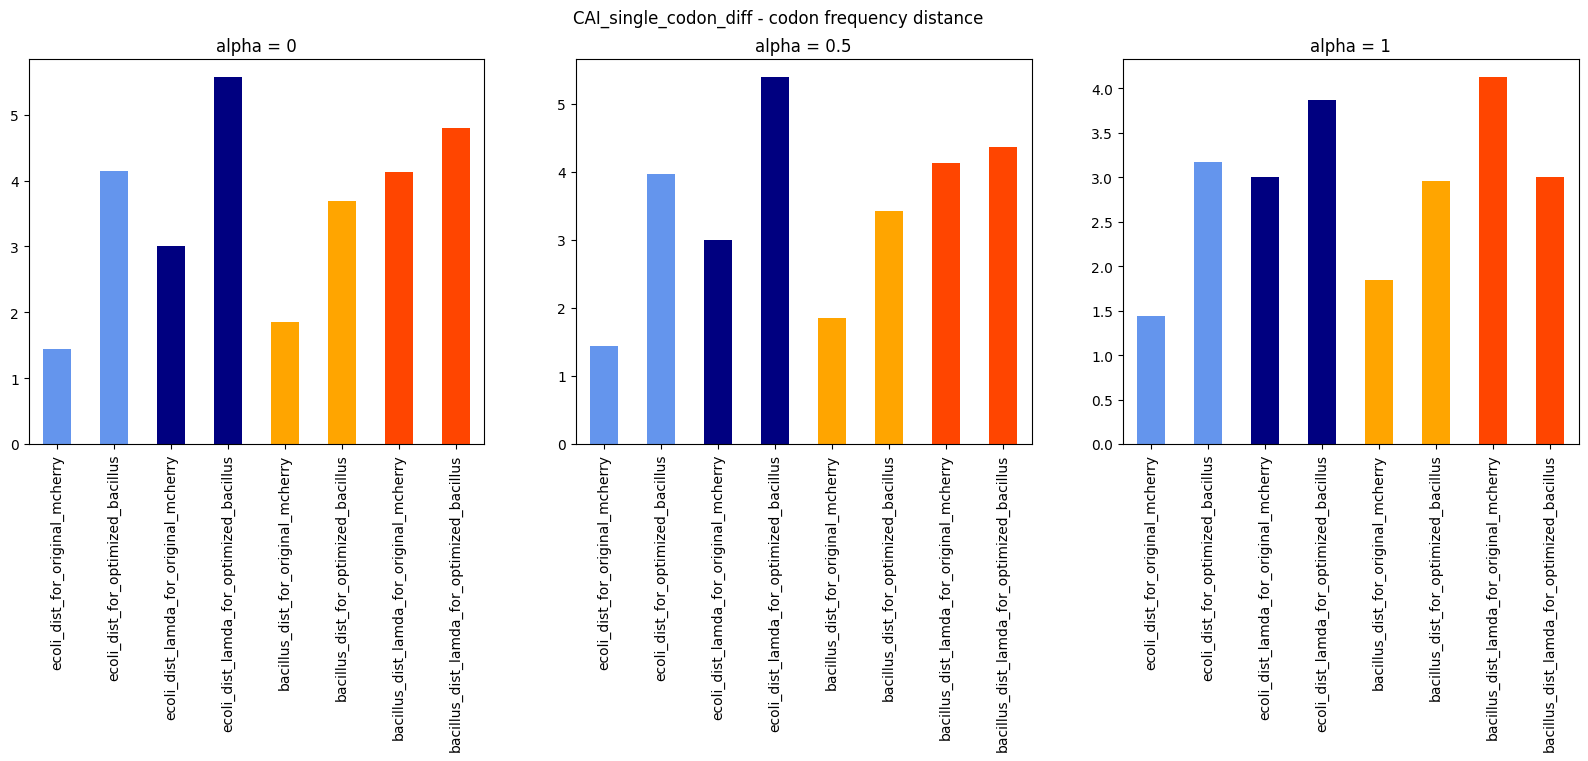

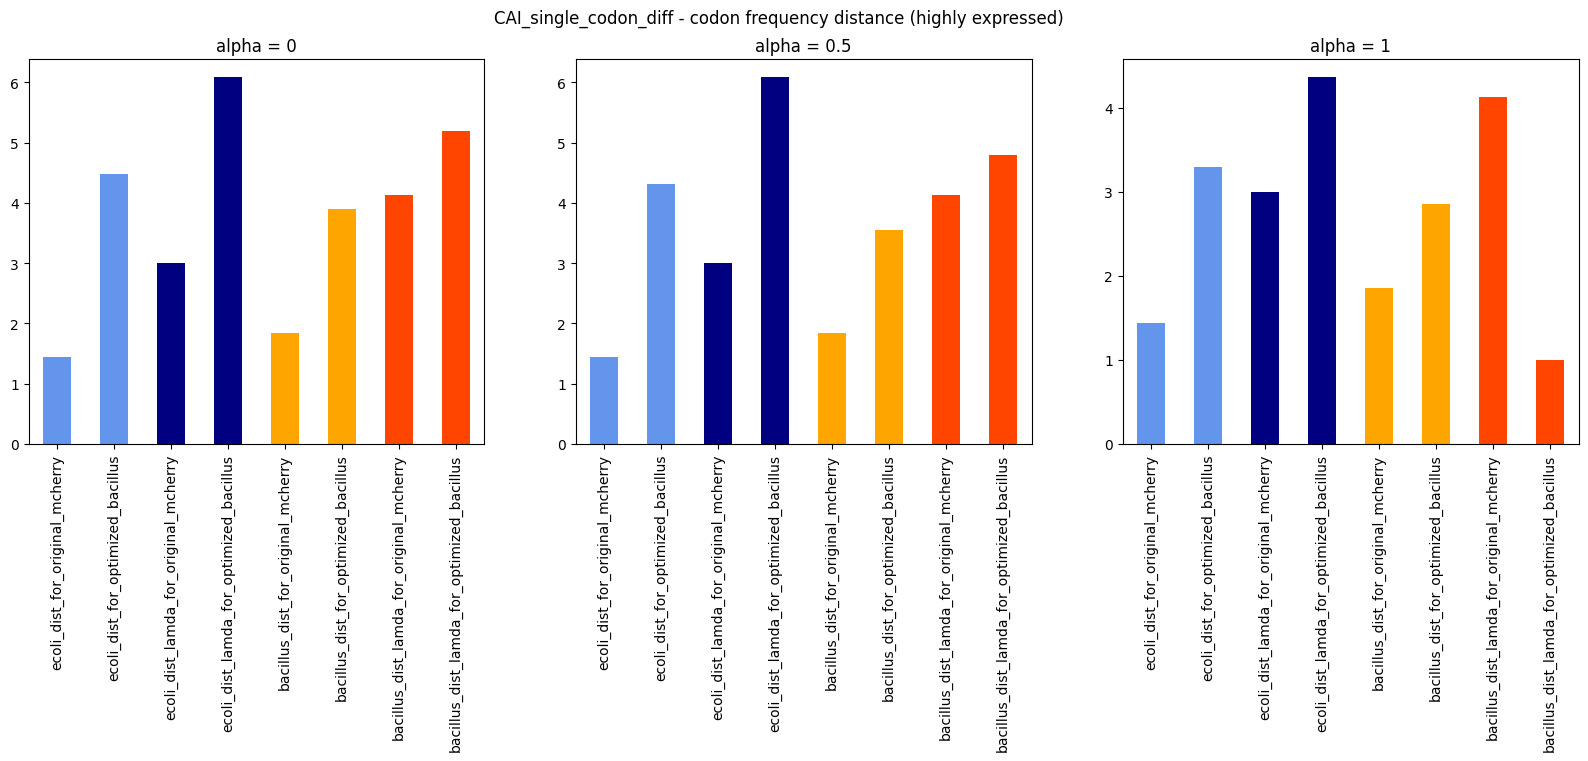

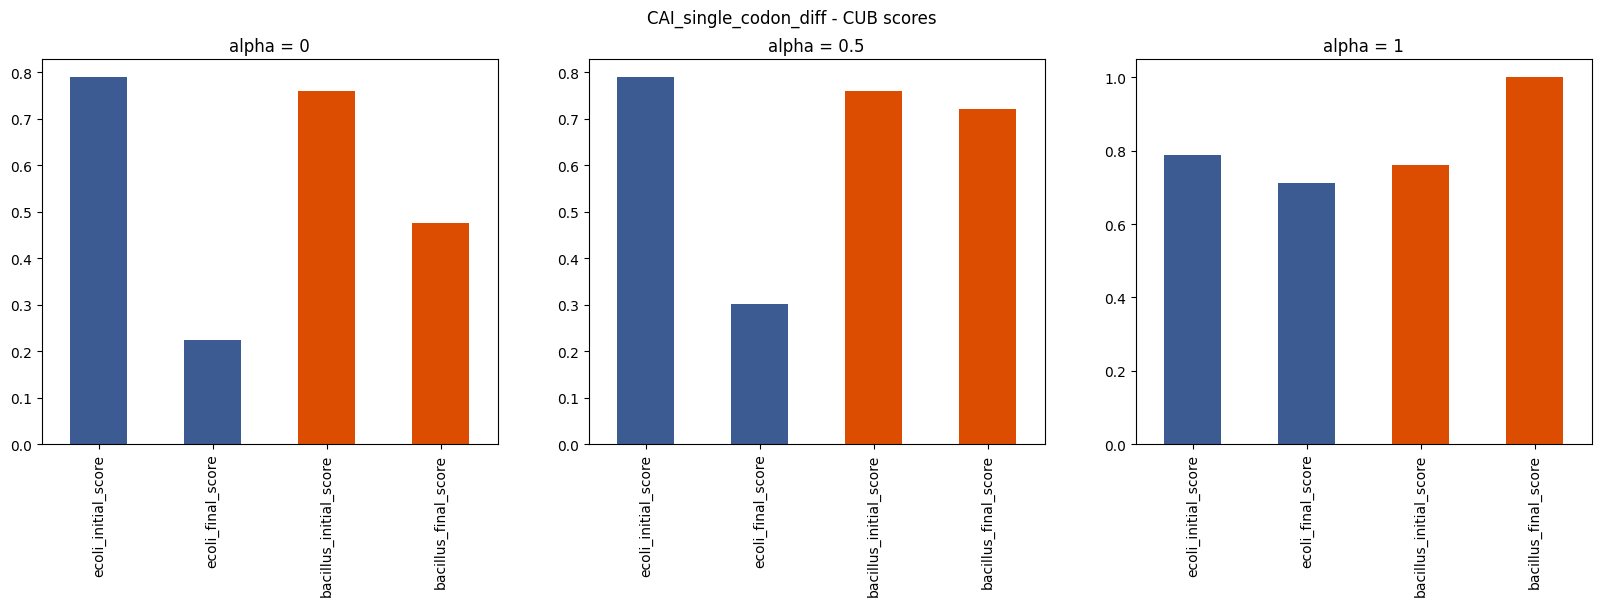

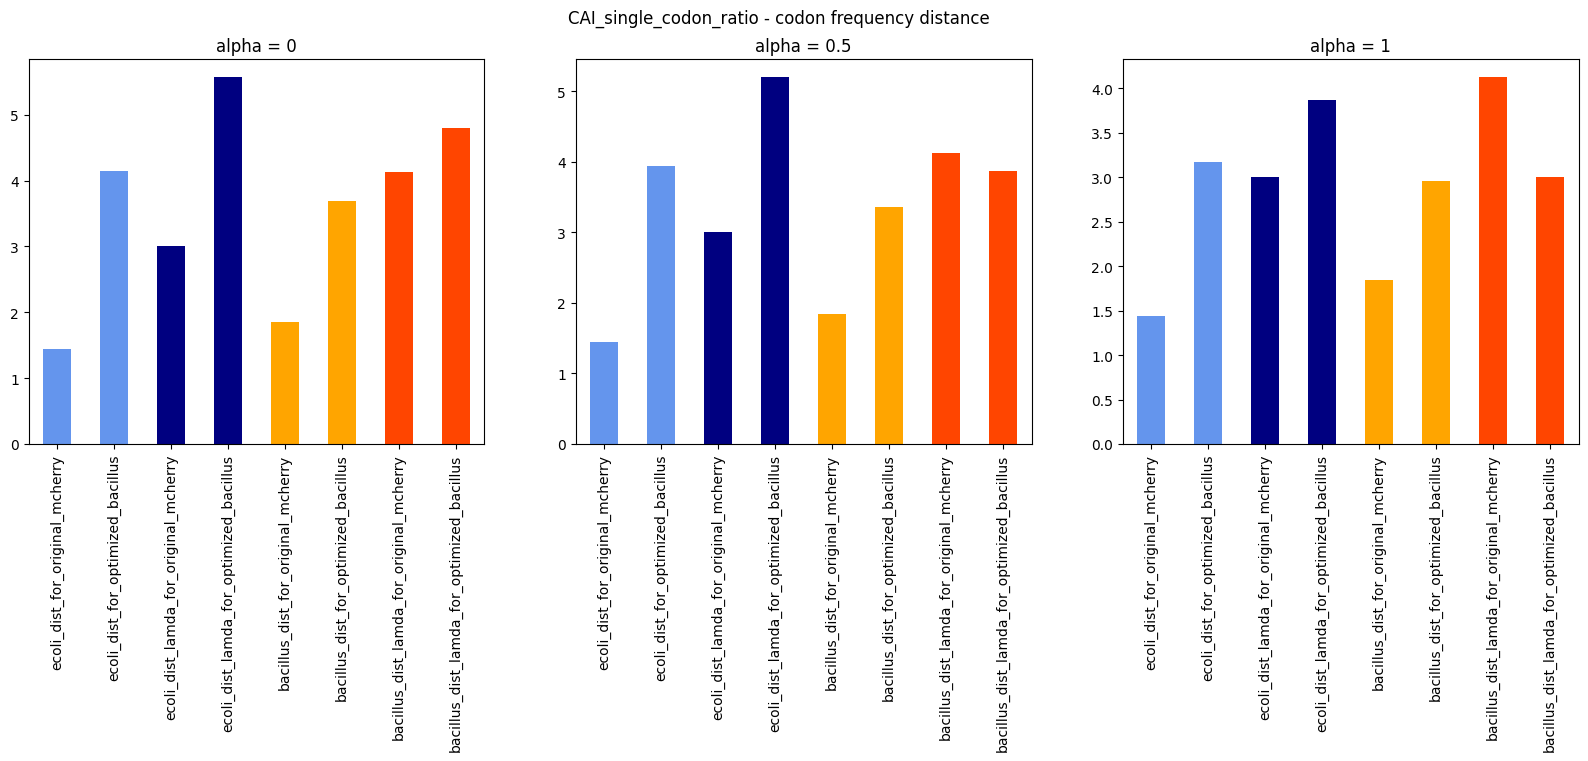

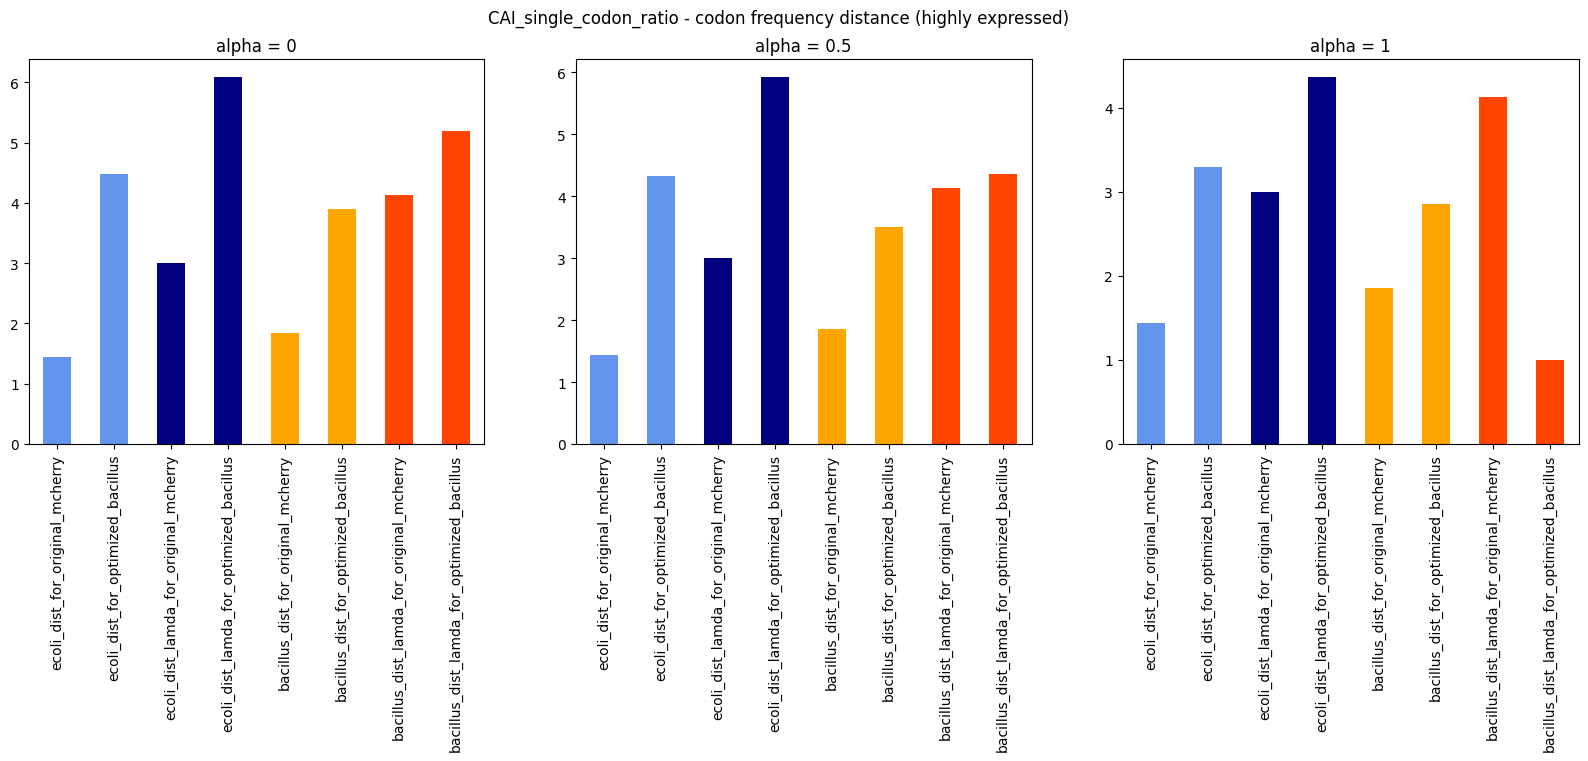

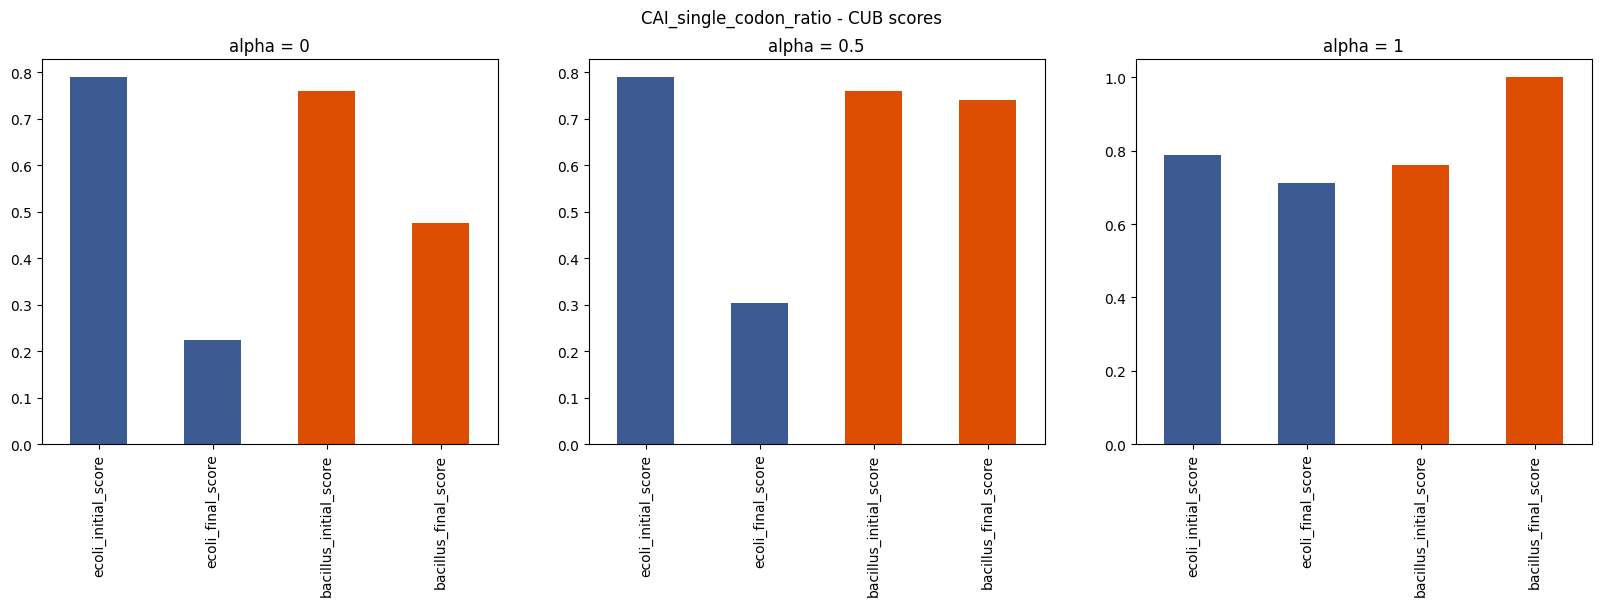

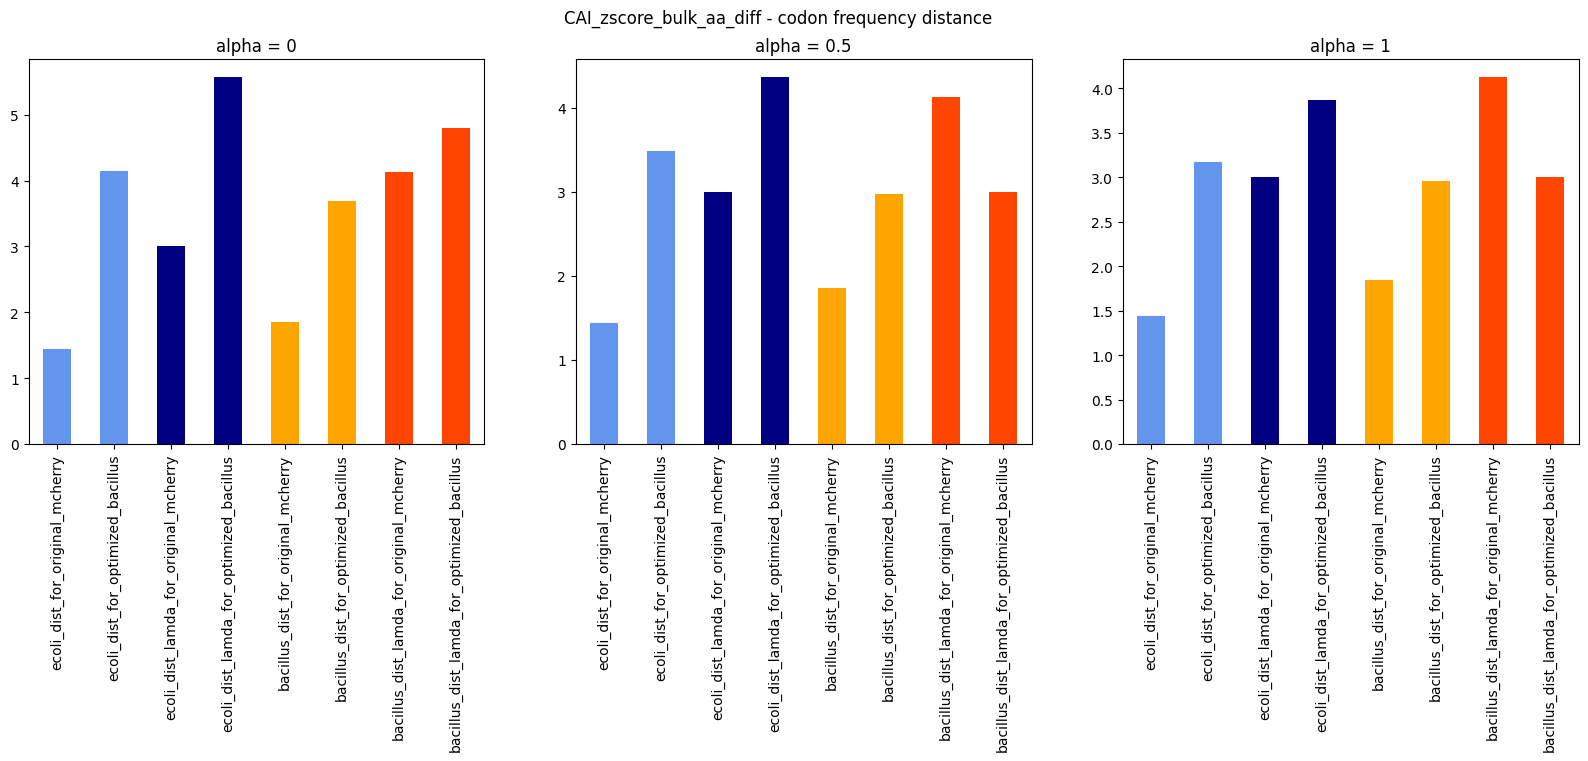

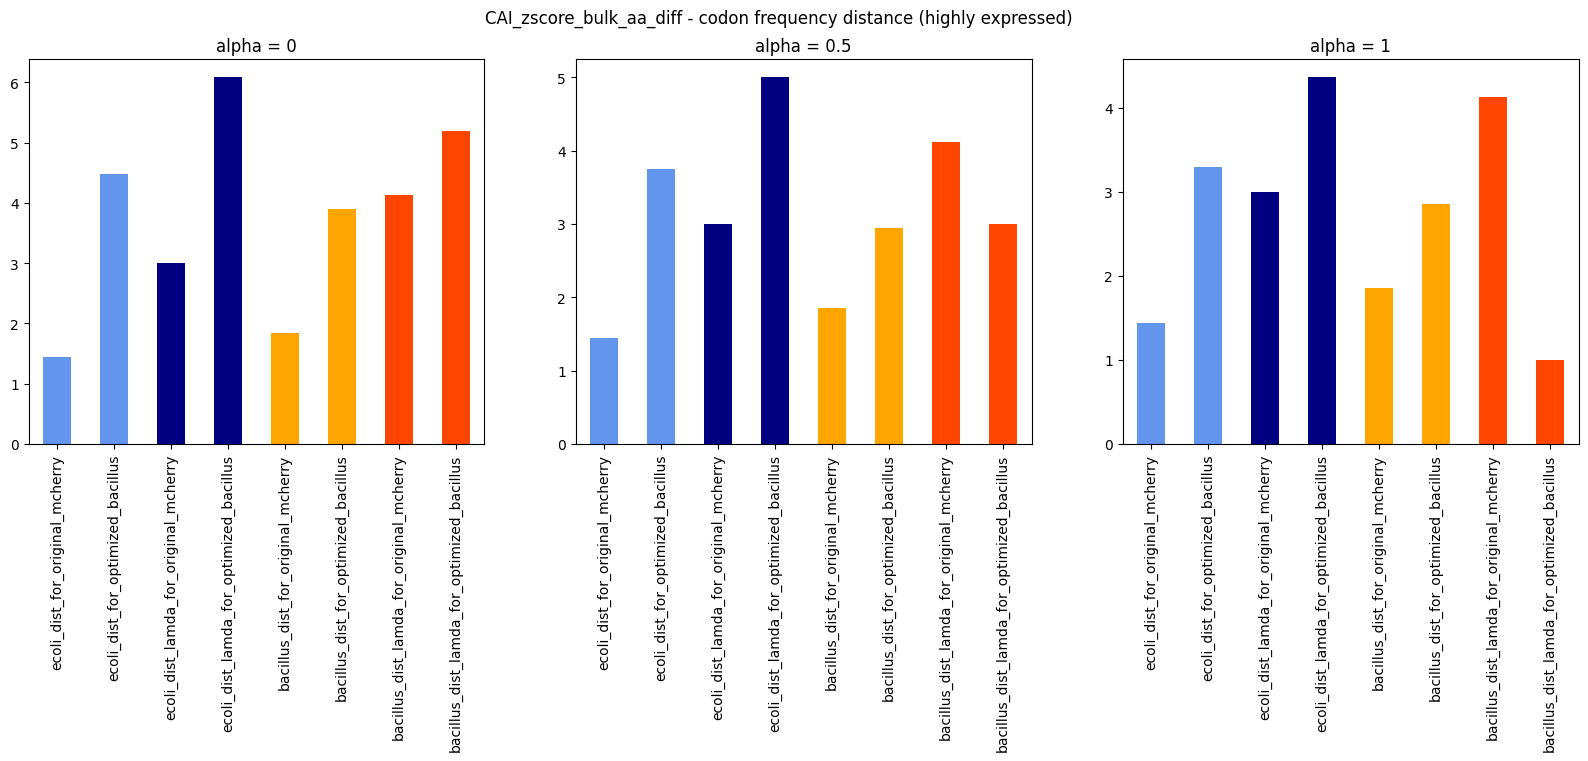

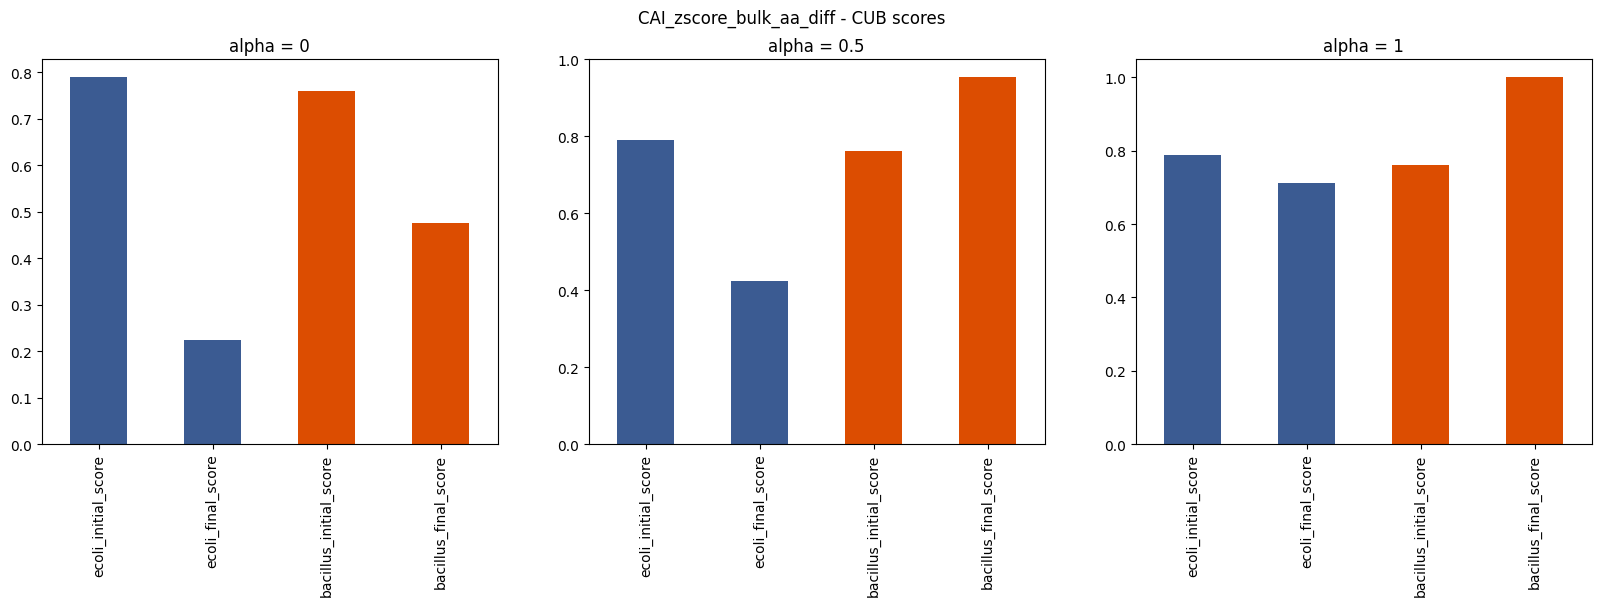

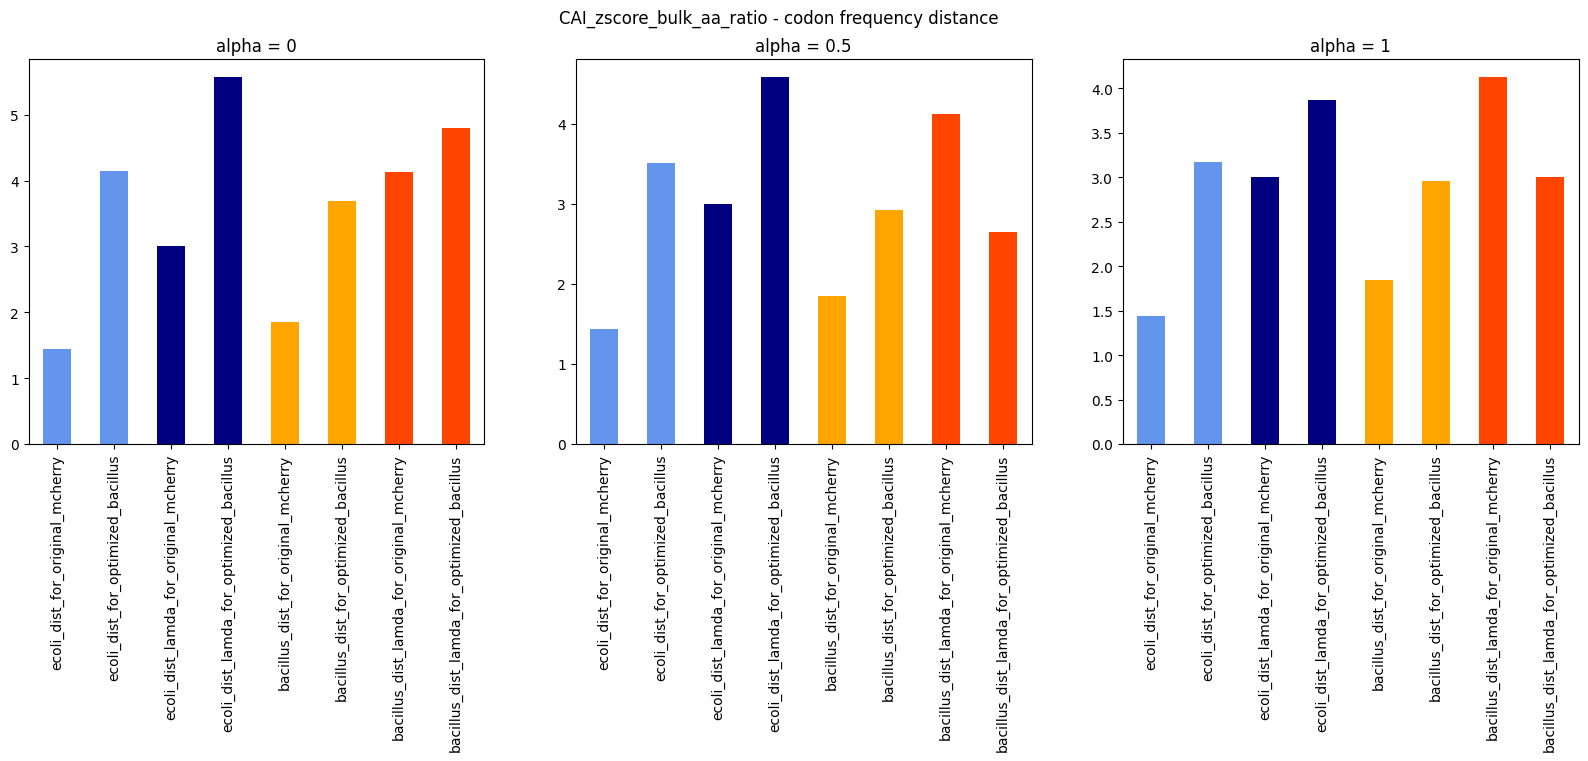

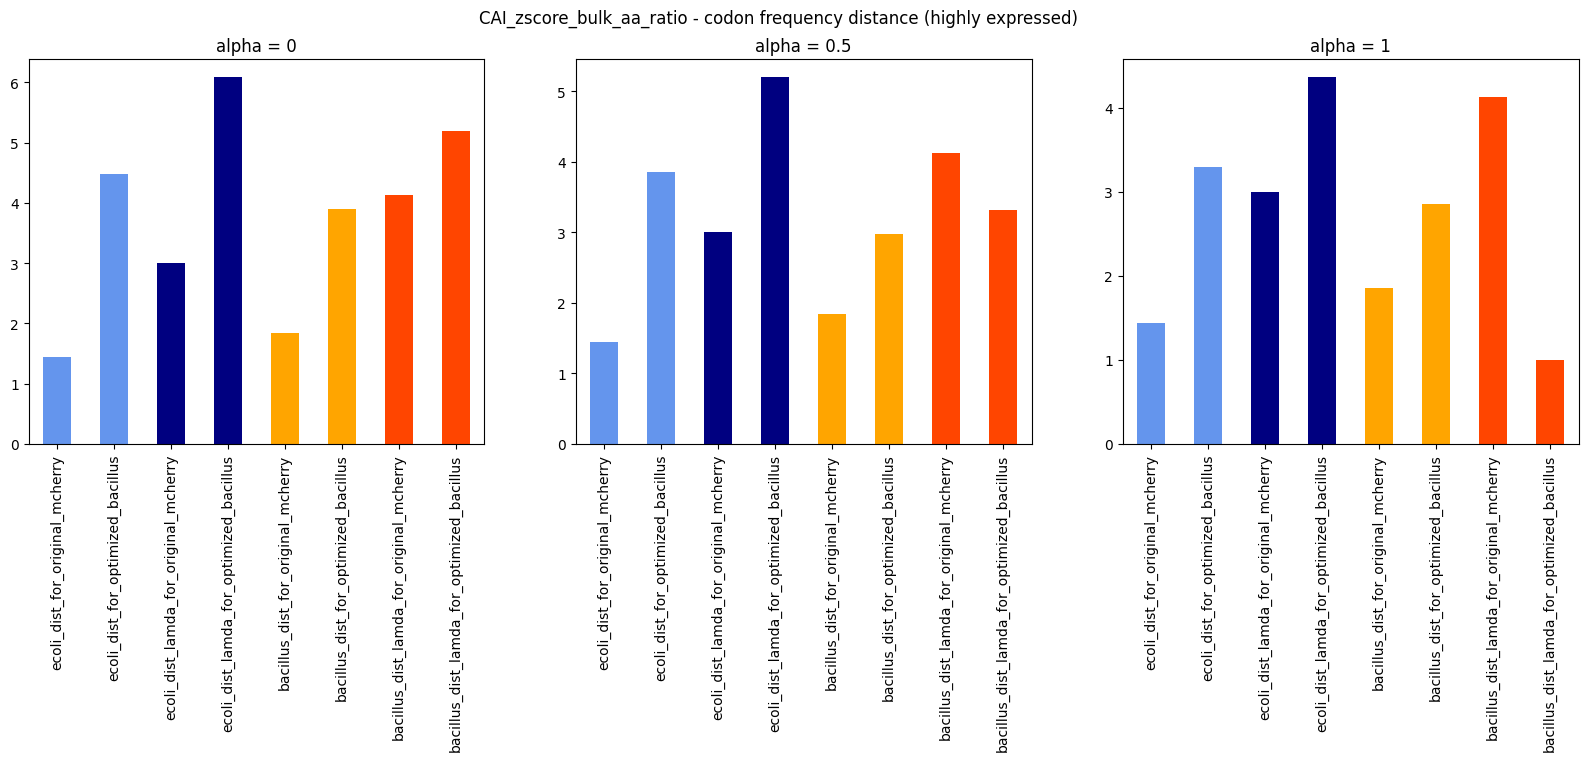

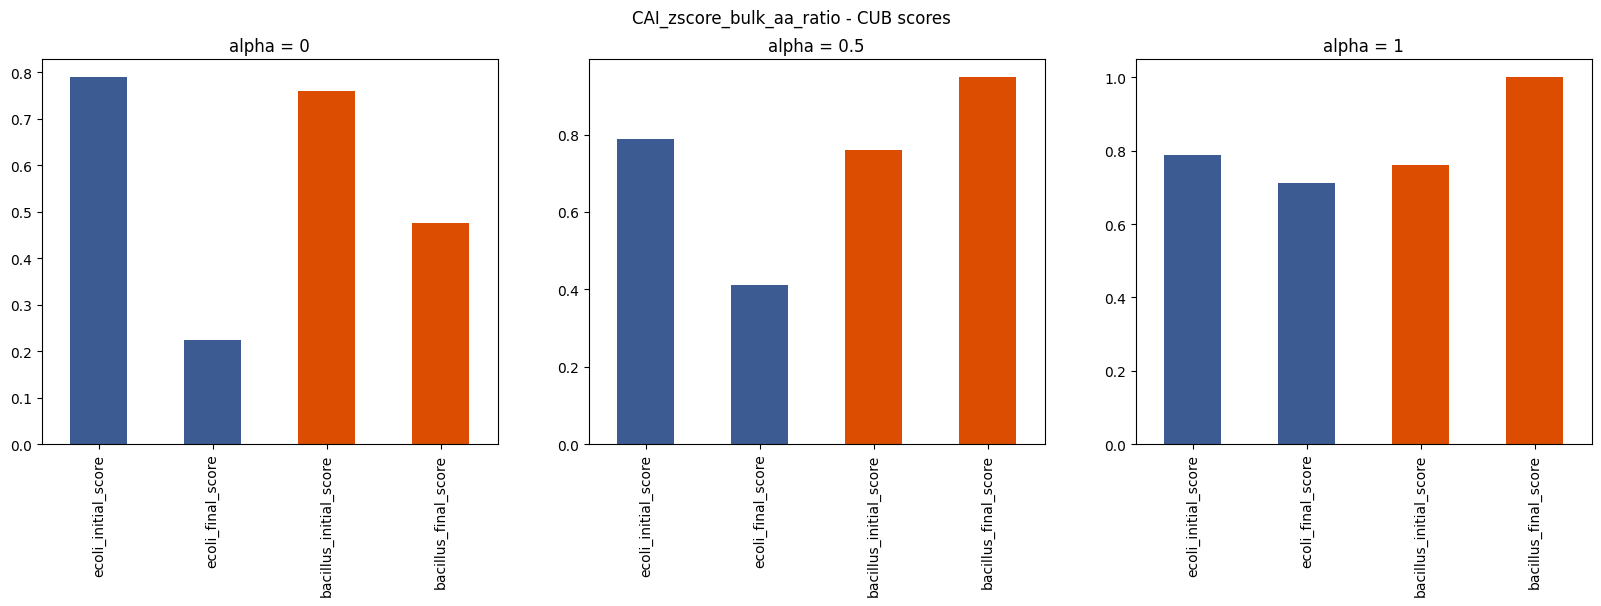

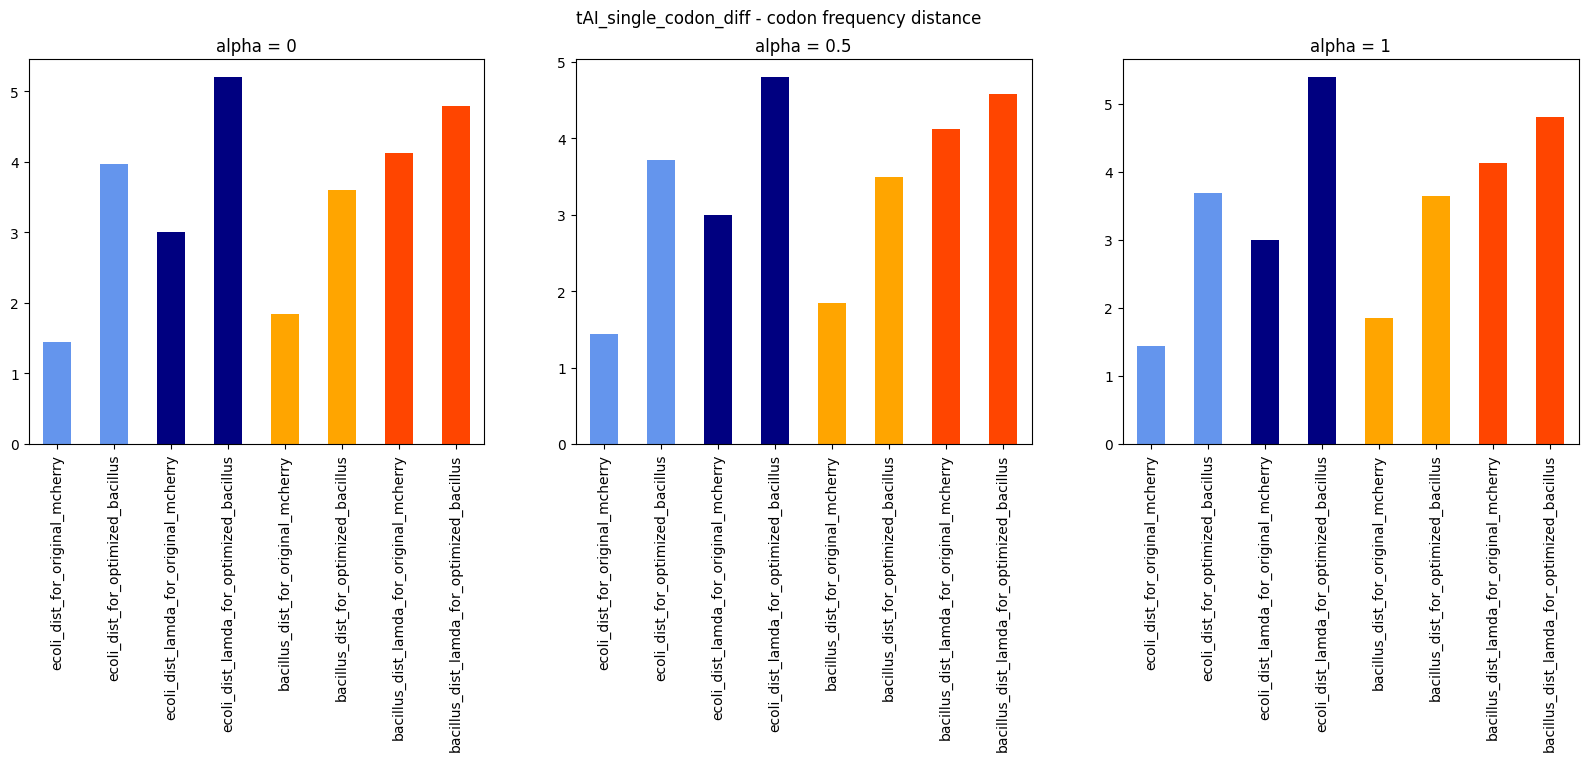

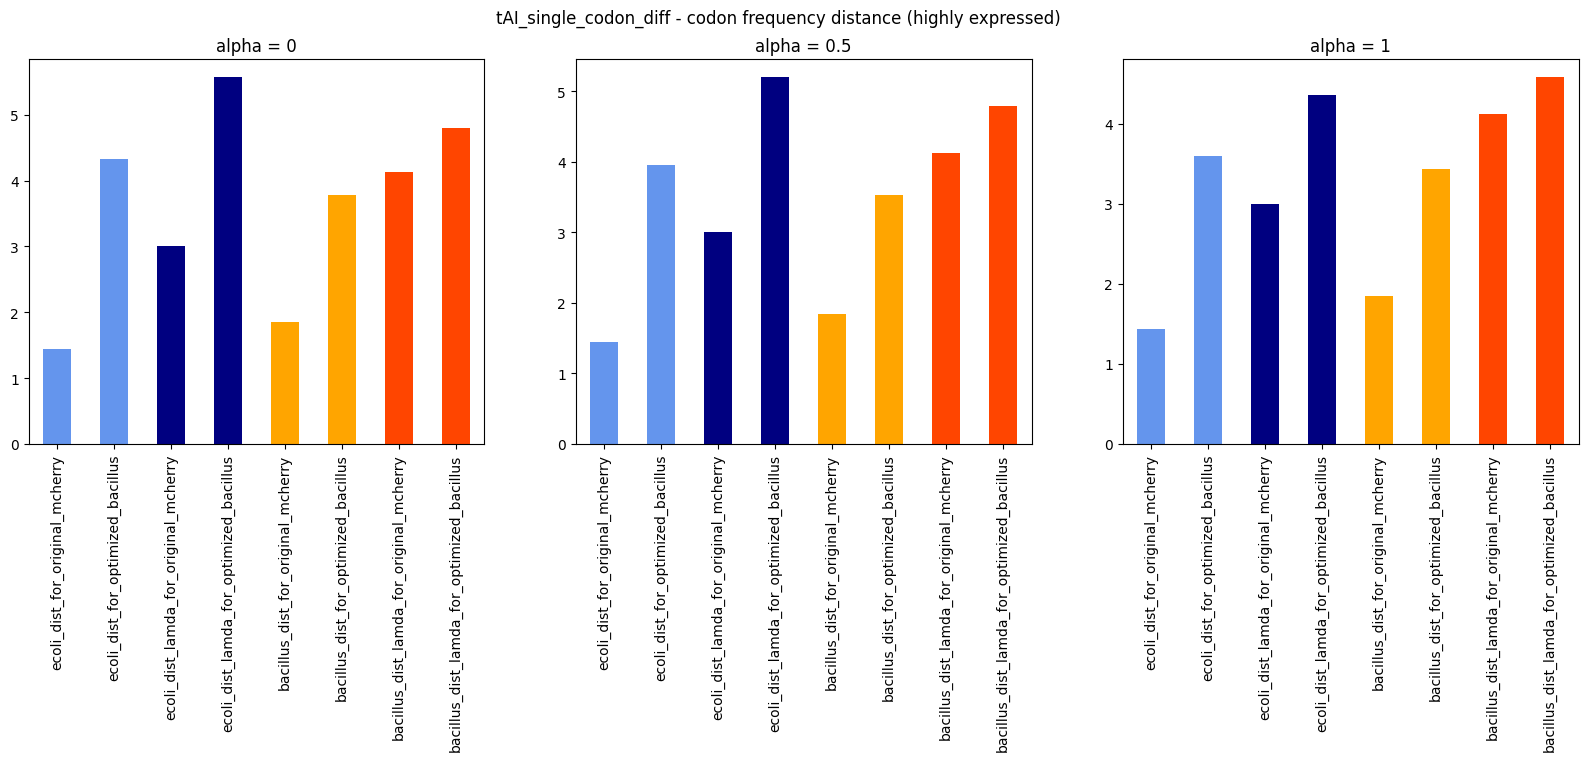

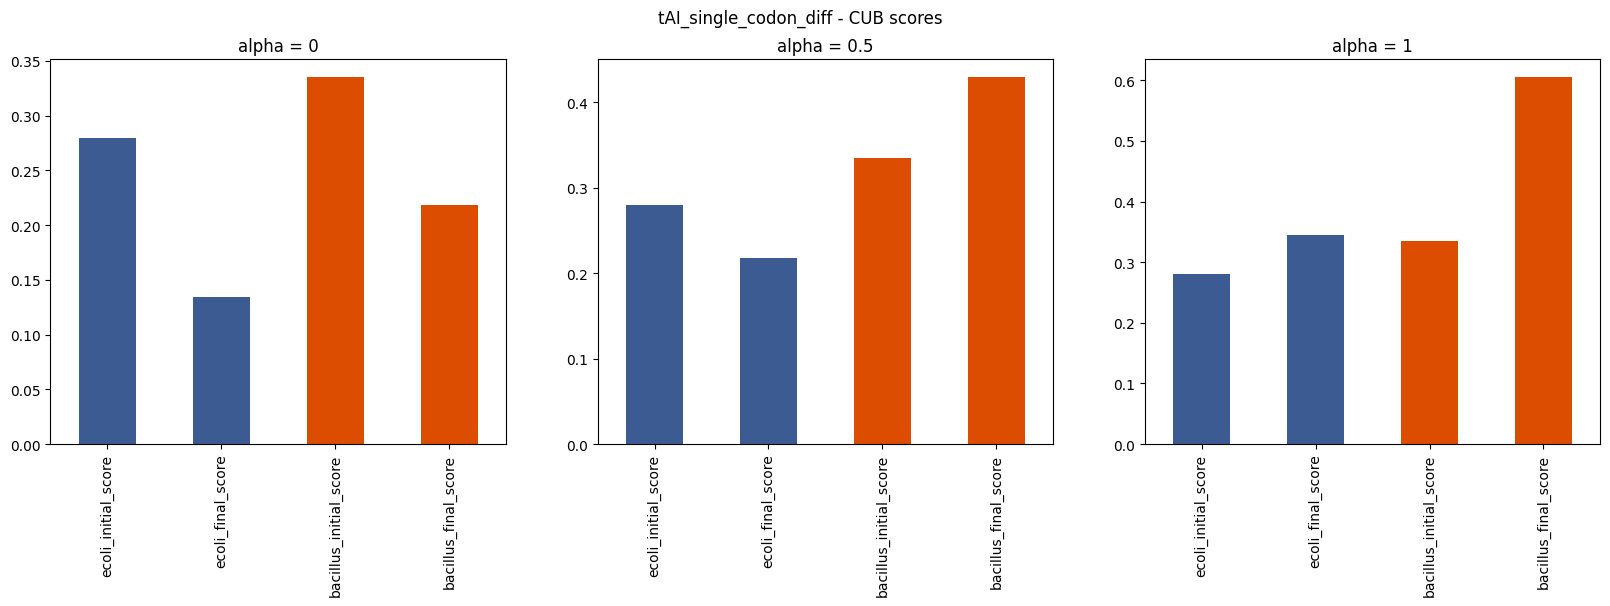

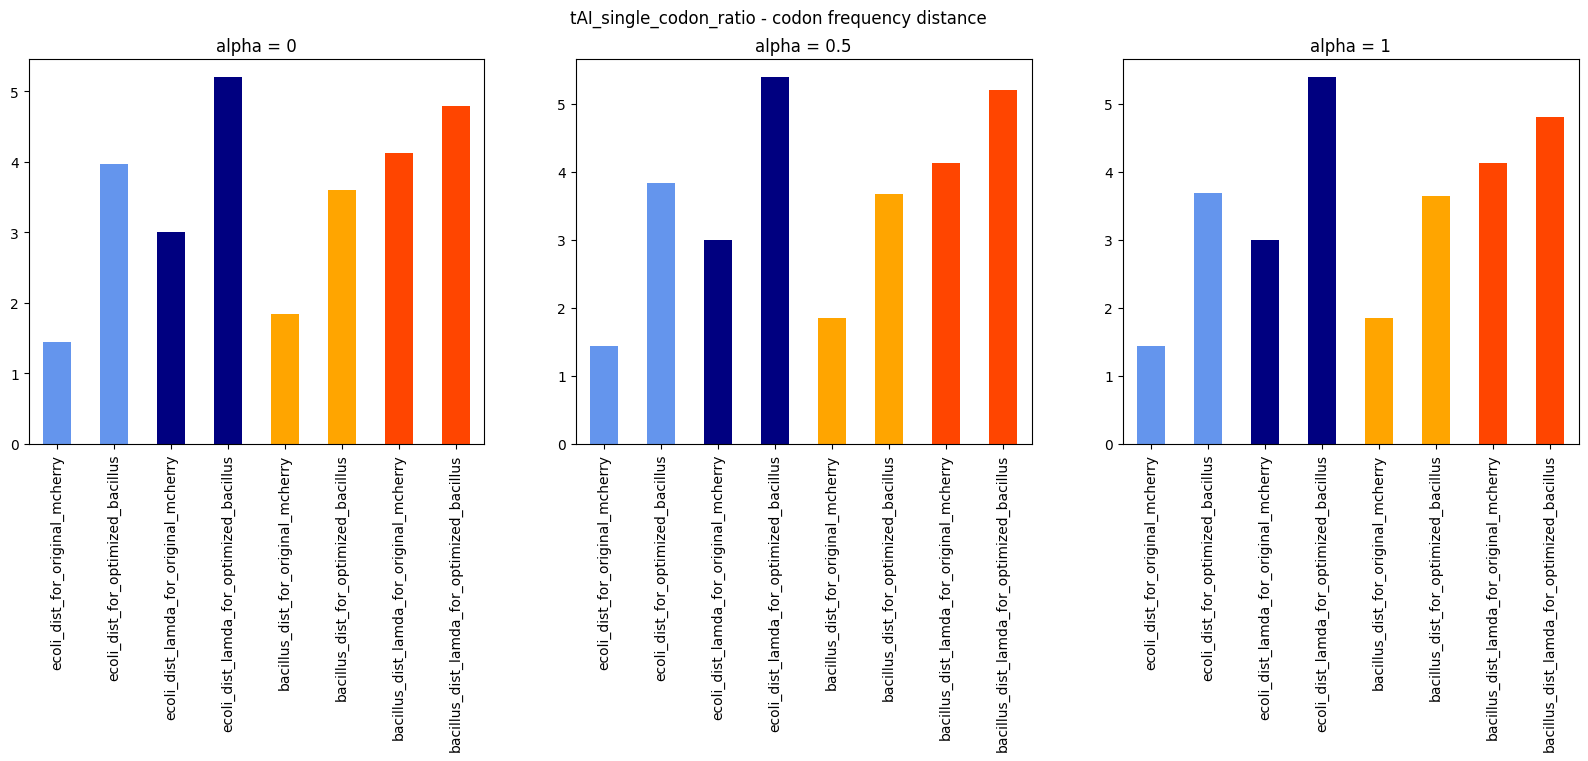

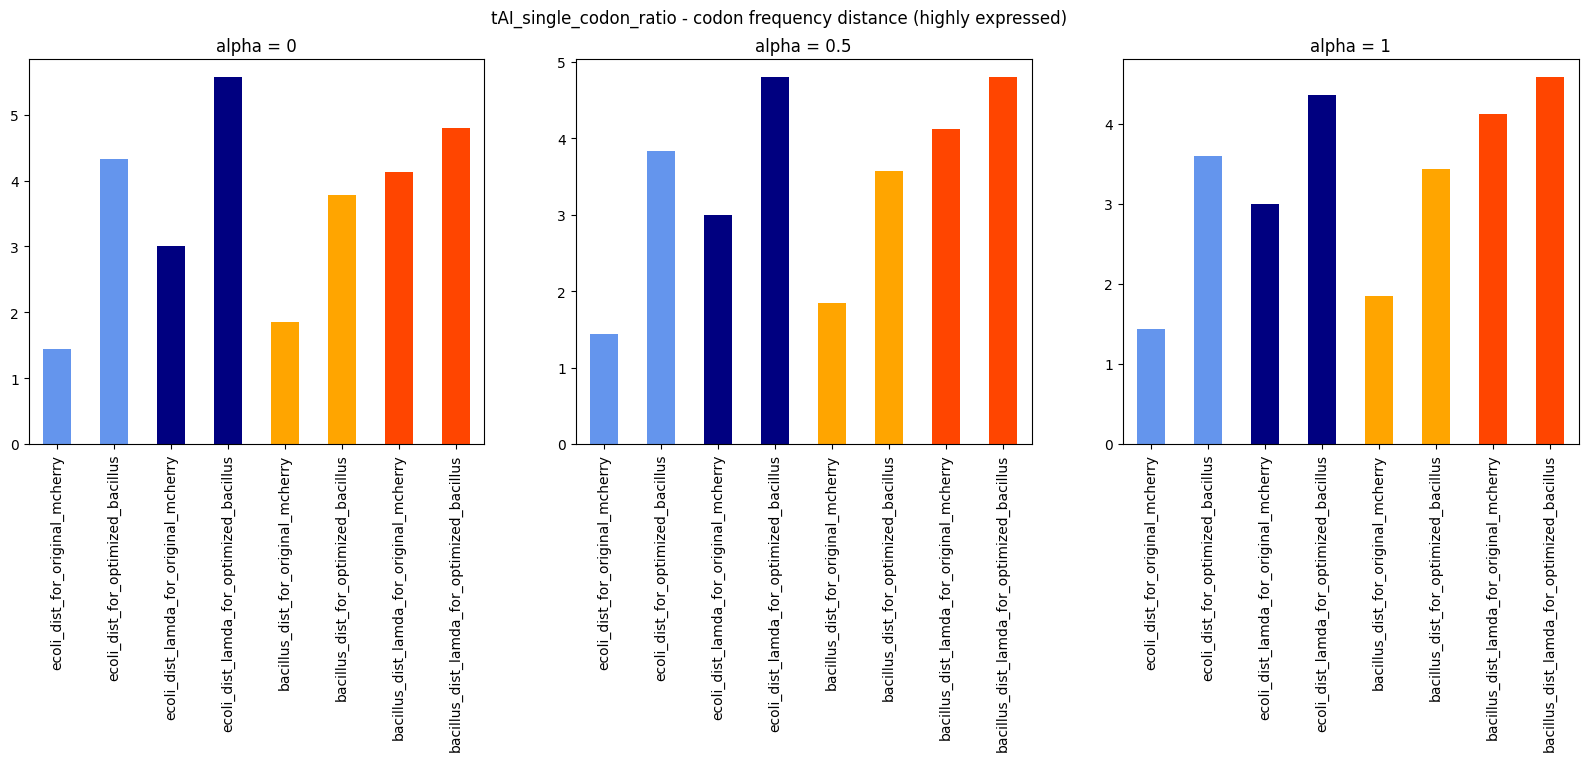

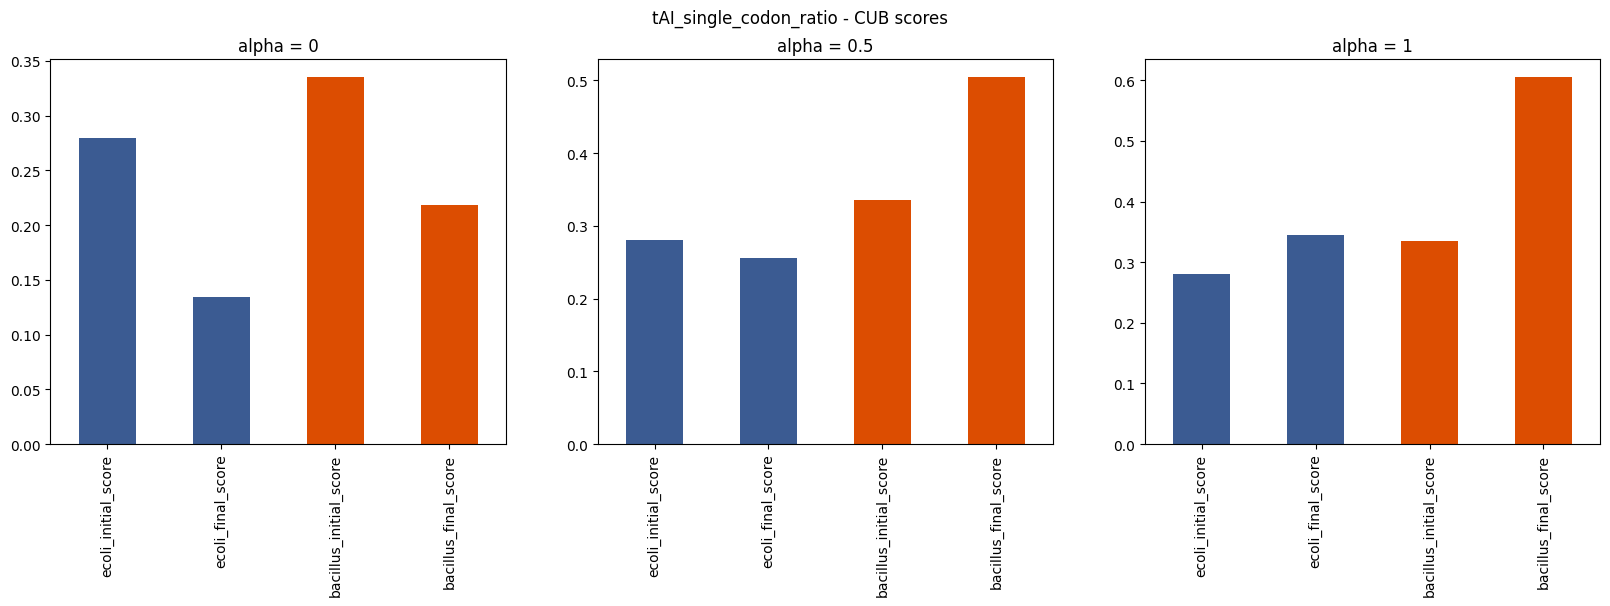

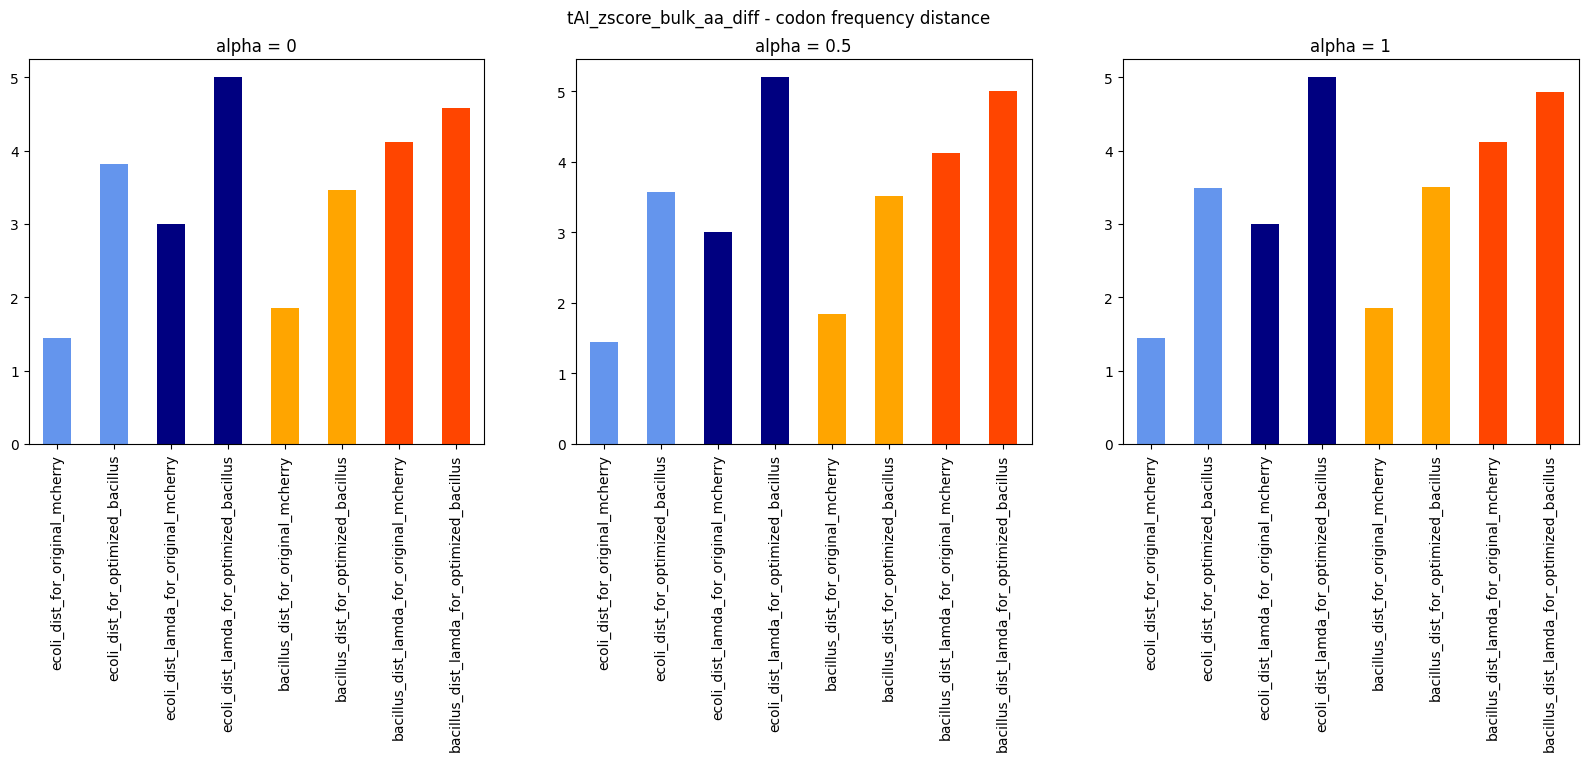

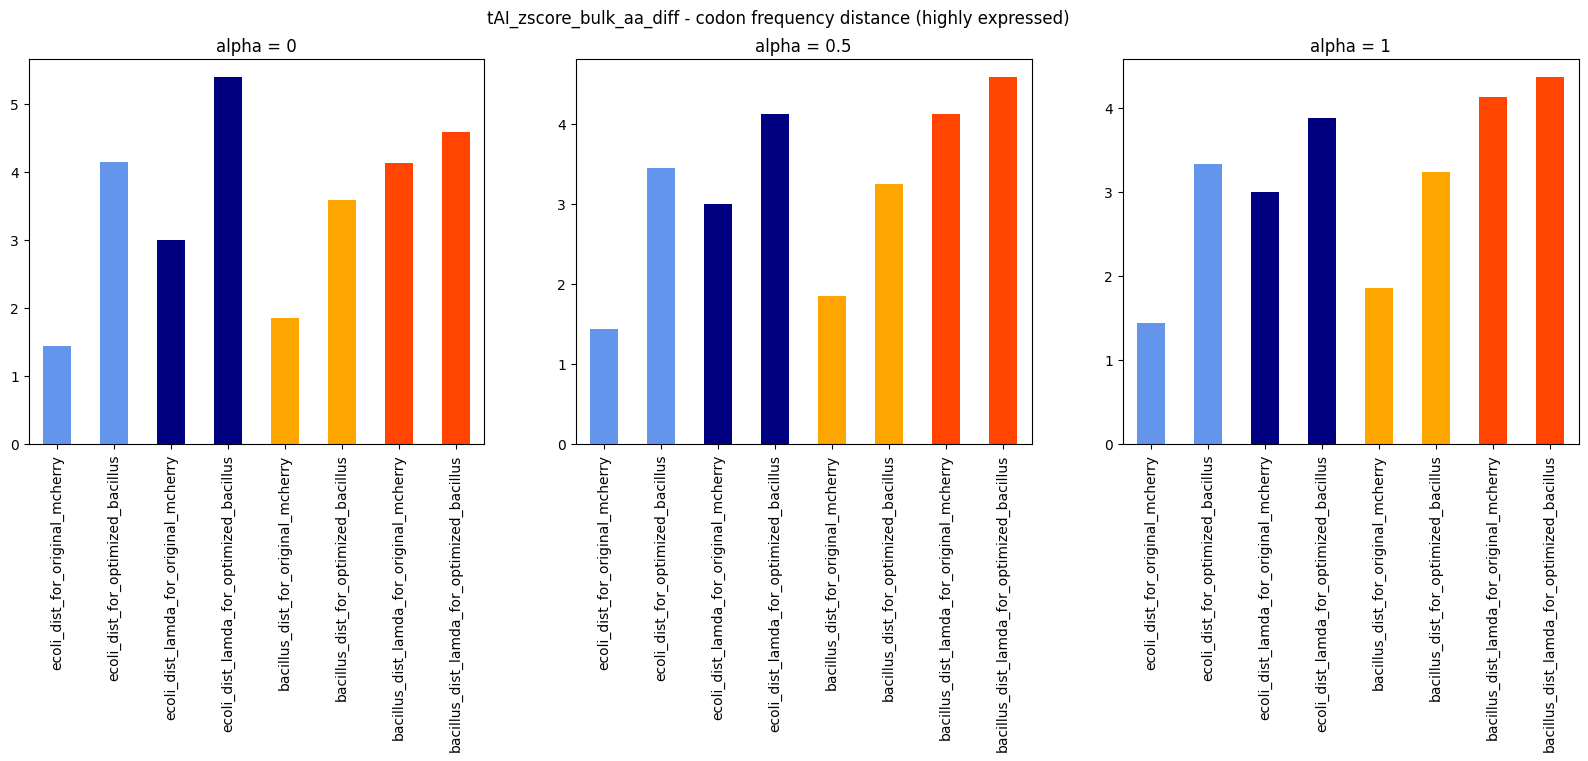

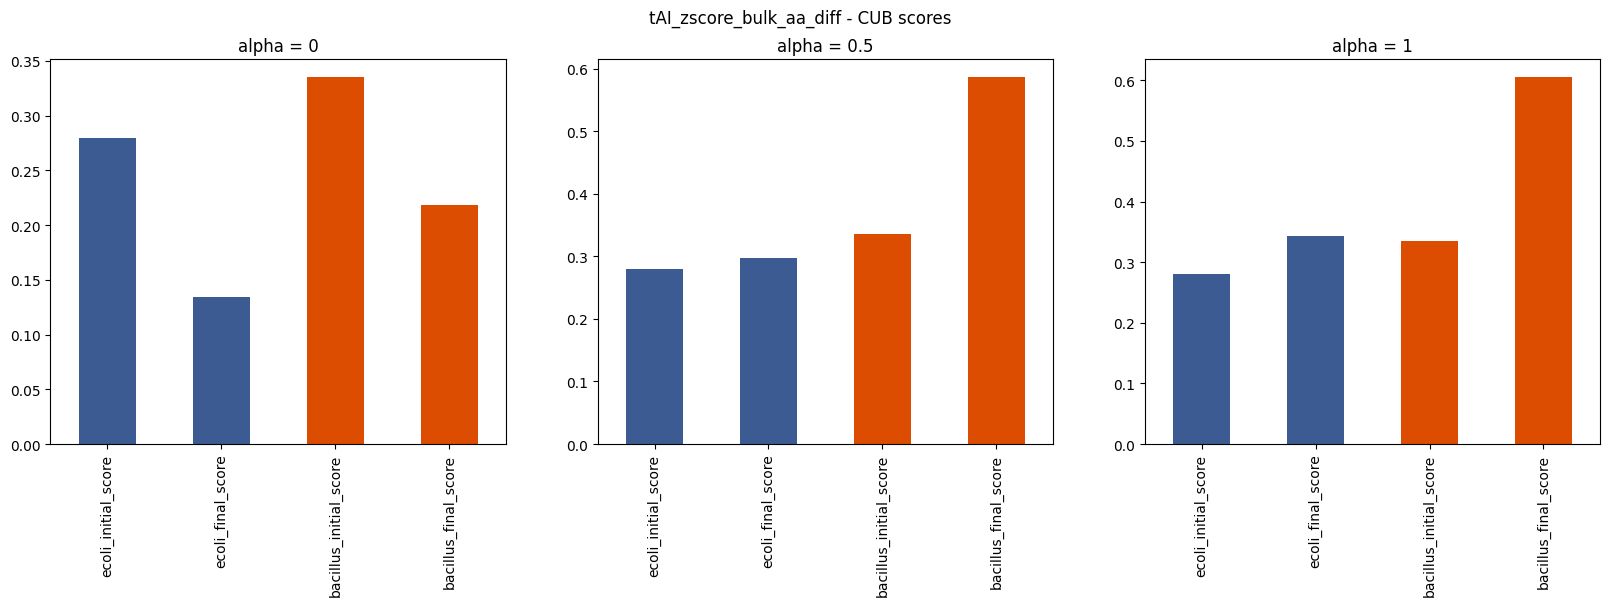

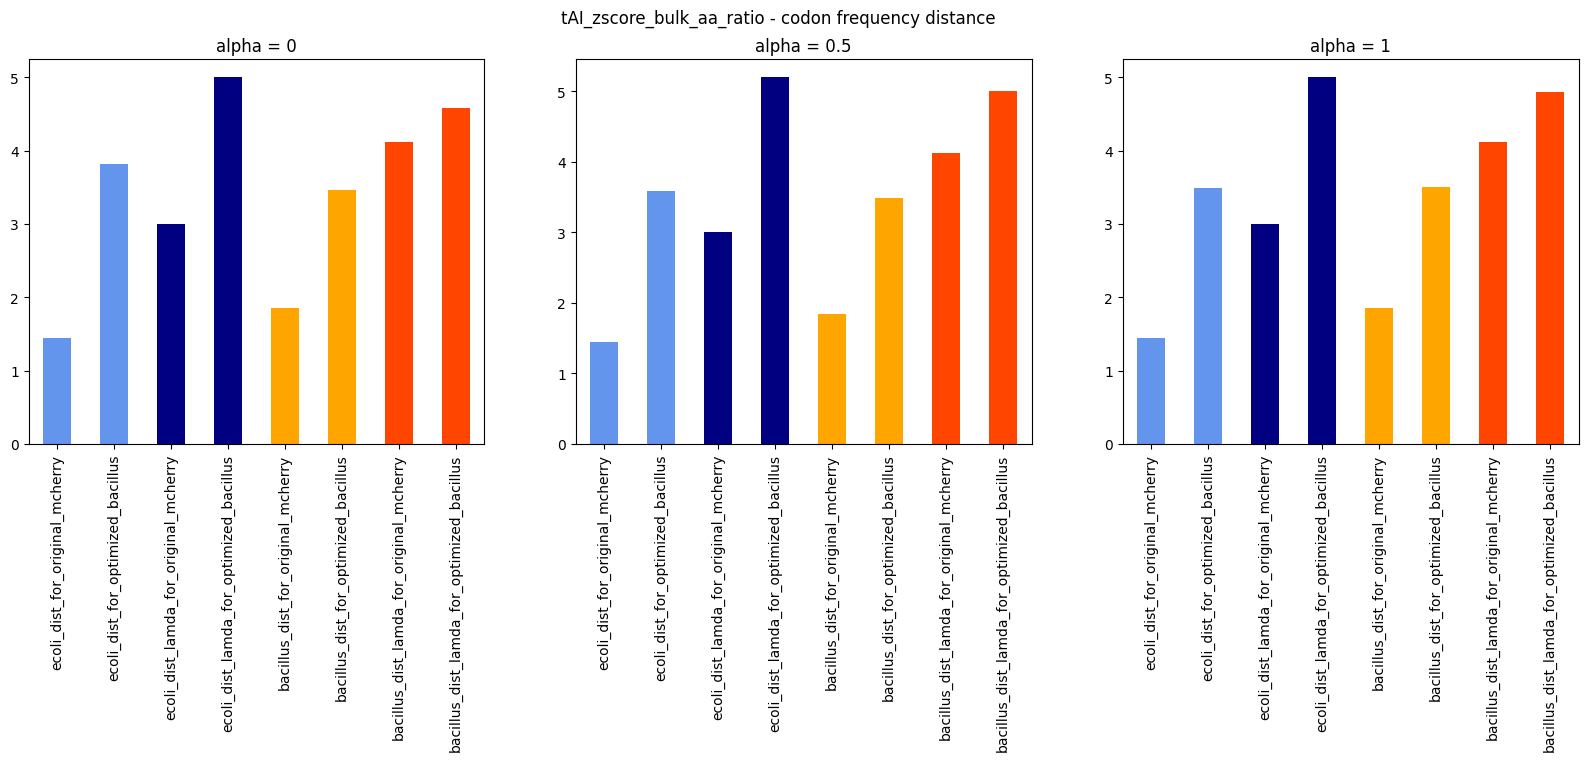

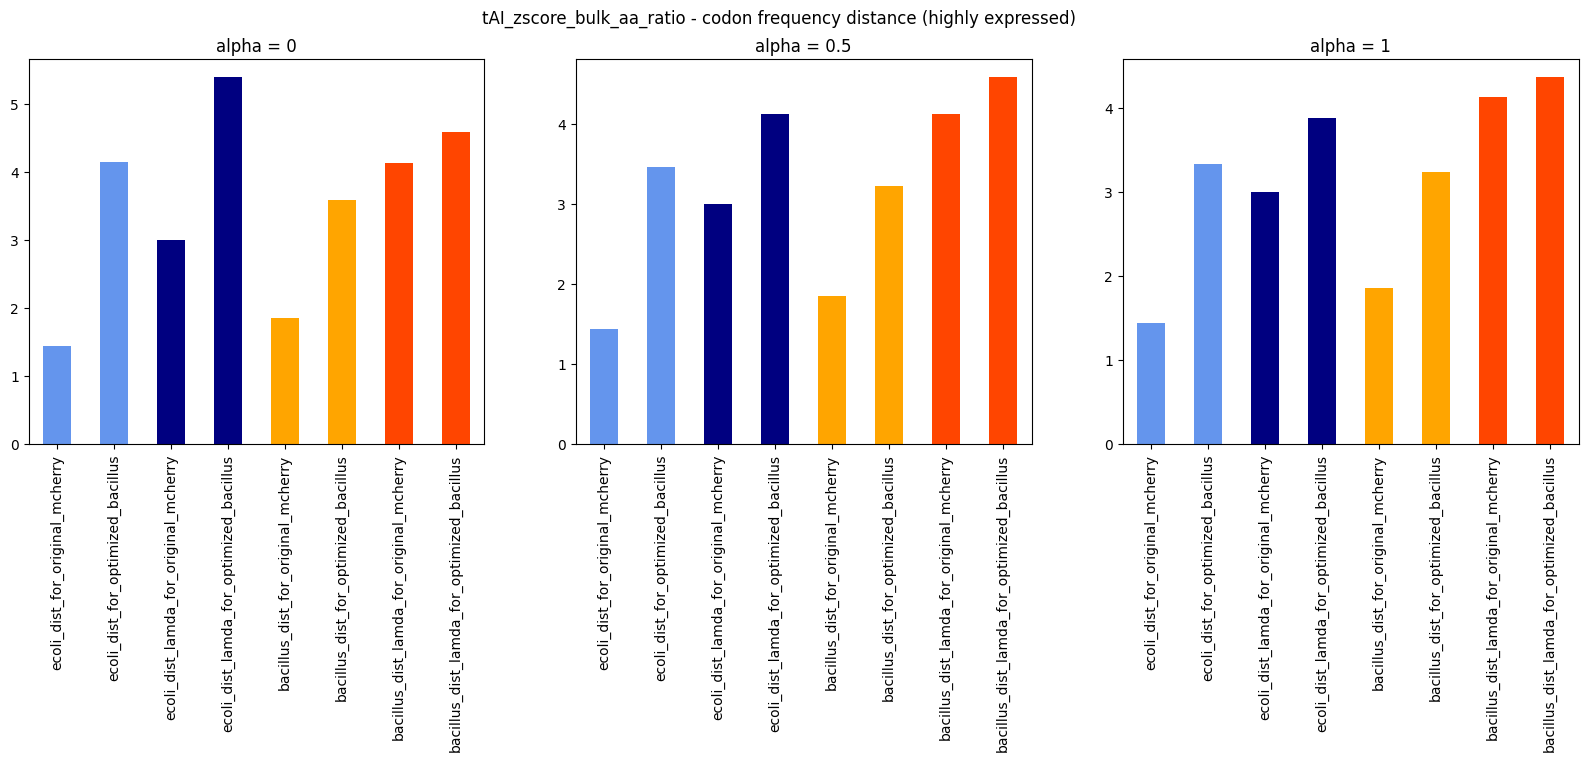

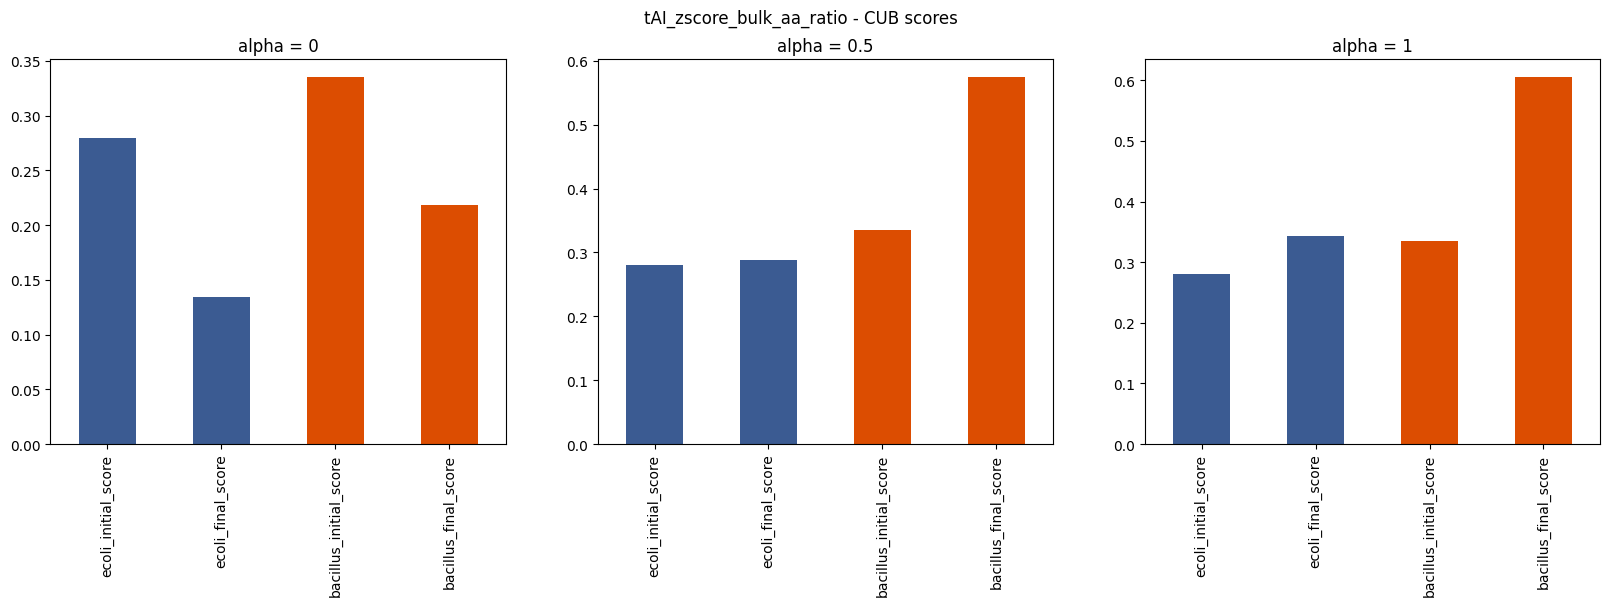

In [79]:
my_colors = ['#3b5b92', '#3b5b92', '#dc4d01', '#dc4d01'] 
my_colors_extended = ['cornflowerblue', 'cornflowerblue', 'navy', 'navy', 'orange', 'orange', 'orangered', 'orangered'] 
for q in range(cub_bacillus_opt_greater_alpha_variants_dataframe.shape[0]):

    fig, axes = plt.subplots(nrows=1,ncols=3, figsize=(20,5))
    fig.suptitle(greater_alpha_bacillus_opt_variants_dataframe.iloc[q,0] + " - codon frequency distance")
    lower_alpha_bacillus_opt_variants_dataframe.iloc[q,1:].plot(x="variant", kind="bar", ax=axes[0], stacked=True, color=my_colors_extended)
    axes[0].set_title("alpha = 0")
    bacillus_opt_variants_dataframe.iloc[q,1:].plot(x="variant", kind="bar", ax=axes[1], stacked=True, color=my_colors_extended)
    axes[1].set_title("alpha = 0.5")
    greater_alpha_bacillus_opt_variants_dataframe.iloc[q,1:].plot(x="variant", kind="bar", ax=axes[2], stacked=True, color=my_colors_extended)
    axes[2].set_title("alpha = 1")
    
    fig, axes = plt.subplots(nrows=1,ncols=3, figsize=(20,5))
    fig.suptitle(greater_alpha_bacillus_opt_variants_dataframe_highly_expressed.iloc[q,0] + " - codon frequency distance (highly expressed)")
    lower_alpha_bacillus_opt_variants_dataframe_highly_expressed.iloc[q,1:].plot(x="variant", kind="bar", ax=axes[0], stacked=True, color=my_colors_extended)
    axes[0].set_title("alpha = 0")
    bacillus_opt_variants_dataframe_highly_expressed.iloc[q,1:].plot(x="variant", kind="bar", ax=axes[1], stacked=True, color=my_colors_extended)
    axes[1].set_title("alpha = 0.5")
    greater_alpha_bacillus_opt_variants_dataframe_highly_expressed.iloc[q,1:].plot(x="variant", kind="bar", ax=axes[2], stacked=True, color=my_colors_extended)
    axes[2].set_title("alpha = 1")


    fig, axes = plt.subplots(nrows=1,ncols=3, figsize=(20,5))
    fig.suptitle(cub_bacillus_opt_greater_alpha_variants_dataframe.iloc[q,0] + " - CUB scores")
    cub_bacillus_opt_lower_alpha_variants_dataframe.iloc[q,1:].plot(x="variant", kind="bar", ax=axes[0], stacked=True, color=my_colors)
    axes[0].set_title("alpha = 0")
    cub_bacillus_opt_variants_dataframe.iloc[q,1:].plot(x="variant", kind="bar", ax=axes[1], stacked=True, color=my_colors)
    axes[1].set_title("alpha = 0.5")
    cub_bacillus_opt_greater_alpha_variants_dataframe.iloc[q,1:].plot(x="variant", kind="bar", ax=axes[2], stacked=True, color=my_colors)
    axes[2].set_title("alpha = 1")

## Debugging negative non normalized score

In [80]:
with open(r"C:\projects\Igem_TAU_2021_moran\analysis\example_data\Bacillus-subtilis.fasta", "r") as fasta_handle:
        genome_dict = SeqIO.to_dict(SeqIO.parse(fasta_handle, "fasta"))
gene_name = "rpmJ|ribosomal"

gene_sequence = genome_dict[gene_name]
gene_sequence = str(gene_sequence.seq)

results = run_single_method_for_orf_sequence(
    optimization_method="single_codon_diff",
    optimization_cub_index="CAI",
    is_ecoli_optimized=False,
    output_path="endogenous",
    orf_sequence=gene_sequence,
)

##########################
# USER INPUT INFORMATION #
##########################

Information about Bacillus subtilis:
Organism is optimized
Extracting expression levels from: mrna_levels file.
Number of genes: 4311
Found 98 ribosomal proteins in input genome.
CAI will be calculated from a reference set of estimated expression dictionary.
Expression levels were found for 1863
Calculate CAI weights from a reference set of 279 highly expressed genes from estimated expression dictionary.
name=Bacillus subtilis, cai_std=0.045345530173045864, cai_avg=0.7184307815208769

Information about Escherichia coli:
Organism is deoptimized
Extracting expression levels from: mrna_levels file.
Number of genes: 4310
Found 90 ribosomal proteins in input genome.
CAI will be calculated from a reference set of estimated expression dictionary.
Expression levels were found for 3215
Calculate CAI weights from a reference set of 482 highly expressed genes from estimated expression dictionary.
name=Escherichia co

In [81]:
results_df_dict = {"selected_codon": [], "amino_acid": [], "bacillus_weight": [], "ecoli_weight": [], "loss": []}
for amino_acid in results["orf_debug"].keys():
    results_df_dict["amino_acid"].append(amino_acid)
    selected_codon = results["orf"]["aa_to_optimal_codon"][amino_acid]
    results_df_dict["selected_codon"].append(selected_codon)
    results_df_dict["loss"].append( results["orf_debug"][amino_acid][selected_codon])
    results_df_dict["bacillus_weight"].append(results["user_input"]["organisms"][0]["cai_weights"][selected_codon])
    results_df_dict["ecoli_weight"].append(results["user_input"]["organisms"][1]["cai_weights"][selected_codon])
results_df = pd.DataFrame(results_df_dict)
results_df

selected_codon amino_acid  bacillus_weight  ecoli_weight      loss
0             TGT          C         0.797710      0.708585  0.271507
1             GAC          D         0.688792      0.862116  0.420047
2             TCA          S         0.801439      0.312981  0.068692
3             CAA          Q         1.000000      0.380665  0.072453
4             ATG          M         1.000000      1.000000  0.500000
5             AAT          N         0.713511      0.434827  0.135575
6             CCT          P         0.816828      0.212318  0.039315
7             AAG          K         0.329648      0.287483  0.266009
8             TAG          _         0.090517      0.045822  0.414629
9             ACA          T         1.000000      0.166053  0.013787
10            TTT          F         1.000000      0.734578  0.269803
11            GCT          A         1.000000      0.652174  0.212665
12            GGA          G         0.830716      0.129615  0.022729
13            ATT          I         1.000000      0.783749  0.307131
14            CTT          L         1.000000      0.124941  0.007805
15            CAT          H         1.000000      0.749283  0.280712
16            AGA          R         0.507009      0.023639  0.121799
17            TGG          W         1.000000      1.000000  0.500000
18            GTA          V         0.719490      0.530044  0.179816
19            GAG          E         0.409400      0.363714  0.240548
20            TAT          Y         1.000000      0.828947  0.343577

In [82]:
initial_seq = results["user_input"]["sequence"]

codons_stats = defaultdict(int)

for i in range(0, len(initial_seq), 3):
    codon = initial_seq[i:i+3]
    codons_stats[codon] += 1
initial_seq_df_dict = {"codon": [], "count": [], "amino_acid": [], "bacillus_weight": [], "ecoli_weight": [], "loss": []}

for codon, amino_acid in shared_functions_and_vars.nt_to_aa.items():
    initial_seq_df_dict["codon"].append(codon)
    initial_seq_df_dict["amino_acid"].append(amino_acid)
    # count = codons_stats.get(codon) or 0
    initial_seq_df_dict["count"].append(codons_stats[codon])
    initial_seq_df_dict["bacillus_weight"].append(results["user_input"]["organisms"][0]["cai_weights"][codon])
    initial_seq_df_dict["ecoli_weight"].append(results["user_input"]["organisms"][1]["cai_weights"][codon])
    initial_seq_df_dict["loss"].append(results["orf_debug"][amino_acid][codon])
initial_seq_df = pd.DataFrame(initial_seq_df_dict)
initial_seq_df.sort_values("count")
initial_seq_df.nlargest(20, "count")

codon  count amino_acid  bacillus_weight  ecoli_weight      loss
10   AAA      8          K         1.000000      1.000000  0.500000
20   CCA      3          P         0.517498      0.272015  0.153400
1    ATC      2          I         0.929523      1.000000  0.502483
3    ATG      2          M         1.000000      1.000000  0.500000
14   AGA      2          R         0.507009      0.023639  0.121799
26   CAA      2          Q         1.000000      0.380665  0.072453
34   GTG      2          V         0.651184      0.978501  0.539568
35   GTT      2          V         1.000000      1.000000  0.500000
42   GAA      2          E         1.000000      1.000000  0.500000
44   GGA      2          G         0.830716      0.129615  0.022729
61   TGT      2          C         0.797710      0.708585  0.271507
2    ATT      1          I         1.000000      0.783749  0.307131
9    AAT      1          N         0.713511      0.434827  0.135575
11   AAG      1          K         0.329648      0.287483  0.266009
25   CAT      1          H         1.000000      0.749283  0.280712
29   CGC      1          R         0.897196      0.747107  0.284368
32   GTA      1          V         0.719490      0.530044  0.179816
48   TCA      1          S         0.801439      0.312981  0.068692
58   TAA      1          _         1.000000      1.000000  0.500000
60   TGC      1          C         1.000000      1.000000  0.500000

In [83]:
merged_results_df = pd.merge(initial_seq_df, results_df, on='amino_acid', how='inner', suffixes=("", "_selected_codon"))
merged_results_df.nlargest(20, "count")

codon  count amino_acid  bacillus_weight  ecoli_weight      loss  \
10   AAA      8          K         1.000000      1.000000  0.500000   
30   CCA      3          P         0.517498      0.272015  0.153400   
1    ATC      2          I         0.929523      1.000000  0.502483   
3    ATG      2          M         1.000000      1.000000  0.500000   
18   AGA      2          R         0.507009      0.023639  0.121799   
36   CAA      2          Q         1.000000      0.380665  0.072453   
40   GTG      2          V         0.651184      0.978501  0.539568   
41   GTT      2          V         1.000000      1.000000  0.500000   
48   GAA      2          E         1.000000      1.000000  0.500000   
50   GGA      2          G         0.830716      0.129615  0.022729   
62   TGT      2          C         0.797710      0.708585  0.271507   
2    ATT      1          I         1.000000      0.783749  0.307131   
9    AAT      1          N         0.713511      0.434827  0.135575   
11   AAG      1          K         0.329648      0.287483  0.266009   
14   TCA      1          S         0.801439      0.312981  0.068692   
21   CGC      1          R         0.897196      0.747107  0.284368   
35   CAT      1          H         1.000000      0.749283  0.280712   
38   GTA      1          V         0.719490      0.530044  0.179816   
58   TAA      1          _         1.000000      1.000000  0.500000   
61   TGC      1          C         1.000000      1.000000  0.500000   

   selected_codon  bacillus_weight_selected_codon  \
10            AAG                        0.329648   
30            CCT                        0.816828   
1             ATT                        1.000000   
3             ATG                        1.000000   
18            AGA                        0.507009   
36            CAA                        1.000000   
40            GTA                        0.719490   
41            GTA                        0.719490   
48            GAG                        0.409400   
50            GGA                        0.830716   
62            TGT                        0.797710   
2             ATT                        1.000000   
9             AAT                        0.713511   
11            AAG                        0.329648   
14            TCA                        0.801439   
21            AGA                        0.507009   
35            CAT                        1.000000   
38            GTA                        0.719490   
58            TAG                        0.090517   
61            TGT                        0.797710   

    ecoli_weight_selected_codon  loss_selected_codon  
10                     0.287483             0.266009  
30                     0.212318             0.039315  
1                      0.783749             0.307131  
3                      1.000000             0.500000  
18                     0.023639             0.121799  
36                     0.380665             0.072453  
40                     0.530044             0.179816  
41                     0.530044             0.179816  
48                     0.363714             0.240548  
50                     0.129615             0.022729  
62                     0.708585             0.271507  
2                      0.783749             0.307131  
9                      0.434827             0.135575  
11                     0.287483             0.266009  
14                     0.312981             0.068692  
21                     0.023639             0.121799  
35                     0.749283             0.280712  
38                     0.530044             0.179816  
58                     0.045822             0.414629  
61                     0.708585             0.271507

In [84]:
# TODO - parse the .out file instead. 

# e_coli_dict = {"name": "Escherichia-coli", 
#                "AGC": 0, "GGC": 2, "CGC": 0, "TGC": 3,
#                "ACC": 0, "GCC": 4, "CCC": 1, "TCC": 1,
#                "AGG": 0, "GGG": 1, "CGG": 1, "TGG": 1, 
#                "AGT": 0, "GGT": 2, "CGT": 2, "TGT": 1,
#                "AAC": 0, }
bacillus_dict = {"name": "Bacillus-subtilis", "val": 2}
json_dict = [e_coli_dict, bacillus_dict]

with open("test.json", "w") as json_file:
    json.dump(json_dict, json_file)

df = pd.read_json("test.json")

NameError: name 'e_coli_dict' is not defined

In [ ]:
df